# CAPSTONE - Grade Predictions for A Level H2 Math
IMPORTANT NOTE: You may run this notebook but the results will change as only 500 rows of data for each batch is shared due to confidentiality. In addition, CCA & CIP Datasets are withheld due to confidentiality and the cells from that section onwards will not run properly.

---
# (2) Data Cleaning and Exploratory Data Analysis

The data used is real students' data requested from an actual school. It has not been treated for data processing purposes and no explanations of each column were provided. We use our experience from teaching in the school and our familiarity with subject codes from being part of the timetabling committee to interpret the data and clean it properly.

As one of the objectives of this project is to generate predictions for students who missed the Prelim exam, we cannot drop any row even if information is missing but must instead impute it in a sensible way. Hence exploratory data analysis (EDA) is especially important and creative feature engineering may be required to create full columns with no missing values.

We run through all our datasets systematically, dealing with the same type of dataset for all 3 batches at once. After thoroughly investigating our data and selecting features to use through correlation coefficients with the target and our business understanding of this use case, we generate one features dataset for each batch that is saved as csv files, to be used in the next notebook on [Modelling](3_Modelling.ipynb).

## Contents
- [A Level Grades](#A-Level-Grades)
- [Prelim Datasets](#Prelim-Datasets)
- [C1 Datasets](#C1-Datasets)
- [Sec4 Datasets](#Sec4-Datasets)
- [CCA & CIP Datasets](#CCA/CIP-Datasets)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# set parameters for plots
plt.rcParams['figure.figsize'] = [16,8]
plt.style.use('fivethirtyeight')

# disable warning 'A value is trying to be set on a copy of a slice from a DataFrame'
pd.options.mode.chained_assignment = None

# display up to 80 rows
pd.set_option("display.max_rows", 80)

---
# A Level Grades

In [2]:
# load target, only MA2 (H2 Math) ignore other subjects FM2, MA1 and MA3-MOE
y_18 = pd.read_csv('../data_raw/18 Batch GCEA.csv', usecols=['NEWID','MA2'], index_col='NEWID')
y_19 = pd.read_csv('../data_raw/19 Batch GCEA.csv', usecols=['NEWID','MA2'], index_col='NEWID')

display(y_18.head())
print('Batch 18')

display(y_19.head())
print('Batch 19')

,MA2
NEWID,
20180001,A
20180002,A
20180003,A
20180004,NaN
20180005,A


Batch 18


,MA2
NEWID,
20190001,B
20190002,A
20190003,A
20190004,B
20190005,C


Batch 19


In [3]:
#HIDDEN number of rows and unique IDs due to confidentiality
# check number of rows, no duplicates in 'NEWID' and number of students who did not take MA2
print(' Batch 18 '.center(34, "="))
# print(f"Number of rows: {y_18.shape[0]}")
# print(f"Number of unique IDs: {y_18.index.nunique()}")
print(f"Number of students without MA2: {y_18['MA2'].isna().sum()}")
print()

print(' Batch 19 '.center(34, "="))
# print(f"Number of rows: {y_19.shape[0]}")
# print(f"Number of unique IDs: {y_19.index.nunique()}")
print(f"Number of students without MA2: {y_19['MA2'].isna().sum()}")

============ Batch 18 ============
Number of students without MA2: 57

============ Batch 19 ============
Number of students without MA2: 35


In [4]:
# save indices to remove rows without from datasets
ind_to_del_18 = y_18[y_18['MA2'].isna()].index
ind_to_del_19 = y_19[y_19['MA2'].isna()].index

# drop students who did not take MA2
y_18.drop(index=ind_to_del_18, inplace=True)
y_19.drop(index=ind_to_del_19, inplace=True)

#HIDDEN due to confidentiality
# # frequency of grades
# print(' Batch 18 '.center(20, "="))
# print(y_18.value_counts().sort_index())
# print()
# print(' Batch 19 '.center(20, "="))
# print(y_19.value_counts().sort_index())

In [5]:
# combine grades E, S, U into one category as the frequencies are very low
y_18['MA2'].replace({'E': 'ESU', 'S': 'ESU', 'U': 'ESU'}, inplace=True)
y_19['MA2'].replace({'E': 'ESU', 'S': 'ESU', 'U': 'ESU'}, inplace=True)

#HIDDEN due to confidentiality
# # frequency of grades
# print(' Batch 18 '.center(20, "="))
# print(y_18.value_counts().sort_index())
# print()
# print(' Batch 19 '.center(20, "="))
# print(y_19.value_counts().sort_index())

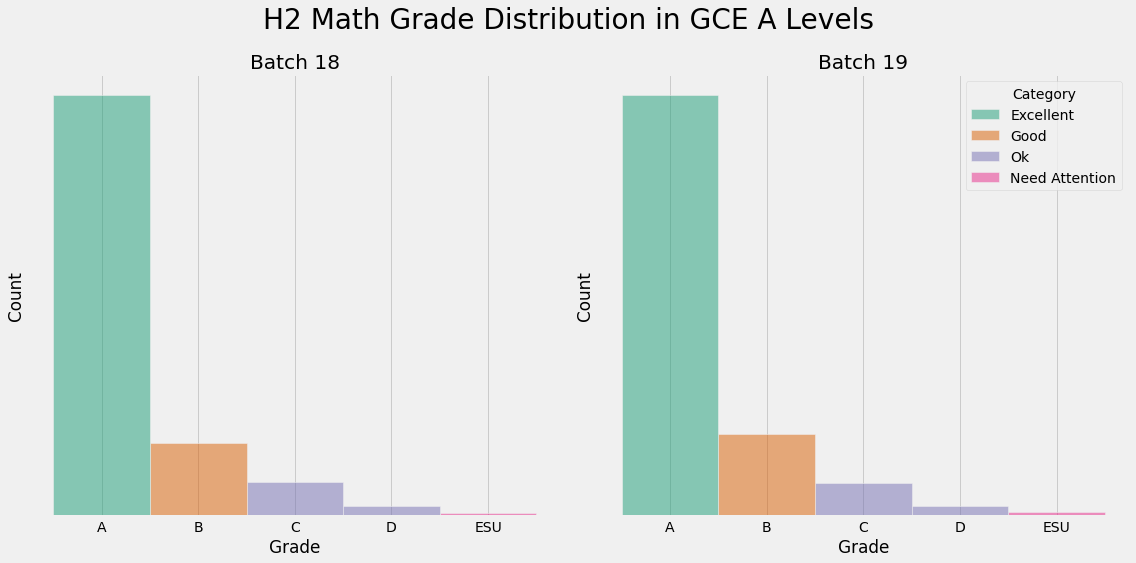

In [6]:
# plot histogram showing grade distribution
grade_cat = {'A':'Excellent', 'B':'Good', 'C':'Ok', 'D':'Ok', 'ESU':'Need Attention'}
y_18['Category'] = y_18['MA2'].map(grade_cat)
y_19['Category'] = y_19['MA2'].map(grade_cat)

fig, ax = plt.subplots(1,2)
fig.suptitle('H2 Math Grade Distribution in GCE A Levels', fontsize=28)
sns.histplot(y_18.sort_values('MA2'), x='MA2', hue='Category', palette='Dark2', ax=ax[0], legend=False)
ax[0].set_title('Batch 18')
ax[0].set_xlabel('Grade')

sns.histplot(y_19.sort_values('MA2'), x='MA2', hue='Category', palette='Dark2', ax=ax[1])
ax[1].set_title('Batch 19')
ax[1].set_xlabel('Grade')

#HIDDEN y count values due to confidentiality
ax[0].set_yticks([])
ax[1].set_yticks([])

plt.tight_layout();

## Analysis of Grade Distribution
The vast majority of students obtained an excellent grade of A, and a very small minority either failed (grade S or U) or were very close to failing (grade E).

The distribution patterns of both batches are very similar, indicating stability across batches, hence it is reasonable to build a model to make predictions for future batches as well.

In [7]:
# convert grades to numerical labels for calculating correlation
grade_dict_target = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'ESU': 4}

y_18['Target'] = y_18['MA2'].replace(grade_dict_target)
y_19['Target'] = y_19['MA2'].replace(grade_dict_target)

---
# Prelim Datasets

In [8]:
# load Batch 18 datasets on Prelim Results
Prelim_Grades_18 = pd.read_csv('../data_raw/18 Batch Prelim Grades.csv', index_col='NEWID')
Prelim_Marks_18 = pd.read_csv('../data_raw/18 Batch Prelim Marks.csv', index_col='NEWID')
Prelim_Perc_18 = pd.read_csv('../data_raw/18 Batch Prelim Percentiles.csv', index_col='NEWID')

# load Batch 19 datasets on Prelim Results
Prelim_Grades_19 = pd.read_csv('../data_raw/19 Batch Prelim Grades.csv', index_col='NEWID')
Prelim_Marks_19 = pd.read_csv('../data_raw/19 Batch Prelim Marks.csv', index_col='NEWID')
Prelim_Perc_19 = pd.read_csv('../data_raw/19 Batch Prelim Percentiles.csv', index_col='NEWID')

# load Batch 20 datasets on Prelim Results
Prelim_Grades_20 = pd.read_csv('../data_raw/20 Batch Prelim Grades.csv', index_col='NEWID')
Prelim_Marks_20 = pd.read_csv('../data_raw/20 Batch Prelim Marks.csv', index_col='NEWID')
Prelim_Perc_20 = pd.read_csv('../data_raw/20 Batch Prelim Percentiles.csv', index_col='NEWID')

#HIDDEN number of rows and unique IDs due to confidentiality
print(' Batch 20 '.center(34, "="))
# # check number of rows in Batch 20
# print(f"Number of rows: {Prelim_Grades_20.shape[0]}")
# # check no duplicates in 'NEWID' of Batch 20
# print(f"Number of unique IDs: {Prelim_Grades_20.index.nunique()}")
# number of students who did not take MA2 in Batch 20
print(f"Number of students without MA2: {Prelim_Grades_20['MA2'].isna().sum()}")

============ Batch 20 ============
Number of students without MA2: 32


In [9]:
# save indices to remove rows without MA2 from datasets
ind_to_del_20 = Prelim_Grades_20[Prelim_Grades_20['MA2'].isna()].index
ind_to_del = [ind_to_del_18, ind_to_del_19, ind_to_del_20]

# for looping purposes
Prelim = [[Prelim_Grades_18, Prelim_Marks_18, Prelim_Perc_18, Prelim_Grades_18],
          [Prelim_Grades_19, Prelim_Marks_19, Prelim_Perc_19, Prelim_Grades_19],
          [Prelim_Grades_20, Prelim_Marks_20, Prelim_Perc_20, Prelim_Grades_20],
          [Prelim_Grades_18, Prelim_Marks_18, Prelim_Perc_18, Prelim_Grades_18]]
batch = [18, 19, 20, 18]
dataset_type = ['Grades', 'Marks', 'Percentiles', 'Grades']

# drop students who did not take MA2 and print number of columns
for i in range(3):
    print(f' Batch {batch[i]} '.center(30, "="))
    for j in range(3):
        Prelim[i][j].drop(index=ind_to_del[i], inplace=True)
        print(f"{dataset_type[j]}: {Prelim[i][j].shape[1]}")
    print()

========== Batch 18 ==========
Grades: 55
Marks: 49
Percentiles: 49

========== Batch 19 ==========
Grades: 54
Marks: 48
Percentiles: 48

========== Batch 20 ==========
Grades: 54
Marks: 48
Percentiles: 48



## Observations
Prelim grades dataset has 6 more columns than the corresponding marks and percentiles datasets of the same year. Batch 18 datasets have 1 more column than batch 19 and batch 20 dataset. We check the column names to find the differences.

In [10]:
# columns in first dataset but not in second dataset
def print_diff(df1, df2):
    print(df1.columns.difference(df2.columns).values)

for i in range(3):
    print(f" Batch {batch[i]} ".center(50, "="))
    for j in range(3):
        print(f"In {dataset_type[j]} dataset but not in {dataset_type[j+1]} dataset:")
        print_diff(Prelim[i][j], Prelim[i][j+1])
    print()
    
print(" Differences between Batches ".center(50, "="))
for i in range(3): 
    print(f"In Batch {batch[i]} dataset but not in Batch {batch[i+1]} dataset:")
    print_diff(Prelim[i][0], Prelim[i+1][0])
    print(f"In Batch {batch[i+1]} dataset but not in Batch {batch[i]} dataset:")
    print_diff(Prelim[i+1][0], Prelim[i][0])
    print()

==================== Batch 18 ====================
In Grades dataset but not in Marks dataset:
['%' 'MSG/GPA' 'MTL' 'P/F' 'PTS' 'PW.1' 'RANK']
In Marks dataset but not in Percentiles dataset:
[]
In Percentiles dataset but not in Grades dataset:
['SN']

==================== Batch 19 ====================
In Grades dataset but not in Marks dataset:
['%' 'MSG/GPA' 'MTL' 'P/F' 'PTS' 'PW.1' 'RANK']
In Marks dataset but not in Percentiles dataset:
[]
In Percentiles dataset but not in Grades dataset:
['SN']

==================== Batch 20 ====================
In Grades dataset but not in Marks dataset:
['%' 'MSG/GPA' 'MTL' 'P/F' 'PTS' 'PW.1' 'RANK']
In Marks dataset but not in Percentiles dataset:
[]
In Percentiles dataset but not in Grades dataset:
['SN']

========== Differences between Batches ===========
In Batch 18 dataset but not in Batch 19 dataset:
['BY1' 'JP2']
In Batch 19 dataset but not in Batch 18 dataset:
['S2_3-MOE']

In Batch 19 dataset but not in Batch 20 dataset:
['EH1']
In Batc

## Differences in columns
Marks and percentiles datasets are identical with the same number of columns and an empty list for their differences. They have an additional column 'SN' that duplicates information in 'NEWID' and will be discarded.

Grades dataset has 7 additional columns: 'PW.1', 'MTL', 'P/F', 'RANK', '%', 'MSG/GPA', 'PTS'. We check the grades dataframe head to determine what these columns represent.

There are some minor differences in subjects between the batches, but these subjects are rarely taken. They are H1 Biology (BY1), H1 History (EH1), H2 Japanese (JP2) and H3 Subject 2 (S2_3-MOE) [Note: Subject name masked due to confidentiality]. These subjects as well as other subjects with small candidatures will be merged after more exploratory data analysis as we do not want to overtrain our model.

In [11]:
# create columns of NaN in dataframes where subjects are missing
Prelim[0][0]['S2_3-MOE'] = np.nan
Prelim[1][0]['BY1'] = np.nan
Prelim[1][0]['JP2'] = np.nan
Prelim[2][0]['EH1'] = np.nan
Prelim[2][0]['BY1'] = np.nan

In [12]:
# display grades dataframe head
for i in range(3):
    display(Prelim[i][0].head())
    print(f'Batch {batch[i]}')

,GENDER,PSLE,REPEAT,INTAKE,SEC SCHOOL,PW,GP,KI,KI (A),MA2,...,S1_3-MOE,PW.1,MTL,P/F,RANK,%,MSG/GPA,PTS,NO OF CCA,S2_3-MOE
NEWID,,,,,,,,,,,,,,,,,,,,,
20180001,M,260,NaN,IP (X),SCHOOL X,A,B,NaN,NaN,A,...,NaN,A,A,Passed,192,83,1.4,85.0,1,NaN
20180002,F,253,NaN,JAE Ordinary Admission,METHODIST GIRLS' SCHOOL (SECONDARY),A,C,NaN,NaN,A,...,NaN,A,B,Passed,420,63,2.1,80.0,1,NaN
20180003,F,262,NaN,IP (Y),SCHOOL Y,A,C,NaN,NaN,B,...,NaN,A,B,Passed,987,14,4.1,57.5,1,NaN
20180005,M,237,NaN,JAE Ordinary Admission,MARIS STELLA HIGH SCHOOL,B,D,NaN,NaN,C,...,NaN,B,B,Passed,887,23,3.3,65.0,1,NaN
20180006,M,246,NaN,JAE Ordinary Admission,CATHOLIC HIGH SCHOOL,A,NaN,A,NaN,B,...,NaN,A,B,Passed,65,94,1.2,87.5,1,NaN


Batch 18


,GENDER,PSLE,REPEAT,INTAKE,SEC SCHOOL,PW,KI,GP,KI (A),MA2,...,PW.1,MTL,P/F,RANK,%,MSG/GPA,PTS,NO OF CCA,BY1,JP2
NEWID,,,,,,,,,,,,,,,,,,,,,
20190001,M,189,NaN,DSA (CCA),CATHOLIC HIGH SCHOOL,A,NaN,S,NaN,S,...,A,E,Passed,1021,7,4.3,47.50,1,NaN,NaN
20190002,M,256,NaN,IP (X),SCHOOL X,A,NaN,A,NaN,A,...,A,B,Passed,43,96,1.2,88.75,1,NaN,NaN
20190003,M,231,NaN,IP (X),SCHOOL X,A,NaN,B,NaN,B,...,A,A,Passed,364,67,1.9,81.25,1,NaN,NaN
20190004,M,255,NaN,IP (X),SCHOOL X,B,NaN,C,NaN,E,...,B,B,Passed,929,15,4.0,58.75,1,NaN,NaN
20190005,M,0,NaN,JAE Ordinary Admission,MARIS STELLA HIGH SCHOOL,A,NaN,C,NaN,U,...,A,A,Passed,1006,8,4.6,50.00,1,NaN,NaN


Batch 19


,GENDER,PSLE,REPEAT,INTAKE,SEC SCHOOL,PW,KI,GP,KI (A),MA2,...,PW.1,MTL,P/F,RANK,%,MSG/GPA,PTS,NO OF CCA,EH1,BY1
NEWID,,,,,,,,,,,,,,,,,,,,,
20200001,F,0,NaN,JAE Ordinary Admission,"SCHOOL OF SCIENCE AND TECHNOLOGY, SINGAPORE",A,NaN,B,NaN,A,...,A,E,Passed,227,78,1.4,85.00,1,NaN,NaN
20200002,F,0,NaN,IP (Y),SCHOOL Y,A,NaN,B,NaN,B,...,A,A,Passed,489,54,2.1,78.75,1,NaN,NaN
20200003,F,0,NaN,JAE Ordinary Admission,NAN CHIAU HIGH SCHOOL,A,NaN,B,NaN,B,...,A,A,Passed,782,26,3.4,66.25,1,NaN,NaN
20200004,M,0,NaN,IP (X),SCHOOL X,A,NaN,C,NaN,D,...,A,B,Passed,936,11,4.6,52.50,2,NaN,NaN
20200005,F,0,NaN,IP (Y),SCHOOL Y,A,NaN,D,NaN,S,...,A,A,Passed,974,8,5.0,43.75,1,NaN,NaN


Batch 20


In [13]:
# check for null entries
for i in range(3):
    print(f' Batch {batch[i]} '.center(40, "="))
    display(round(Prelim[i][0].isna().sum() / Prelim[i][0].shape[0], 2))
    print()

=============== Batch 18 ===============


GENDER        0.00
PSLE          0.00
REPEAT        1.00
INTAKE        0.00
SEC SCHOOL    0.00
PW            0.00
GP            0.04
KI            0.98
KI (A)        0.99
MA2           0.00
FM2           0.99
CP2           0.95
PH2           0.55
CH2           0.18
BY2           0.60
EL2           0.95
EL2 (A)       0.96
ELL2          0.99
EC2           0.31
EC2 (A)       0.97
EH2           0.95
EH2 (A)       0.98
EG2           0.95
EG2 (A)       0.99
S1_2          0.99
S2_2          1.00
S3_2          0.97
S4_2          0.93
S5_2          0.99
FR2           1.00
GM2           0.99
JP2           1.00
SP2           1.00
MA1           1.00
PH1           1.00
CH1           0.98
BY1           1.00
EL1           0.99
EC1           0.89
EH1           1.00
EG1           1.00
MA3-MOE       0.97
PH3-MOE       0.99
CH3-MOE       0.95
BY3-MOE       0.98
EC3-MOE       0.98
S1_3-MOE      0.99
PW.1          0.00
MTL           0.00
P/F           0.00
RANK          0.00
%             0.00
MSG/GPA     


=============== Batch 19 ===============


GENDER        0.00
PSLE          0.00
REPEAT        1.00
INTAKE        0.00
SEC SCHOOL    0.00
PW            0.00
KI            0.98
GP            0.03
KI (A)        0.99
MA2           0.00
FM2           0.98
CP2           0.95
PH2           0.49
CH2           0.21
BY2           0.67
EL2           0.94
EL2 (A)       0.96
ELL2          0.98
EC2           0.27
EC2 (A)       0.97
EH2           0.94
EH2 (A)       0.98
EG2           0.97
EG2 (A)       0.99
S1_2          0.99
S2_2          0.99
S3_2          0.96
S4_2          0.94
S5_2          0.99
FR2           1.00
GM2           1.00
SP2           1.00
MA1           1.00
PH1           0.99
CH1           0.97
EL1           0.99
EC1           0.92
EH1           1.00
EG1           0.99
MA3-MOE       0.96
PH3-MOE       0.96
CH3-MOE       0.92
BY3-MOE       0.97
EC3-MOE       0.98
S1_3-MOE      0.99
S2_3-MOE      1.00
PW.1          0.00
MTL           0.00
P/F           0.00
RANK          0.00
%             0.00
MSG/GPA       0.00
PTS         


=============== Batch 20 ===============


GENDER        0.00
PSLE          0.00
REPEAT        0.99
INTAKE        0.00
SEC SCHOOL    0.00
PW            0.00
KI            0.98
GP            0.04
KI (A)        0.99
MA2           0.00
FM2           0.99
CP2           0.94
PH2           0.51
CH2           0.17
BY2           0.65
EL2           0.94
EL2 (A)       0.96
ELL2          0.99
EC2           0.27
EC2 (A)       0.97
EH2           0.96
EH2 (A)       0.98
EG2           0.96
EG2 (A)       1.00
S1_2          0.99
S2_2          0.99
S3_2          0.96
S4_2          0.93
S5_2          0.99
FR2           1.00
GM2           0.99
JP2           1.00
SP2           1.00
MA1           1.00
PH1           1.00
CH1           0.99
EL1           0.99
EC1           0.95
EG1           1.00
MA3-MOE       0.97
PH3-MOE       0.97
CH3-MOE       0.92
BY3-MOE       0.98
EC3-MOE       0.98
S1_3-MOE      0.99
S2_3-MOE      1.00
PW.1          0.00
MTL           0.00
P/F           0.00
RANK          0.00
%             0.00
MSG/GPA       0.00
PTS         

### Project Work
'PW.1' looks like a duplicate of 'PW'. We check for differences between the columns and find that the missing values for 'PW' are related to students who repeated year 1. The Project Work grade of the repeat student in batch 19 is reflected in 'PW.1' while those for batch 20 are missing in both columns. We drop the 'PW' column for all 3 batches.

In [14]:
# display rows where 'PW' is different from 'PW.1'
for i in range(3):
    display(Prelim[i][0][Prelim[i][0]['PW'] != Prelim[i][0]['PW.1']].dropna(axis=1))
    print(f'Batch {batch[i]}')

,GENDER,PSLE,REPEAT,INTAKE,SEC SCHOOL,PW,GP,KI,KI (A),MA2,...,S1_3-MOE,PW.1,MTL,P/F,RANK,%,MSG/GPA,PTS,NO OF CCA,S2_3-MOE
NEWID,,,,,,,,,,,,,,,,,,,,,


Batch 18


,GENDER,PSLE,REPEAT,INTAKE,SEC SCHOOL,GP,MA2,CH2,BY2,EC1,PW.1,MTL,P/F,RANK,%,MSG/GPA,PTS,NO OF CCA
NEWID,,,,,,,,,,,,,,,,,,
20190977,F,272,Repeat Yr1,IP (Y),SCHOOL Y,B,U,S,E,MC,A,B,Passed,1090,1,6.0,23.75,1


Batch 19


,GENDER,PSLE,REPEAT,INTAKE,SEC SCHOOL,GP,MA2,P/F,RANK,%,MSG/GPA,PTS,NO OF CCA
NEWID,,,,,,,,,,,,,
20200357,M,259,Repeat Yr1,IP (X),SCHOOL X,B,U,Passed,1012,4,5.4,33.75,1
20200428,M,246,Repeat Yr1,DSA (CCA),RAFFLES INSTITUTION,C,C,Passed,909,14,3.4,56.25,1
20200583,M,259,Repeat Yr1,IP (X),SCHOOL X,EX,EX,Failed,1062,0,0.0,0.00,1
20200907,F,212,Repeat Yr1,DSA (CCA),CHIJ ST. NICHOLAS GIRLS' SCHOOL,D,U,Failed,1061,0,7.0,6.25,0


Batch 20


### Mother Tongue Language
'MTL' is mother tongue language, which students either take at the end of JC1 or use their higher mother tongue grade from O Level. A handful of students may have been exempted by (Ministry of Education) MOE from this subject requirement.

The students with no 'MTL' grade are all not from the main feeder schools of the Integrated Programme ('Intake' is not 'IP (X)' or 'IP (Y)'), hence it is reasonable to assume that these students came to Singapore in secondary school and were indeed exempted by MOE from this subject requirement.

In [15]:
# check rows with no MTL grade
for i in range(3):
    display(Prelim[i][0][Prelim[i][0]['MTL'].isna()])
    print(f'Batch {batch[i]}')

,GENDER,PSLE,REPEAT,INTAKE,SEC SCHOOL,PW,GP,KI,KI (A),MA2,...,S1_3-MOE,PW.1,MTL,P/F,RANK,%,MSG/GPA,PTS,NO OF CCA,S2_3-MOE
NEWID,,,,,,,,,,,,,,,,,,,,,
20180650,F,247,NaN,Appeals (Academic),CRESCENT GIRLS' SCHOOL,B,D,NaN,NaN,E,...,NaN,B,NaN,Passed,987,14,4.0,57.50,2,NaN
20180703,M,0,NaN,DSA,ZHONGHUA SECONDARY SCHOOL,A,C,NaN,NaN,A,...,NaN,A,NaN,Passed,144,87,1.2,86.25,2,NaN
20180833,M,207,NaN,DSA (CCA),GREENRIDGE SECONDARY SCHOOL,B,S,NaN,NaN,C,...,NaN,B,NaN,Passed,1051,9,3.9,51.25,1,NaN
20180954,M,0,NaN,DSA,ST. JOSEPH'S INSTITUTION,A,B,NaN,NaN,A,...,NaN,A,NaN,Passed,144,87,1.4,86.25,2,NaN


Batch 18


,GENDER,PSLE,REPEAT,INTAKE,SEC SCHOOL,PW,KI,GP,KI (A),MA2,...,PW.1,MTL,P/F,RANK,%,MSG/GPA,PTS,NO OF CCA,BY1,JP2
NEWID,,,,,,,,,,,,,,,,,,,,,
20190214,F,0,NaN,DSA,SINGAPORE CHINESE GIRLS' SCHOOL,A,NaN,B,NaN,B,...,A,NaN,Passed,364,67,1.9,81.25,2,NaN,NaN
20190219,F,223,NaN,DSA (CCA),METHODIST GIRLS' SCHOOL (SECONDARY),A,NaN,B,NaN,C,...,A,NaN,Passed,472,57,2.0,78.75,1,NaN,NaN
20190769,M,243,NaN,DSA (CCA),FAIRFIELD METHODIST SCHOOL (SECONDARY),B,NaN,C,NaN,D,...,B,NaN,Passed,850,23,3.3,65.00,1,NaN,NaN
20190959,M,230,NaN,DSA (CCA),ANGLO-CHINESE SCHOOL (BARKER ROAD),B,NaN,B,NaN,B,...,B,NaN,Passed,472,57,2.2,78.75,1,NaN,NaN


Batch 19


,GENDER,PSLE,REPEAT,INTAKE,SEC SCHOOL,PW,KI,GP,KI (A),MA2,...,PW.1,MTL,P/F,RANK,%,MSG/GPA,PTS,NO OF CCA,EH1,BY1
NEWID,,,,,,,,,,,,,,,,,,,,,
20200175,F,251,NaN,DSA,SINGAPORE CHINESE GIRLS' SCHOOL,B,NaN,A,NaN,B,...,B,NaN,Passed,429,59,2.0,80.00,2,NaN,NaN
20200233,F,242,NaN,DSA (CCA),METHODIST GIRLS' SCHOOL (SECONDARY),A,NaN,B,NaN,C,...,A,NaN,Passed,636,40,2.6,73.75,1,NaN,NaN
20200261,M,235,Repeat Yr1,DSA (CCA),NAN HUA HIGH SCHOOL,B,NaN,E,NaN,U,...,B,NaN,Failed,1054,0,6.4,13.75,1,NaN,NaN
20200665,M,0,NaN,DSA,ST. JOSEPH'S INSTITUTION,A,NaN,C,NaN,A,...,A,NaN,Passed,189,82,1.2,86.25,1,NaN,NaN
20200907,F,212,Repeat Yr1,DSA (CCA),CHIJ ST. NICHOLAS GIRLS' SCHOOL,NaN,NaN,D,NaN,U,...,NaN,NaN,Failed,1061,0,7.0,6.25,0,NaN,NaN


Batch 20


## Observation
We notice that some PSLE scores are 0, which is not possible and should be missing values instead. As the vast majority of PSLE scores are missing in Batch 20 (95.3%), it will not be very useful in our modelling. Furthermore, the trend shows that more PSLE scores are missing, suggesting that this information is no longer collected and may soon be unavailable altogether in future batches, so the column will be dropped.

In [16]:
# check number of PSLE scores recorded as 0
print("Percentage of PSLE scores recorded as 0")
for i in range(3):
    print(f"Batch {batch[i]}: {round(Prelim[i][0].value_counts('PSLE')[0]/Prelim[i][0].shape[0]*100, 1)}%")

Percentage of PSLE scores recorded as 0
Batch 18: 7.4%
Batch 19: 31.8%
Batch 20: 95.3%


### Pass/Fail, Rank, Percentile, Mean Subject Grade, University Admission Points
Pass/Fail is a binary column that indicates whether a student met the minimum passing criterion of 2 H2 passes (Grade E and above) or 1 H2 pass and 2 H2 subpasses (grade S and above, also equivalent to a H1 pass).

Rank and Percentile both indicate the relative ranking of the students amongst their peers.

MSG/GPA is Mean Subject Grade / Grade Point Average, where 1 corresponds to A, 2 corresponds to B and so on, so the lower the value, the better the score.

PTS refers to the University Admission Points, which also summarizes how well a student does for all his subjects, with 90 as the maximum and best possible score.

In [17]:
# check for missing values
for i in range(3):
    print(f' Batch {batch[i]} '.center(20, "="))
    display(Prelim[i][0][['P/F', 'RANK', '%', 'MSG/GPA', 'PTS']].isna().sum())
    print()

===== Batch 18 =====


P/F        0
RANK       0
%          0
MSG/GPA    0
PTS        0
dtype: int64


===== Batch 19 =====


P/F        0
RANK       0
%          0
MSG/GPA    0
PTS        0
dtype: int64


===== Batch 20 =====


P/F        1
RANK       0
%          0
MSG/GPA    0
PTS        0
dtype: int64

In [18]:
# find row with missing 'P/F'
Prelim[2][0][Prelim[2][0]['P/F'].isna()].T.dropna()

NEWID,20200346
GENDER,M
PSLE,254
REPEAT,Repeat Yr2
INTAKE,IP (X)
SEC SCHOOL,SCHOOL X
PW,C
GP,MC
MA2,EX
PH2,MC
CH2,EX


This student did not sit for the Prelim Exam, thus his 'P/F' status was missing. We update this to 'Failed'.

In [19]:
# update missing 'P/F' status to 'Failed'
Prelim[2][0].loc[20200346, 'P/F'] = 'Failed' 

# check proportion value counts for Prelim Overall Results
for i in range(3):
    print(f' Batch {batch[i]} '.center(20, "="))
    print(round(Prelim[i][0].value_counts('P/F', normalize=True), 2))
    print()

===== Batch 18 =====
P/F
Passed    0.98
Failed    0.02
dtype: float64

===== Batch 19 =====
P/F
Passed    0.98
Failed    0.02
dtype: float64

===== Batch 20 =====
P/F
Passed    0.96
Failed    0.04
dtype: float64



In [20]:
# function to plot twin y histograms
def twin_hist(x1, x2, asc1=True, asc2=True):
    for i in range(3):
        fig, ax1 = plt.subplots()
        fig.suptitle(f'Distributions of {str(x1)} and {str(x2)} for Batch {i+18}', fontsize=24)
        ax1 = Prelim[i][0].value_counts(x1).sort_index(ascending=asc1).plot(color='blue', kind='bar', 
                                                                            alpha=.5, label=str(x1))
        ax1.set_ylabel('Number of Students')
        ax1.legend(bbox_to_anchor=(1,1), facecolor='white', framealpha=1)
        ax2 = ax1.twiny()
        ax2 = Prelim[i][0].value_counts(x2).sort_index(ascending=asc2).plot(color='orange', kind='bar',
                                                                            alpha=.5, label=str(x2))
        ax2.legend(bbox_to_anchor=(1,0.93), facecolor='white', framealpha=1)
        ax2.grid(False)
        
        #HIDDEN y count values due to confidentiality
        ax1.set_yticks([])
        
        plt.tight_layout();

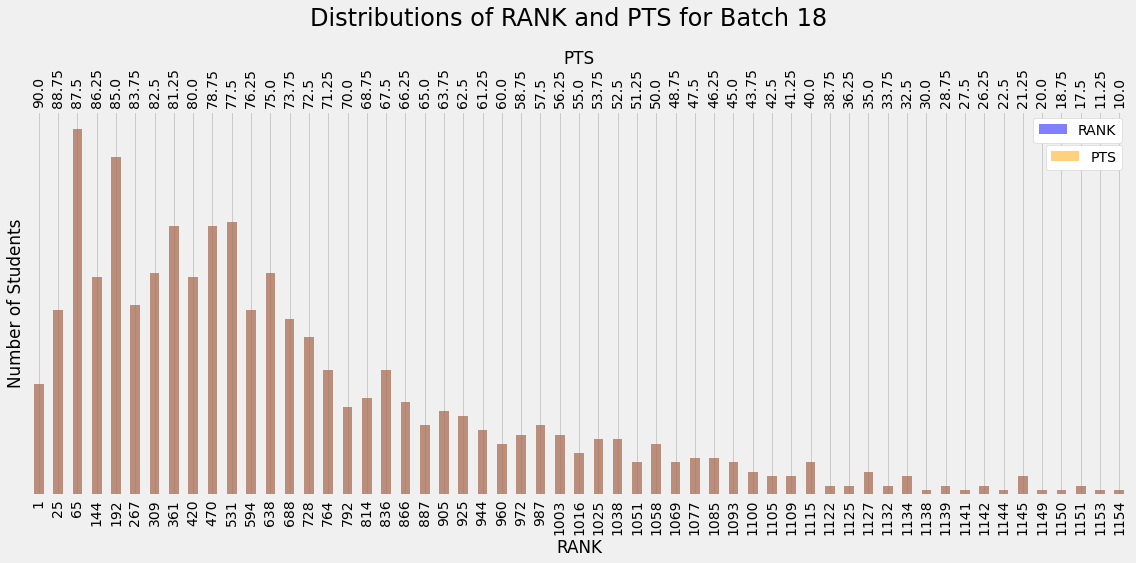

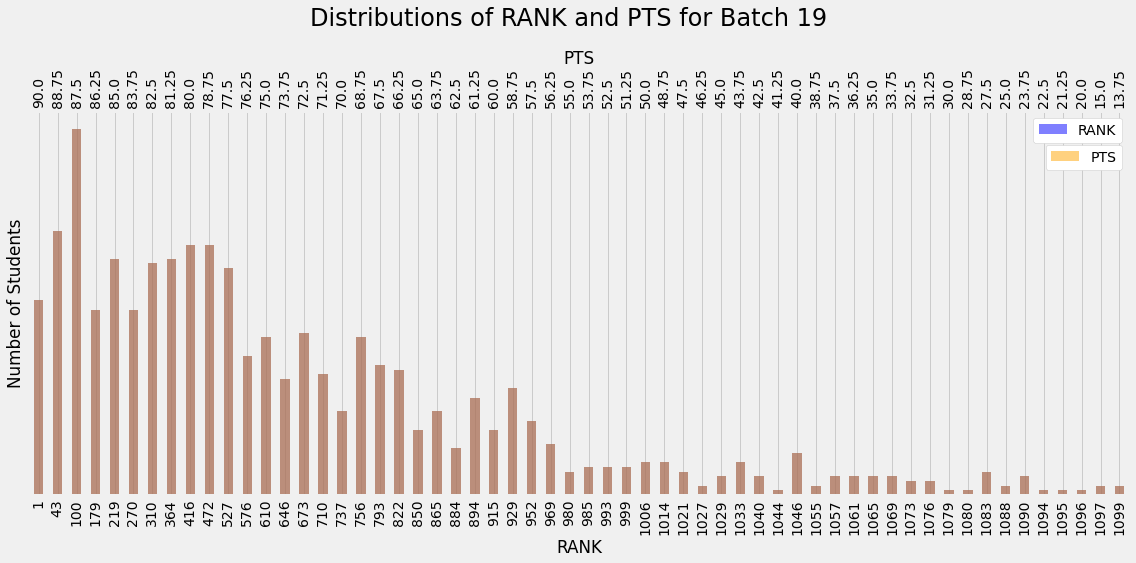

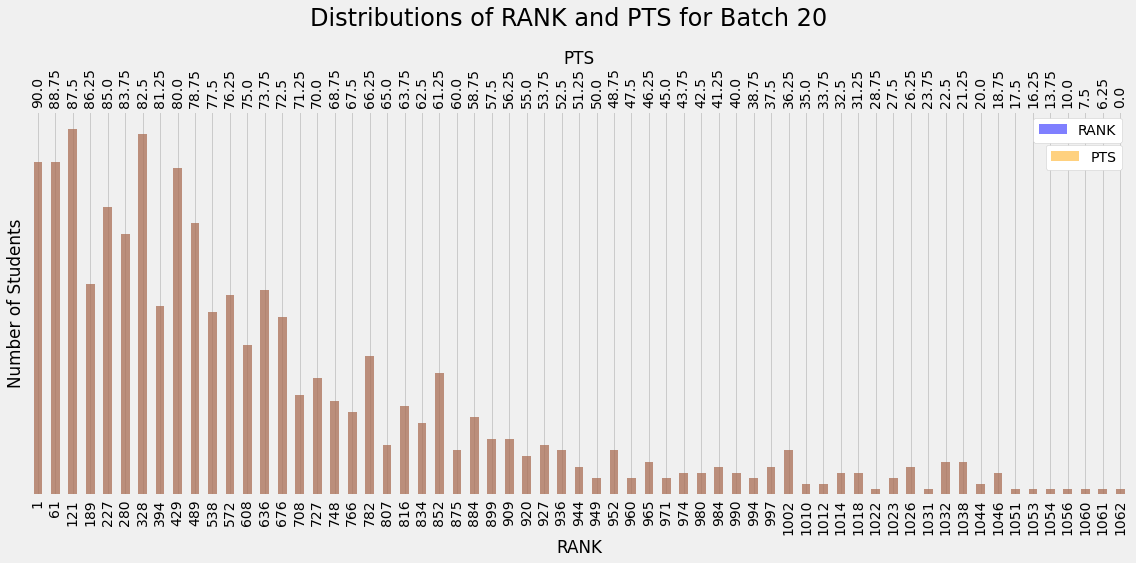

In [21]:
# plot twin histograms for 'RANK' and 'PTS'
twin_hist('RANK', 'PTS', asc1=True, asc2=False)

The distributions are identical within the same batch (any differences would have been visible as blue and orange colours as seen in the other histograms below). This confirms our understanding that students were ranked according to their University Admission Points. We keep the 'PTS' column and drop the 'Rank' column.

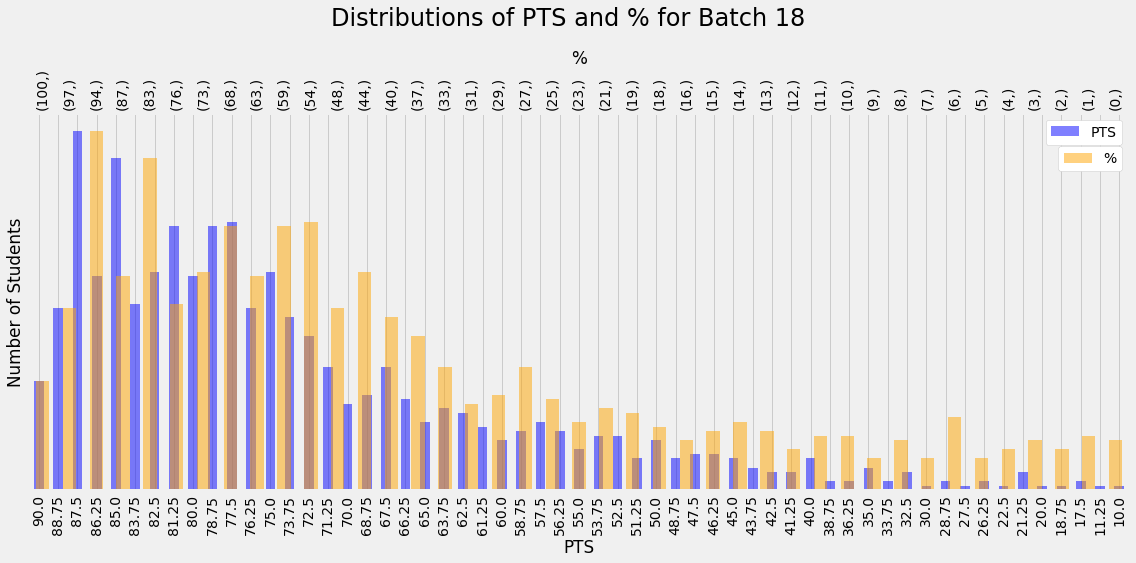

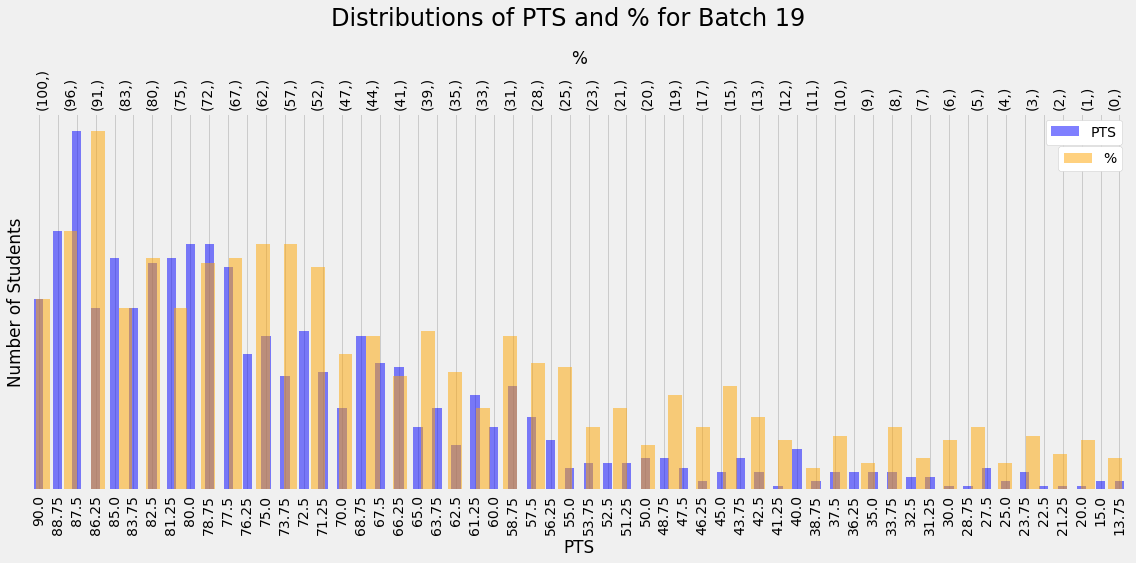

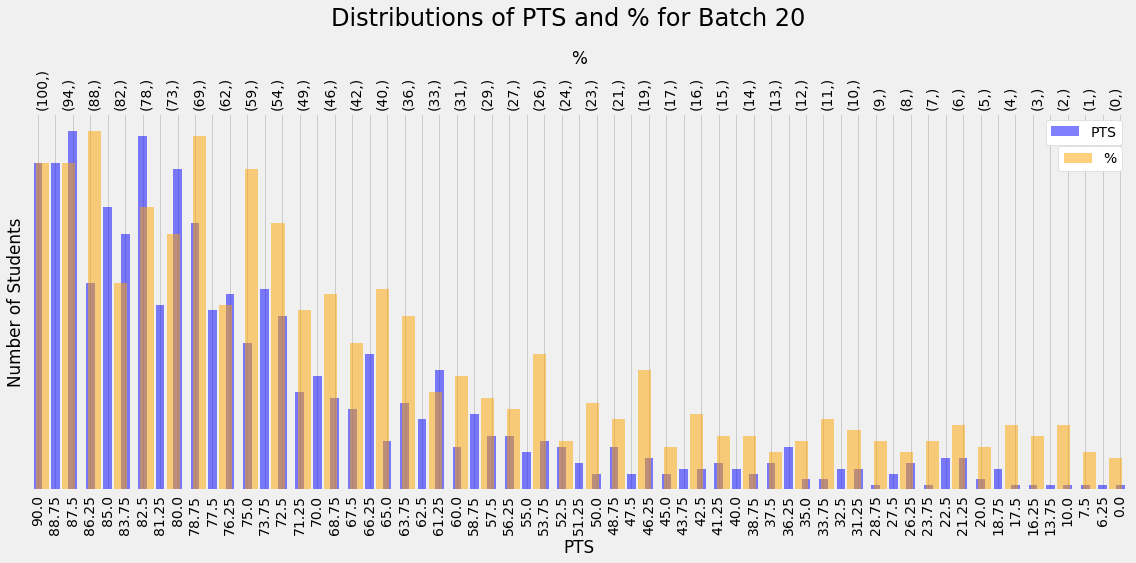

In [22]:
# plot twin histograms for 'PTS' and '%'
twin_hist('PTS', '%', asc1=False, asc2=False)

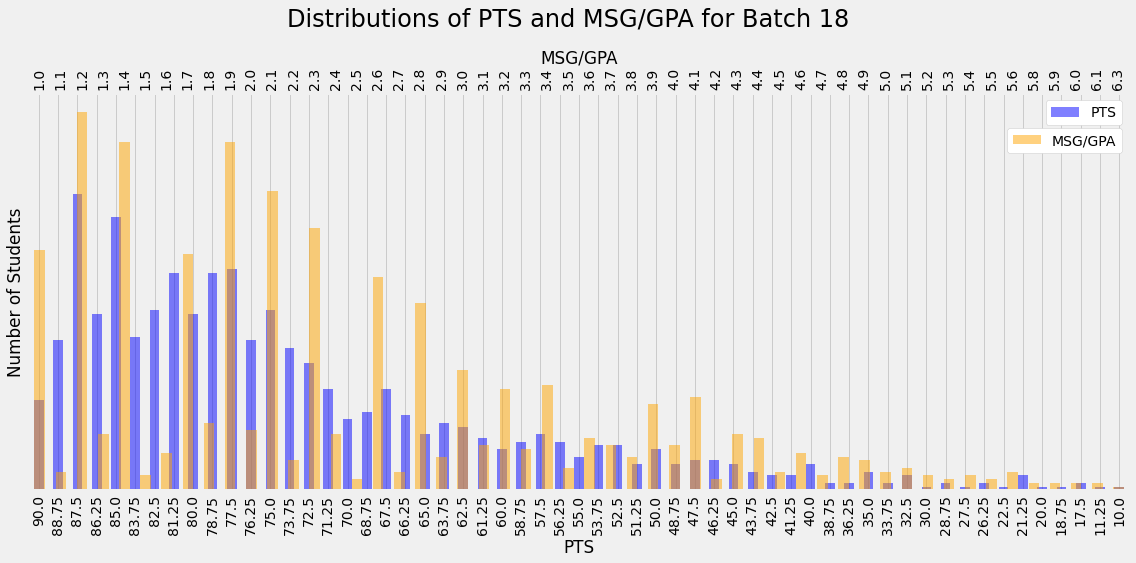

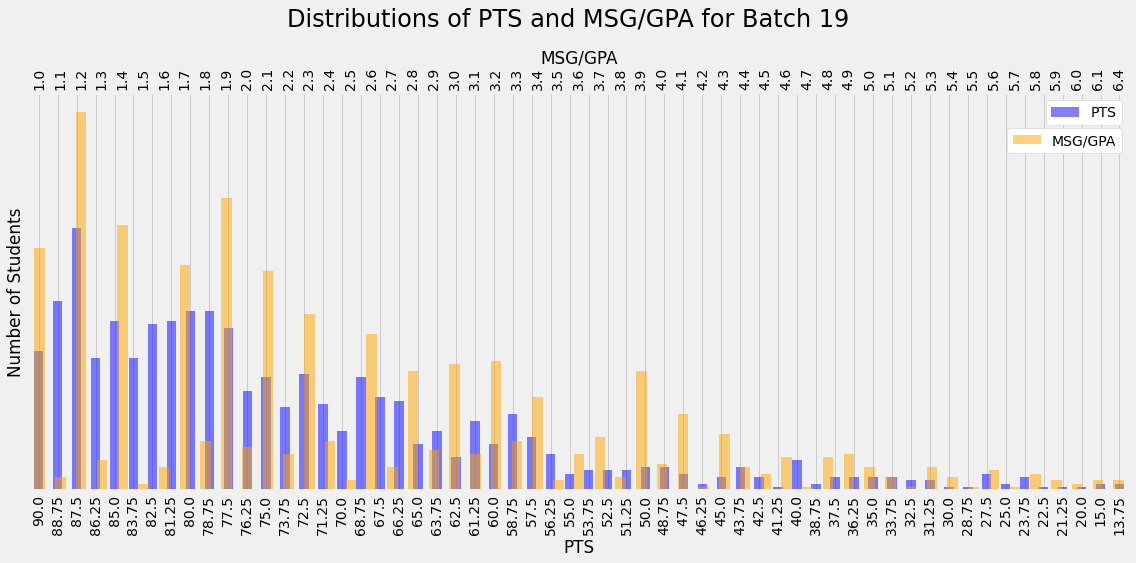

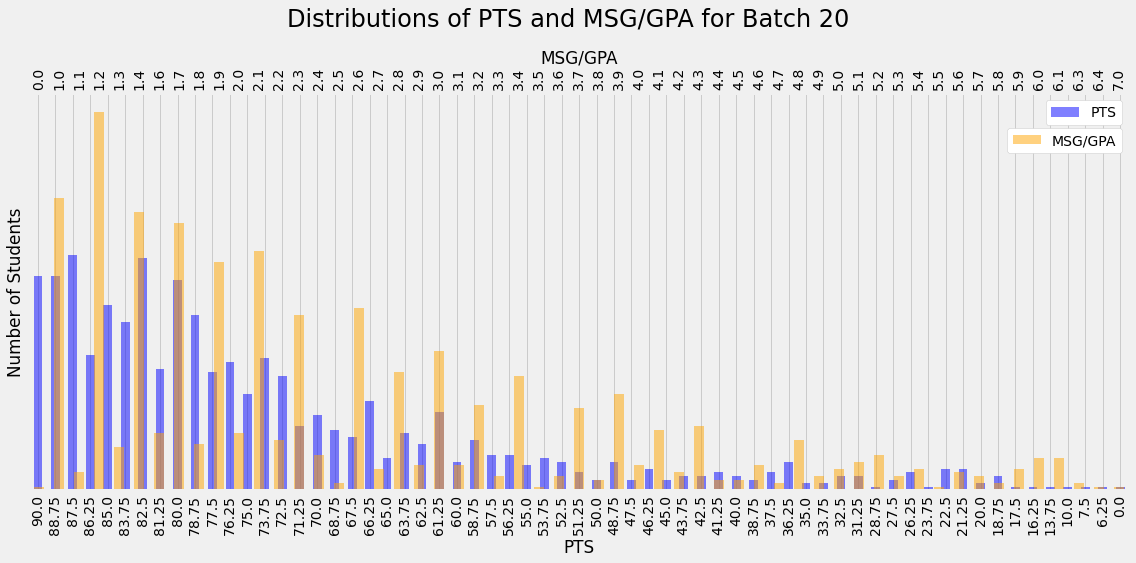

In [23]:
# plot twin histograms for 'PTS' and 'MSG/GPA'
twin_hist('PTS', 'MSG/GPA', asc1=False, asc2=True)

The distributions of University Admission Points, Percentile within Cohort and Mean Subject Grade are not the same within each batch, though they are quite similar across the batches. We keep all 3 columns for now.

## Check all non-grades related columns

In [24]:
# check proportion of empty cells in 'GENDER', 'REPEAT', 'INTAKE', 'SEC SCHOOL', 'NO OF CCA'
# these need to be imputed during preprocessing if they are to be used in modelling
non_grade = ['GENDER', 'REPEAT', 'INTAKE', 'SEC SCHOOL', 'NO OF CCA']
for i in range(3):
    print(f' Batch {batch[i]} '.center(20, "="))
    print(round(Prelim[i][0][non_grade].isna().sum()/Prelim[i][0].shape[0], 3))
    print()

===== Batch 18 =====
GENDER        0.000
REPEAT        0.996
INTAKE        0.000
SEC SCHOOL    0.000
NO OF CCA     0.000
dtype: float64

===== Batch 19 =====
GENDER        0.000
REPEAT        0.997
INTAKE        0.000
SEC SCHOOL    0.000
NO OF CCA     0.000
dtype: float64

===== Batch 20 =====
GENDER        0.000
REPEAT        0.989
INTAKE        0.000
SEC SCHOOL    0.000
NO OF CCA     0.000
dtype: float64



### Repeat Status
The number of repeat students are small but increased significantly in batch 20 (from less than 0.4% to 1.1%). This may be related to the COVID-19 situation as these students entered Junior College in 2020 and underwent many disruptions to their schooling such as the circuit breaker in April 2020. As the number of repeat students is very small (low variance), we drop the column.

### Gender

In [25]:
# check proportion value counts for Gender
for i in range(3):
    print(f' Batch {batch[i]} '.center(20, "="))
    print(round(Prelim[i][0].value_counts('GENDER', normalize=True), 2))
    print()

===== Batch 18 =====
GENDER
F    0.51
M    0.49
dtype: float64

===== Batch 19 =====
GENDER
F    0.51
M    0.49
dtype: float64

===== Batch 20 =====
GENDER
F    0.53
M    0.47
dtype: float64



### Intake Type

In [26]:
# check proportion value counts for Intake Type
for i in range(3):
    print(f' Batch {batch[i]} '.center(36, "="))
    print(round(Prelim[i][0].value_counts('INTAKE', normalize=True), 2))
    print()

============= Batch 18 =============
INTAKE
IP (X)                    0.32
IP (Y)                    0.31
JAE Ordinary Admission    0.30
DSA (CCA)                 0.04
DSA                       0.02
Appeals (Academic)        0.01
dtype: float64

============= Batch 19 =============
INTAKE
IP (X)                    0.34
IP (Y)                    0.33
JAE Ordinary Admission    0.26
DSA (CCA)                 0.04
DSA                       0.02
Appeals (Academic)        0.01
dtype: float64

============= Batch 20 =============
INTAKE
IP (X)                    0.35
IP (Y)                    0.34
JAE Ordinary Admission    0.25
DSA (CCA)                 0.04
DSA                       0.02
Appeals (Academic)        0.00
dtype: float64



There is only less than 0.5% Appeals (Academic) in Batch 20. As the numbers are small and may stay small in future, we wish to avoid having such a category for our production model. This group is actually almost identical to the JAE Ordinary Admission group as they enter based on their O Level L1R5 score being at the cut-off score, so we merge them together. 

In [27]:
for i in range(3):
    Prelim[i][0]['INTAKE'].replace({'Appeals (Academic)': 'JAE Ordinary Admission'}, inplace=True)

### Secondary Schools

In [28]:
# check proportion value counts for Secondary School
for i in range(3):
    print(f' Batch {batch[i]} '.center(40, "="))
    print(np.round(Prelim[i][0].value_counts('SEC SCHOOL', normalize=True).values, 2))
    print()

=============== Batch 18 ===============
[0.33 0.31 0.06 0.03 0.03 0.03 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]

=============== Batch 19 ===============
[0.34 0.33 0.05 0.03 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]

=============== Batch 20 ===============
[0.36 0.34 0.05 0.03 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   

As there are many secondary schools that account for less than 0.5% of the cohort, we do not wish to overtrain our model with such fine details. For example, a particular secondary school might have had a brilliant student who did extremely well but this does not guarantee that future students from the same school will also perform as well. Hence we group schools with small number of students into a combined category.

We use the intersection of schools that make up at least 1% of the cohort for all three batches and keep this list, and then combine the rest of the schools into a new category 'minority schools'.

In [29]:
# create set of common schools
ss_18 = Prelim[0][0].value_counts('SEC SCHOOL', normalize=True)
ss_19 = Prelim[1][0].value_counts('SEC SCHOOL', normalize=True)
ss_20 = Prelim[2][0].value_counts('SEC SCHOOL', normalize=True)

common_schools = set(ss_18[ss_18.values > 0.01].index).\
    intersection(ss_19[ss_19.values > 0.01].index).\
    intersection(ss_20[ss_20.values > 0.01].index)

# merge other schools into combined category '_Minority_Sch'
for i in range(3):
    Prelim[i][0]['SEC SCHOOL'] = Prelim[i][0]['SEC SCHOOL'].map(
        lambda sch: sch if sch in common_schools else "_Minority_Sch")

In [30]:
# check proportion value counts for Secondary School
for i in range(3):
    print(f' Batch {batch[i]} '.center(40, "="))
    print(np.round(Prelim[i][0].value_counts('SEC SCHOOL', normalize=True).values, 2))
    print()

=============== Batch 18 ===============
[0.33 0.31 0.18 0.06 0.03 0.03 0.02 0.02 0.01]

=============== Batch 19 ===============
[0.34 0.33 0.17 0.05 0.03 0.02 0.02 0.02 0.01]

=============== Batch 20 ===============
[0.36 0.34 0.15 0.05 0.03 0.02 0.02 0.02 0.02]



### Number of CCA

In [31]:
# check proportion value counts for CCA
for i in range(3):
    print(f' Batch {batch[i]} '.center(24, "="))
    print(round(Prelim[i][0].value_counts('NO OF CCA', normalize=True).sort_index(), 2))
    print()

======= Batch 18 =======
NO OF CCA
0    0.02
1    0.80
2    0.18
3    0.01
dtype: float64

======= Batch 19 =======
NO OF CCA
0    0.02
1    0.78
2    0.20
3    0.01
dtype: float64

======= Batch 20 =======
NO OF CCA
0    0.01
1    0.84
2    0.14
3    0.00
dtype: float64



## Clean up subjects

In [32]:
# check column names of each batch for list of subjects
for i in range(3):
    print(f' Batch {batch[i]} '.center(40, "="))
    print(Prelim[i][0].columns)
    print()

=============== Batch 18 ===============
Index(['GENDER', 'PSLE', 'REPEAT', 'INTAKE', 'SEC SCHOOL', 'PW', 'GP', 'KI',
       'KI (A)', 'MA2', 'FM2', 'CP2', 'PH2', 'CH2', 'BY2', 'EL2', 'EL2 (A)',
       'ELL2', 'EC2', 'EC2 (A)', 'EH2', 'EH2 (A)', 'EG2', 'EG2 (A)', 'S1_2',
       'S2_2', 'S3_2', 'S4_2', 'S5_2', 'FR2', 'GM2', 'JP2', 'SP2', 'MA1',
       'PH1', 'CH1', 'BY1', 'EL1', 'EC1', 'EH1', 'EG1', 'MA3-MOE', 'PH3-MOE',
       'CH3-MOE', 'BY3-MOE', 'EC3-MOE', 'S1_3-MOE', 'PW.1', 'MTL', 'P/F',
       'RANK', '%', 'MSG/GPA', 'PTS', 'NO OF CCA', 'S2_3-MOE'],
      dtype='object')

=============== Batch 19 ===============
Index(['GENDER', 'PSLE', 'REPEAT', 'INTAKE', 'SEC SCHOOL', 'PW', 'KI', 'GP',
       'KI (A)', 'MA2', 'FM2', 'CP2', 'PH2', 'CH2', 'BY2', 'EL2', 'EL2 (A)',
       'ELL2', 'EC2', 'EC2 (A)', 'EH2', 'EH2 (A)', 'EG2', 'EG2 (A)', 'S1_2',
       'S2_2', 'S3_2', 'S4_2', 'S5_2', 'FR2', 'GM2', 'SP2', 'MA1', 'PH1',
       'CH1', 'EL1', 'EC1', 'EH1', 'EG1', 'MA3-MOE', 'PH3-MOE', 'CH3-

Some subjects have an additional version tagged with '(A)', which are essentially the same subjects (students take the same major exams in school) but are in a special programme. We merge those subjects into the same column.

In [33]:
# merge columns with (A) for Prelim Grades datasets
subj_A = ['KI', 'EL2', 'EC2', 'EH2', 'EG2']
for i in range(3):
    for subj in subj_A:
        Prelim[i][0][subj].fillna(Prelim[i][0][subj+' (A)'], inplace=True)

Students must take either General Paper (GP) or Knowledge and Inquiry (KI). We merge these 2 columns as well.

In [34]:
# merge 'GP' and 'KI'
for i in range(3):
    Prelim[i][0]['GP'].fillna(Prelim[i][0]['KI'], inplace=True) 
    Prelim[i][0].rename(columns={'GP': 'GP/KI'}, inplace=True)

In [35]:
# look for subjects with small candidature where proportion of missing values is close to 1
for i in range(3):
    print(f' Batch {batch[i]} '.center(40, "="))
    display(round(Prelim[i][0].isna().sum() / Prelim[i][0].shape[0], 2))

=============== Batch 18 ===============


GENDER        0.00
PSLE          0.00
REPEAT        1.00
INTAKE        0.00
SEC SCHOOL    0.00
PW            0.00
GP/KI         0.00
KI            0.96
KI (A)        0.99
MA2           0.00
FM2           0.99
CP2           0.95
PH2           0.55
CH2           0.18
BY2           0.60
EL2           0.91
EL2 (A)       0.96
ELL2          0.99
EC2           0.28
EC2 (A)       0.97
EH2           0.93
EH2 (A)       0.98
EG2           0.94
EG2 (A)       0.99
S1_2          0.99
S2_2          1.00
S3_2          0.97
S4_2          0.93
S5_2          0.99
FR2           1.00
GM2           0.99
JP2           1.00
SP2           1.00
MA1           1.00
PH1           1.00
CH1           0.98
BY1           1.00
EL1           0.99
EC1           0.89
EH1           1.00
EG1           1.00
MA3-MOE       0.97
PH3-MOE       0.99
CH3-MOE       0.95
BY3-MOE       0.98
EC3-MOE       0.98
S1_3-MOE      0.99
PW.1          0.00
MTL           0.00
P/F           0.00
RANK          0.00
%             0.00
MSG/GPA     

=============== Batch 19 ===============


GENDER        0.00
PSLE          0.00
REPEAT        1.00
INTAKE        0.00
SEC SCHOOL    0.00
PW            0.00
KI            0.97
GP/KI         0.00
KI (A)        0.99
MA2           0.00
FM2           0.98
CP2           0.95
PH2           0.49
CH2           0.21
BY2           0.67
EL2           0.91
EL2 (A)       0.96
ELL2          0.98
EC2           0.23
EC2 (A)       0.97
EH2           0.92
EH2 (A)       0.98
EG2           0.96
EG2 (A)       0.99
S1_2          0.99
S2_2          0.99
S3_2          0.96
S4_2          0.94
S5_2          0.99
FR2           1.00
GM2           1.00
SP2           1.00
MA1           1.00
PH1           0.99
CH1           0.97
EL1           0.99
EC1           0.92
EH1           1.00
EG1           0.99
MA3-MOE       0.96
PH3-MOE       0.96
CH3-MOE       0.92
BY3-MOE       0.97
EC3-MOE       0.98
S1_3-MOE      0.99
S2_3-MOE      1.00
PW.1          0.00
MTL           0.00
P/F           0.00
RANK          0.00
%             0.00
MSG/GPA       0.00
PTS         

=============== Batch 20 ===============


GENDER        0.00
PSLE          0.00
REPEAT        0.99
INTAKE        0.00
SEC SCHOOL    0.00
PW            0.00
KI            0.96
GP/KI         0.00
KI (A)        0.99
MA2           0.00
FM2           0.99
CP2           0.94
PH2           0.51
CH2           0.17
BY2           0.65
EL2           0.90
EL2 (A)       0.96
ELL2          0.99
EC2           0.24
EC2 (A)       0.97
EH2           0.93
EH2 (A)       0.98
EG2           0.96
EG2 (A)       1.00
S1_2          0.99
S2_2          0.99
S3_2          0.96
S4_2          0.93
S5_2          0.99
FR2           1.00
GM2           0.99
JP2           1.00
SP2           1.00
MA1           1.00
PH1           1.00
CH1           0.99
EL1           0.99
EC1           0.95
EG1           1.00
MA3-MOE       0.97
PH3-MOE       0.97
CH3-MOE       0.92
BY3-MOE       0.98
EC3-MOE       0.98
S1_3-MOE      0.99
S2_3-MOE      1.00
PW.1          0.00
MTL           0.00
P/F           0.00
RANK          0.00
%             0.00
MSG/GPA       0.00
PTS         

In [36]:
# classify subjects to analyze in groups

# large candidature subjects
subj_large = ['GP/KI', 'MA2', 'PH2', 'CH2', 'BY2', 'EC2', 'PW.1', 'MTL']

# small candidature H2 subjects
subj_small = ['FM2', 'CP2', 'EL2', 'ELL2', 'EH2', 'EG2', 'S1_2', 'S2_2', 'S3_2', 'S4_2', 'S5_2', 
              'FR2', 'GM2', 'JP2', 'SP2']

# H1 subjects, exclude MA1 as MA2 students cannot take MA1
subj_H1 = ['PH1', 'CH1', 'BY1', 'EL1', 'EC1', 'EG1', 'EH1']

# H3 subjects with different grading scheme
subj_H3 = ['MA3-MOE', 'PH3-MOE', 'CH3-MOE', 'BY3-MOE', 'EC3-MOE', 'S1_3-MOE', 'S2_3-MOE']

subj_all = subj_large + subj_small + subj_H1 + subj_H3

In [37]:
# explore unique values in Grades dataset for Batch 18
for subj in subj_all:
    print(subj, Prelim[0][0][subj].unique())

GP/KI ['B' 'C' 'D' 'A' 'S' 'E' 'MC' 'EX']
MA2 ['A' 'B' 'C' 'S' 'E' 'D' 'U' 'MC']
PH2 ['B' 'S' 'D' nan 'C' 'A' 'U' 'E' 'MC']
CH2 ['A' 'E' 'B' 'C' 'D' nan 'S' 'U' 'MC']
BY2 [nan 'A' 'B' 'E' 'C' 'MC' 'D' 'U' 'S']
EC2 ['B' 'E' nan 'C' 'D' 'A' 'U' 'S' 'MC' 'EX']
PW.1 ['A' 'B']
MTL ['A' 'B' 'D' 'C' 'E' 'S' nan]
FM2 [nan 'A' 'B' 'E']
CP2 [nan 'B' 'D' 'A' 'E' 'S' 'C']
EL2 [nan 'D' 'B' 'C' 'A']
ELL2 [nan 'C' 'D' 'B' 'U' 'E']
EH2 [nan 'E' 'B' 'A' 'D' 'C']
EG2 [nan 'C' 'B' 'D' 'E' 'A' 'S' 'EX']
S1_2 [nan 'B' 'A']
S2_2 [nan 'A' 'B']
S3_2 [nan 'A' 'B' 'D' 'C']
S4_2 [nan 'B' 'A' 'D' 'C' 'S' 'MC' 'E']
S5_2 [nan 'B' 'A']
FR2 [nan 'B' 'A']
GM2 [nan 'A' 'MC' 'B']
JP2 [nan 'B' 'A']
SP2 [nan 'A']
PH1 [nan 'C' 'D' 'B']
CH1 [nan 'A' 'C' 'E' 'U' 'B' 'D' 'MC']
BY1 [nan 'B' 'A']
EL1 [nan 'C' 'B' 'D' 'A']
EC1 [nan 'B' 'C' 'A' 'D' 'E' 'S']
EG1 [nan 'B' 'A']
EH1 [nan 'MC']
MA3-MOE [nan 'PA' 'ME' 'DI' 'UC']
PH3-MOE [nan 'ME' 'UC' 'DI']
CH3-MOE [nan 'ME' 'PA' 'UC' 'DI']
BY3-MOE [nan 'ME' 'PA' 'DI']
EC3-MOE [nan 'DI

In [38]:
# change 'EX' and 'MC' to 'missed' for all Prelim Grades datasets
for i in range(3):
    for subj in subj_all:
        Prelim[i][0][subj].replace({'EX': 'missed', 'MC': 'missed'}, inplace=True)

In [39]:
# function for plotting grade distributions
def plot_subj(subj_list, title):
    df = pd.DataFrame()
    for i in range(3):
        df_add = Prelim[i][0][subj_list].melt(var_name='Subject', value_name='Grade')
        df_add['Batch'] = i + 18
        df = pd.concat([df, df_add])        
    df.reset_index(inplace=True)

    hist = sns.displot(df.sort_values(['Subject', 'Grade']), x='Grade', col='Subject', 
                       col_wrap=4, hue='Batch', palette='Dark2')
    hist.fig.suptitle(f'Distribution of Prelim Grades for '+title, fontsize=24)
    sns.move_legend(hist, 'upper right')
    
    #HIDDEN y count values due to confidentiality
    hist.set(yticklabels=[])
    
    plt.tight_layout();

## Subjects with Large Candidature

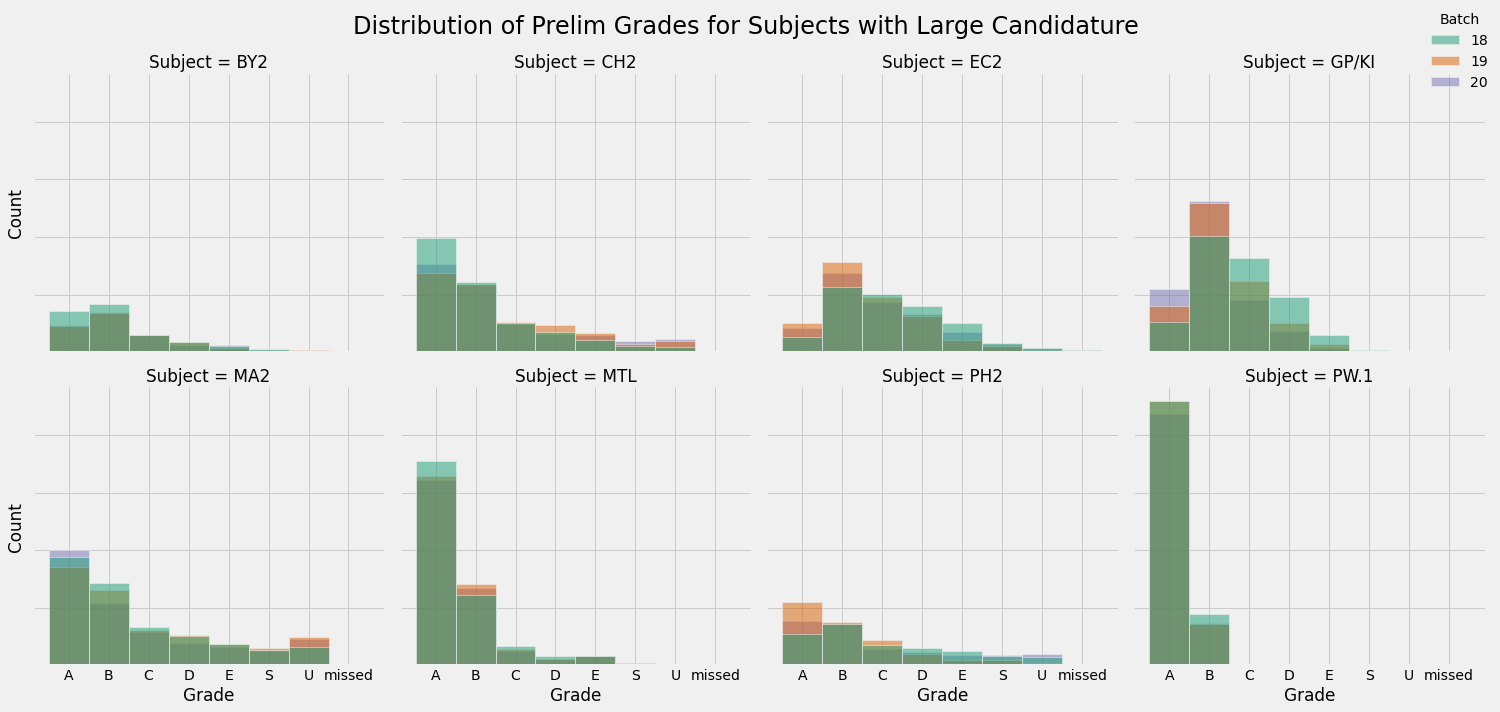

In [40]:
# plot subjects with large candidature
plot_subj(subj_large, "Subjects with Large Candidature")

The distributions are quite consistent across the 3 batches for subjects with large candidature.

## Subjects with Small Candidature
Some subjects have really small candidatures which we will wish to merge. In particular, we want to find a group for 'JP2' that did not appear in Batch 19.

In [41]:
# check number of students taking each of the small subjects
for i in range(3):
    print(f' Batch {batch[i]} '.center(40, "="))
    display(Prelim[i][0][subj_small].notna().sum())

=============== Batch 18 ===============


FM2      12
CP2      53
EL2     103
ELL2      9
EH2      74
EG2      61
S1_2     11
S2_2      4
S3_2     32
S4_2     73
S5_2      7
FR2       2
GM2       6
JP2       2
SP2       2
dtype: int64

=============== Batch 19 ===============


FM2      22
CP2      57
EL2     101
ELL2     16
EH2      81
EG2      46
S1_2     10
S2_2      8
S3_2     38
S4_2     69
S5_2      9
FR2       1
GM2       5
JP2       0
SP2       2
dtype: int64

=============== Batch 20 ===============


FM2      14
CP2      58
EL2     100
ELL2     15
EH2      71
EG2      41
S1_2     15
S2_2      6
S3_2     38
S4_2     74
S5_2      9
FR2       5
GM2       8
JP2       3
SP2       2
dtype: int64

By nature of the subjects, the foreign language subjects are most similar and each student can at most take 1 foreign language. We decide to combine French, German, Spanish and Japanese into a new category 'Foreign_Lang'.

In [42]:
# combine 'FR2','GM2','SP2','JP2' into new column 'Foreign_Lang'
for i in range(3):
    Prelim[i][0]['Foreign_Lang'] = np.nan
    for lang in ['FR2','GM2','SP2','JP2']:
        Prelim[i][0]['Foreign_Lang'].fillna(Prelim[i][0][lang], inplace=True)

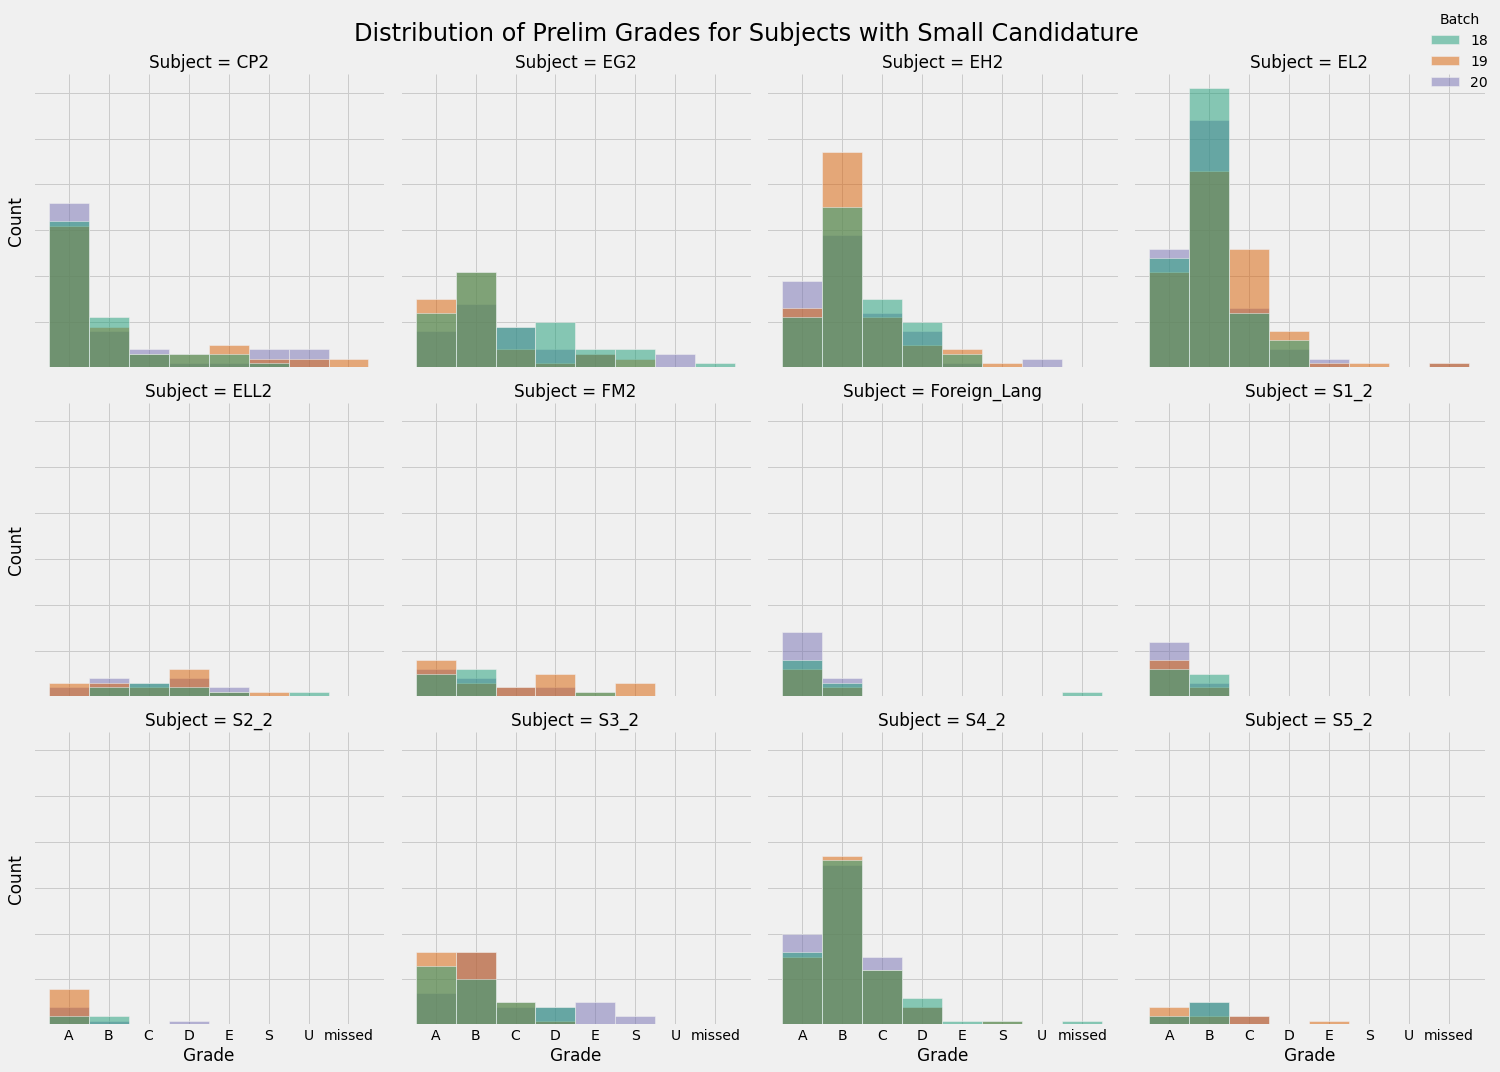

In [43]:
# update list of subjects with small candidature
subj_small = ['FM2', 'CP2', 'EL2', 'ELL2', 'EH2', 'EG2', 'S1_2', 'S2_2', 'S3_2', 'S4_2', 'S5_2', 'Foreign_Lang']

# plot subjects with small candidature
plot_subj(subj_small, "Subjects with Small Candidature")

There is more variation in the distribution across the batches for subjects with small candidature. 'S2_2' has the smallest candidature after merging the foreign languages, but we decided not to merge this with any other subject as this subject is no longer offered in this school from batch 21 onwards.

## H1 Subjects
Each student can only read one H1 content subject, so we can consider merging any of these into a single column. In particular, we wish to find a group for 'BY1' and 'EH1'.

In [44]:
# check number of students taking each of the H1 subjects
for i in range(3):
    print(f' Batch {batch[i]} '.center(40, "="))
    display(Prelim[i][0][subj_H1].notna().sum())

=============== Batch 18 ===============


PH1      3
CH1     24
BY1      2
EL1     14
EC1    120
EG1      2
EH1      1
dtype: int64

=============== Batch 19 ===============


PH1    10
CH1    27
BY1     0
EL1     7
EC1    84
EG1     9
EH1     1
dtype: int64

=============== Batch 20 ===============


PH1     3
CH1    10
BY1     0
EL1     9
EC1    53
EG1     4
EH1     0
dtype: int64

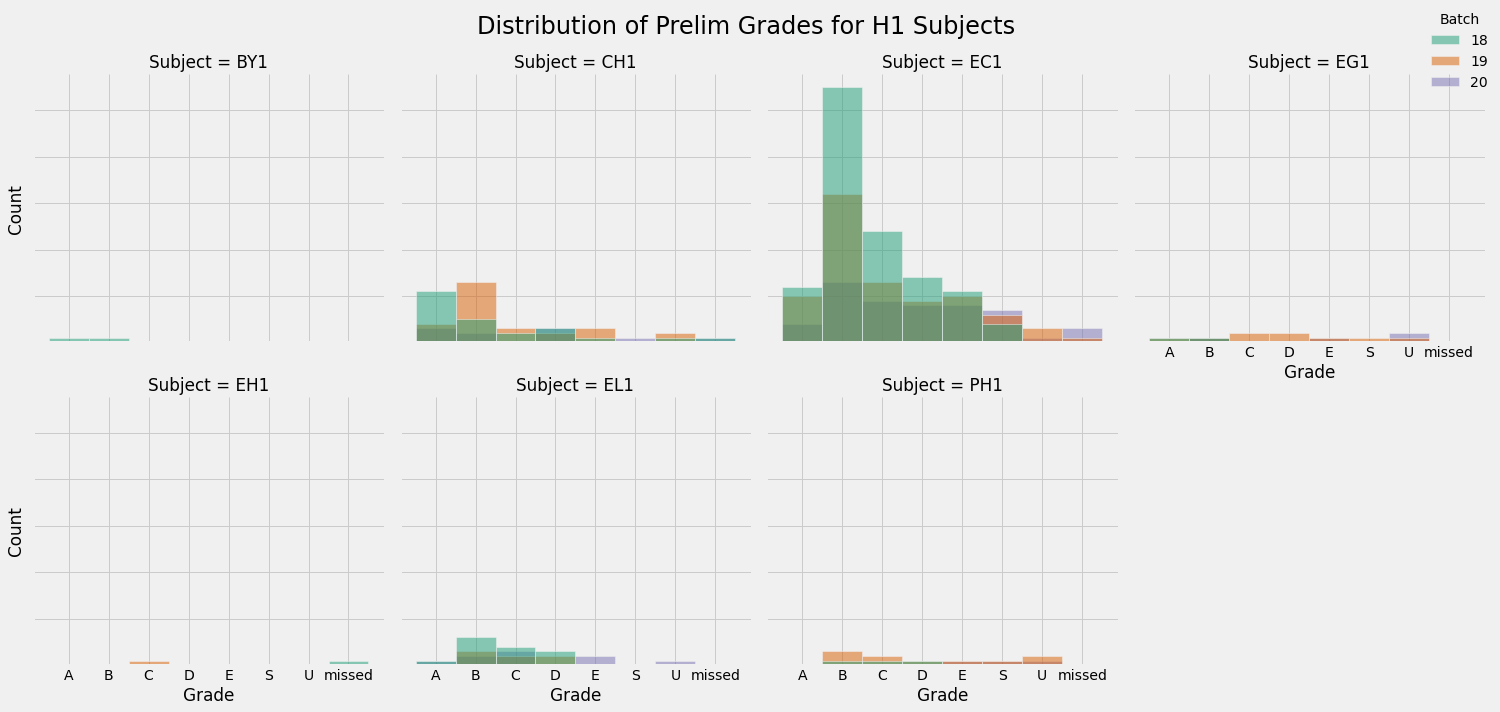

In [45]:
# plot H1 subjects
plot_subj(subj_H1, "H1 Subjects")

H1 Economics ('EC1') has the largest candidature but in batch 20 it has decreased to 53 only. As the numbers are small, we decide to merge all H1 subjects into one column.

In [46]:
# combine all H1 subjects into new column 'H1'
for i in range(3):
    Prelim[i][0]['H1'] = np.nan
    for h1 in subj_H1:
        Prelim[i][0]['H1'].fillna(Prelim[i][0][h1], inplace=True)

## H3 Subjects
Most students can only take at most one H3 subject. On the very rare occasions where students are allowed 2 H3 subjects (usually need approval from MOE), these students typically choose to take a university H3 and not both MOE H3. We consider merging some columns. In particular, we wish to find a group for 'S2_3-MOE'.

In [47]:
# check number of students taking each of the H3 subjects
for i in range(3):
    print(f' Batch {batch[i]} '.center(40, "="))
    display(Prelim[i][0][subj_H3].notna().sum())

=============== Batch 18 ===============


MA3-MOE     34
PH3-MOE     14
CH3-MOE     58
BY3-MOE     22
EC3-MOE     23
S1_3-MOE    11
S2_3-MOE     0
dtype: int64

=============== Batch 19 ===============


MA3-MOE     43
PH3-MOE     40
CH3-MOE     86
BY3-MOE     37
EC3-MOE     21
S1_3-MOE    10
S2_3-MOE     3
dtype: int64

=============== Batch 20 ===============


MA3-MOE     32
PH3-MOE     35
CH3-MOE     84
BY3-MOE     25
EC3-MOE     22
S1_3-MOE    14
S2_3-MOE     1
dtype: int64

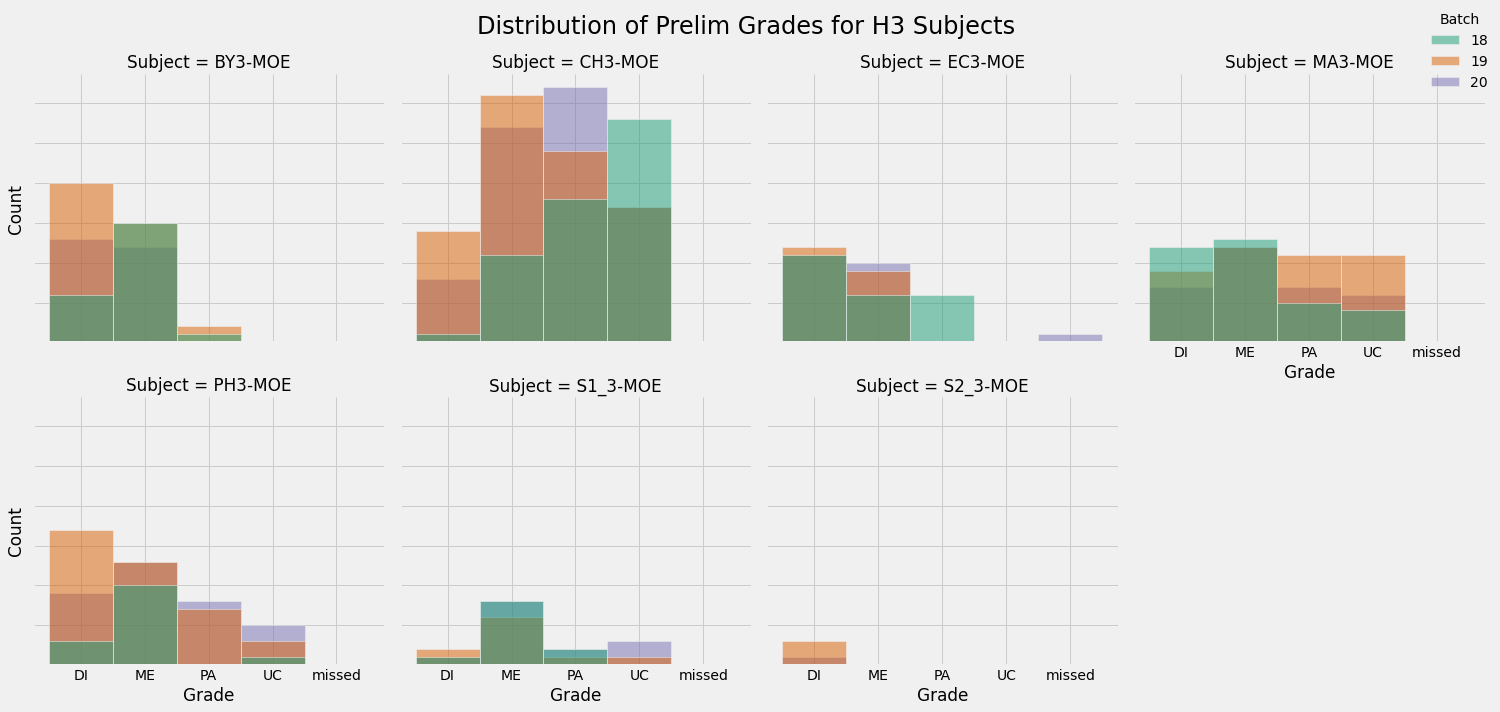

In [48]:
# plot H3 subjects
plot_subj(subj_H3, "H3 Subjects")

We decide to merge all H3 subjects into one column as these are all academically strong students who meet the criteria to take H3 in JC2.

In [49]:
# combine all H3 subjects into new column 'H3'
for i in range(3):
    Prelim[i][0]['H3'] = np.nan
    for h3 in subj_H3:
        Prelim[i][0]['H3'].fillna(Prelim[i][0][h3], inplace=True)

## Finding columns with high correlation to Target
We map the grades to numbers so that we can calculate the correlation coefficients, giving the smallest number 1 for the best grade of A or Distinction.

For H1, we handle the missing values by assigning them to 0 as these students did not have to downgrade to H1 and take the more challenging syllabus of H2, so they are likely better than students who scored A (or 1) in the corresponding H1 subject.

For H3, we do it the other way round, assiging the largest number of 5 as H3 is an additional subject taken by academically strong students, so students who take H3, regardless of their Prelim grade in the subject, are generally better than those who do not.

In [50]:
# check column names
Prelim[0][0].columns

Index(['GENDER', 'PSLE', 'REPEAT', 'INTAKE', 'SEC SCHOOL', 'PW', 'GP/KI', 'KI',
       'KI (A)', 'MA2', 'FM2', 'CP2', 'PH2', 'CH2', 'BY2', 'EL2', 'EL2 (A)',
       'ELL2', 'EC2', 'EC2 (A)', 'EH2', 'EH2 (A)', 'EG2', 'EG2 (A)', 'S1_2',
       'S2_2', 'S3_2', 'S4_2', 'S5_2', 'FR2', 'GM2', 'JP2', 'SP2', 'MA1',
       'PH1', 'CH1', 'BY1', 'EL1', 'EC1', 'EH1', 'EG1', 'MA3-MOE', 'PH3-MOE',
       'CH3-MOE', 'BY3-MOE', 'EC3-MOE', 'S1_3-MOE', 'PW.1', 'MTL', 'P/F',
       'RANK', '%', 'MSG/GPA', 'PTS', 'NO OF CCA', 'S2_3-MOE', 'Foreign_Lang',
       'H1', 'H3'],
      dtype='object')

In [51]:
# create list of features
features_subj = ['GP/KI', 'MA2', 'FM2', 'CP2', 'PH2', 'CH2', 'BY2', 'EL2', 'ELL2', 
                 'EC2', 'EH2', 'EG2', 'S1_2', 'S2_2', 'S3_2', 'S4_2', 'S5_2',
                 'PW.1', 'MTL', 'Foreign_Lang'
                ]
features_test = features_subj + ['H1', 'H3', '%', 'MSG/GPA', 'PTS', 'NO OF CCA']

In [52]:
# create dataframes with prelim grades and targets for Batches 18 and 19
test_18 = pd.concat([Prelim[0][0][features_test], y_18['Target']], axis=1)
test_19 = pd.concat([Prelim[1][0][features_test], y_19['Target']], axis=1)

# map Prelim grades to numbers, changing 'missed' to NaN for calculating correlation
grade_dict = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'S': 6, 'U': 7, 
              'missed': np.nan, np.nan: np.nan
             }

grade_dict_H1 = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'S': 6, 'U': 7, 
                 'missed': np.nan, np.nan: 0
                }

grade_dict_H3 = {'DI': 1, 'ME': 2, 'PA': 3, 'UC': 4, 'missed': np.nan, np.nan: 5}

for subj in features_subj:
    test_18[subj].replace(grade_dict, inplace=True)
    test_19[subj].replace(grade_dict, inplace=True)
    
test_18['H1'].replace(grade_dict_H1, inplace=True)
test_19['H1'].replace(grade_dict_H1, inplace=True)
test_18['H3'].replace(grade_dict_H3, inplace=True)
test_19['H3'].replace(grade_dict_H3, inplace=True)

# features ranked by magnitude of correlation to Target
corr_18 = test_18.corr().tail(1).T.sort_values('Target', key=abs)
corr_19 = test_19.corr().tail(1).T.sort_values('Target', key=abs)
corr_18.rename(columns={'Target': 'Correlation with Target'}, inplace=True)
corr_19.rename(columns={'Target': 'Correlation with Target'}, inplace=True)

In [53]:
# function for plotting correlation
def plot_bar(df, batch = 18):
    df['pos'] = df['Correlation with Target'] > 0
    df['Correlation with Target'].plot(kind='barh', color=df['pos'].map({True: 'g', False: 'r'}))
    plt.title(f'Correlation Coefficients of Features with Target for Batch {batch}');

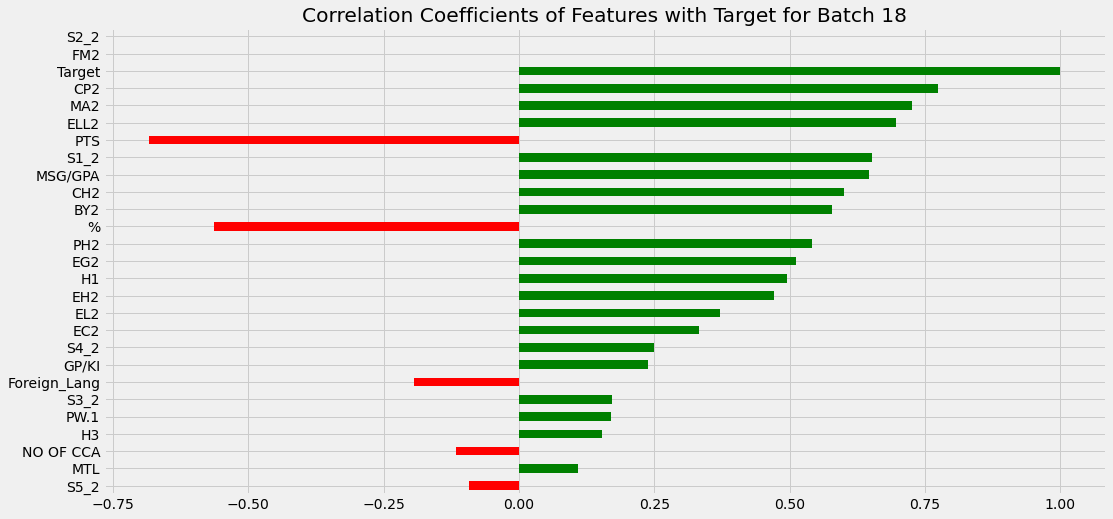

In [54]:
# plot of correlation for Batch 18
plot_bar(corr_18, 18)

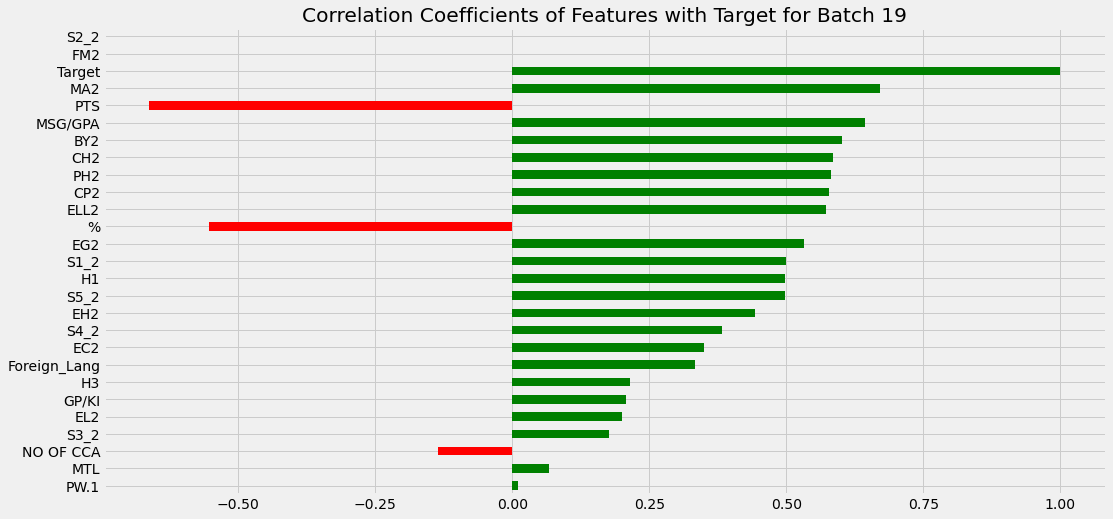

In [55]:
# plot of correlation for Batch 19
plot_bar(corr_19, 19)

In [56]:
# investigate why correlation with 'FM2' and 'S2_2' is NaN
print(' FM2 '.center(25, "="))
print('Batch 18')
print(test_18[test_18['FM2'].notna()][['FM2','Target']].value_counts())
print()
print('Batch 19')
print(test_19[test_19['FM2'].notna()][['FM2','Target']].value_counts())
print()
print(' MP2 '.center(25, "="))
print('Batch 18')
print(test_18[test_18['S2_2'].notna()][['S2_2','Target']].value_counts())
print()
print('Batch 19')
print(test_19[test_19['S2_2'].notna()][['S2_2','Target']].value_counts())
print()

========== FM2 ==========
Batch 18
FM2  Target
2.0  0         6
1.0  0         5
5.0  0         1
dtype: int64

Batch 19
FM2  Target
1.0  0         8
4.0  0         5
2.0  0         3
6.0  0         3
3.0  0         2
5.0  0         1
dtype: int64

========== MP2 ==========
Batch 18
S2_2  Target
1.0   0         2
2.0   0         2
dtype: int64

Batch 19
S2_2  Target
1.0   0         6
      1         1
      2         1
dtype: int64



Correlation coefficients with 'FM2' and 'S2_2' cannot be calculated as there is zero variation in either the subject or the target.

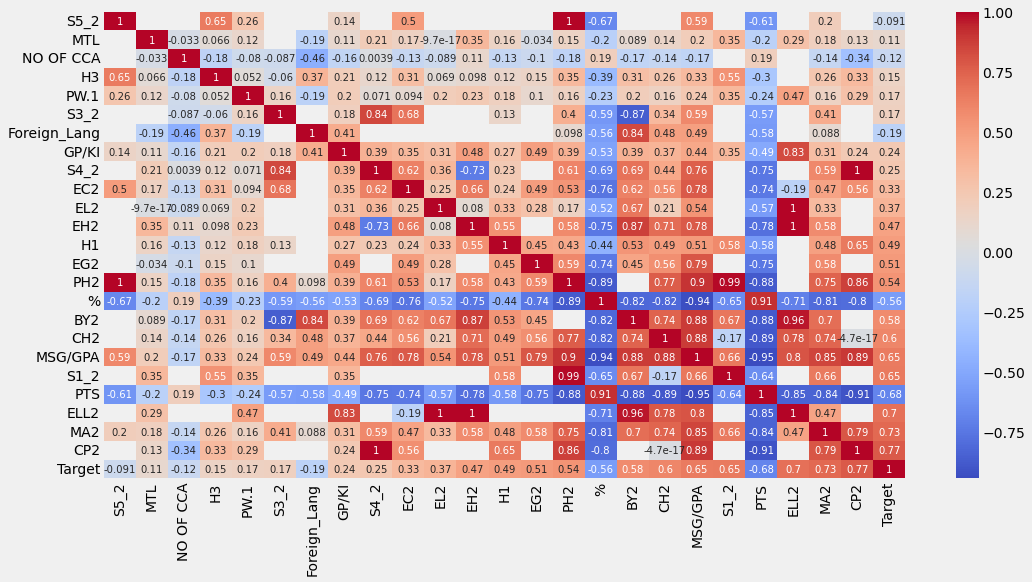

In [57]:
# plot heatmap of correlations for Batch 18, remove 'FM2' and 'S2_2'
sns.heatmap(test_18[corr_18.index[:-2]].corr(), cmap='coolwarm', annot=True, annot_kws={'size': 10});

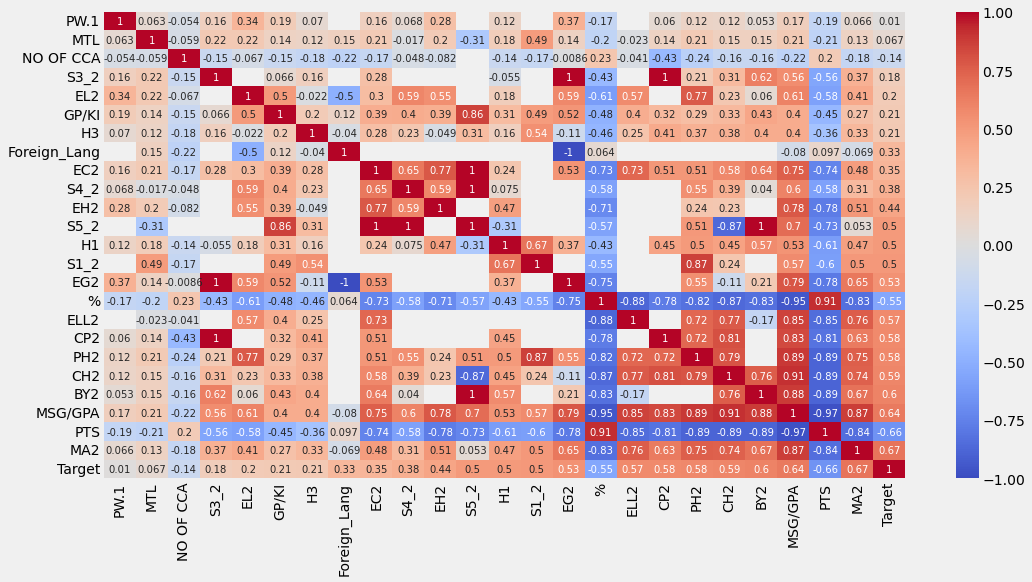

In [58]:
# plot heatmap of correlations for Batch 19, remove 'FM2' and 'S2_2'
sns.heatmap(test_19[corr_19.index[:-2]].corr(), cmap='coolwarm', annot=True, annot_kws={'size': 10});

The 3 features for overall results, 'PTS', 'MSG/GPA' and '%', are very highly inter-correlated (magnitude more than 0.9), so we decide to use only the feature with the highest correlation with our Target, which is 'PTS' and drop 'MSG/GPA' and '%'.

Many of the subjects are also highly inter-correlated. For example, if we look at the row for 'PTS', we see that many of the subjects have a strong linear correlation with PTS with a magnitude of more than 0.8.

'PW.1' and 'MTL' have very low correlation (less than 0.2) with the target, and they have a small number of missing values, so we will remove them.

To minimize the problem of imputing missing values (thus creating fictitious data), we will only keep the subjects with minimal missing values, which are 'GP/KI', 'MA2', 'H1' and 'H3'. The null entries of 'H1' and 'H3' will be converted to level 0 and level 5 as before. The 'missed' entries will have to be imputed after more data exploration as we will need to predict an A Level grade for every single student, so we cannot drop any row.

We will also drop 'REPEAT' and 'P/F' as these columns have very low variability (almost all the values are the same).

## Choosing 'MA2' Grades, Marks or Percentiles to use
We note from above that the correlation of 'MA2' Grades with the Target is around 0.7 (0.73 for Batch 18 and 0.67 for Batch 19). We find the correlation of 'MA2' Marks and Percentiles with the Target to see if we should use any of them in place of Grades.

In [59]:
# calculate correlation coefficients witht Target
for j in range (1,3):
    print(f' {dataset_type[j]} '.center(17, "="))
    df = pd.to_numeric(Prelim[0][j]['MA2'], errors='coerce')
    print(f"Batch 18: {round(df.corr(test_18['Target']),4)}")
    df = pd.to_numeric(Prelim[1][j]['MA2'], errors='coerce')
    print(f"Batch 19: {round(df.corr(test_19['Target']),4)}")
    print()

===== Marks =====
Batch 18: -0.6731
Batch 19: -0.6578

== Percentiles ==
Batch 18: -0.6008
Batch 19: -0.5852



In [60]:
# proportion of students in lowest grade category of 'U'
print(" Proportion of U ".center(23, "="))
for i in range(3):
    print(f"Batch {batch[i]}: {round(Prelim[i][0]['MA2'].value_counts(normalize=True)['U'],2)*100}%")

=== Proportion of U ===
Batch 18: 6.0%
Batch 19: 9.0%
Batch 20: 9.0%


The correlations with marks and percentiles are weaker than with grades. However, the proportion of targets in the category we are most interested in (less than 1% of students score E, S or U in A levels and need more attention) is much lower than the number of students in the lowest grade category of U in Prelims (around 6%-9%), we would be unable to capture the target 'ESU' group well with just grade information.

Between marks and percentiles, Marks has a higher linear correlation with our target. Hence we will use 'MA2' marks in our modelling.

## Create new dataframes with information for modelling
We will create new dataframes to contain the final features that we will use for modelling. We One-Hot Encode nominal features 'GENDER', 'INTAKE', 'SEC SCHOOL' and keep the information of content subjects taken through One-Hot Encoding as well. The numerical features remaining are transformed from the grades of 'GP/KI', 'H1' and 'H3', the overall performance indicator 'PTS', as well as the marks of 'MA2'.

In [61]:
# Create datasets of feature list with 'MA2' Marks
Features_18 = pd.DataFrame()
Features_19 = pd.DataFrame()
Features_20 = pd.DataFrame()
# for looping purposes
Features = [Features_18, Features_19, Features_20]

# list of subjects to one-hot encode, exclude MA2, MA1, versions of subjects with (A)
# keep 'Foreign_Lang' instead of 'FR2', 'GM2', 'JP2', 'SP2'

# for H1, keep only 'EC1' with largest candidature and merge the rest into 'H1_Arts' or 'H1_Sci'

# for H3, merge 'S2_3-MOE' and 'EC3-MOE' into 'S2_3_EC3-MOE'

subj_to_encode = ['KI', 'FM2', 'CP2', 'PH2', 'CH2', 'BY2', 'EL2', 'ELL2', 'EC2', 
                  'EH2', 'EG2', 'S1_2', 'S2_2', 'S3_2', 'S4_2', 'S5_2', 'EC1', 
                  'MA3-MOE', 'PH3-MOE', 'CH3-MOE', 'BY3-MOE', 'S1_3-MOE', 'Foreign_Lang']

for i in range(3): 
    # One-Hot Encode Gender, Intake and Sec School
    Features[i] = pd.get_dummies(Prelim[i][0][['GENDER', 'INTAKE', 'SEC SCHOOL']])
    
    # One-Hot Encode subjects taken
    for subj in subj_to_encode:
        Features[i][subj] = Prelim[i][0][subj].notna().astype('int')
    
    # Merge 'EL1', 'EH1', 'EG1' into 'H1_Arts'
    Features[i]['H1_Arts'] = (Prelim[i][0]['EL1'].notna()|\
                              Prelim[i][0]['EH1'].notna()|\
                              Prelim[i][0]['EG1'].notna()).astype('int')
    # Merge 'PH1', 'CH1', 'BY1' into 'H1_Sci'
    Features[i]['H1_Sci'] = (Prelim[i][0]['PH1'].notna()|\
                             Prelim[i][0]['CH1'].notna()|\
                             Prelim[i][0]['BY1'].notna()).astype('int')
    # merge 'S2_3-MOE' and 'EC3-MOE' into 'S2_3_EC3-MOE'
    Features[i]['S2_3_EC3-MOE'] = (Prelim[i][0]['S2_3-MOE'].notna()|\
                                   Prelim[i][0]['EC3-MOE'].notna()).astype('int')
    
    # MA2 marks with 'EX'/'MC' mapped to 'missed'
    Features[i]['MA2'] = Prelim[i][1]['MA2'].replace({'EX': 'missed', 'MC': 'missed'})
    
    # PTS
    Features[i]['PTS'] = Prelim[i][0]['PTS']
    # NO OF CCA
    Features[i]['NO OF CCA'] = Prelim[i][0]['NO OF CCA']
    
    # Grades (keeping NaN until all 'missed' values are imputed)
    for subj in ['GP/KI', 'H1', 'H3']:
        Features[i][subj] = Prelim[i][0][subj]
    
    # check dataframes
    display(Features[i].head())
    print(f'Batch {batch[i]}')

,GENDER_F,GENDER_M,INTAKE_DSA,INTAKE_DSA (CCA),INTAKE_IP (X),INTAKE_IP (Y),INTAKE_JAE Ordinary Admission,SEC SCHOOL_BUKIT PANJANG GOVT. HIGH SCHOOL,SEC SCHOOL_CATHOLIC HIGH SCHOOL,SEC SCHOOL_CHIJ ST. NICHOLAS GIRLS' SCHOOL,...,Foreign_Lang,H1_Arts,H1_Sci,S2_3_EC3-MOE,MA2,PTS,NO OF CCA,GP/KI,H1,H3
NEWID,,,,,,,,,,,,,,,,,,,,,
20180001,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,69.5,85.0,1,B,NaN,NaN
20180002,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,84,80.0,1,C,NaN,NaN
20180003,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,61.5,57.5,1,C,NaN,NaN
20180005,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,56.5,65.0,1,D,NaN,NaN
20180006,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,66.5,87.5,1,A,NaN,ME


Batch 18


,GENDER_F,GENDER_M,INTAKE_DSA,INTAKE_DSA (CCA),INTAKE_IP (X),INTAKE_IP (Y),INTAKE_JAE Ordinary Admission,SEC SCHOOL_BUKIT PANJANG GOVT. HIGH SCHOOL,SEC SCHOOL_CATHOLIC HIGH SCHOOL,SEC SCHOOL_CHIJ ST. NICHOLAS GIRLS' SCHOOL,...,Foreign_Lang,H1_Arts,H1_Sci,S2_3_EC3-MOE,MA2,PTS,NO OF CCA,GP/KI,H1,H3
NEWID,,,,,,,,,,,,,,,,,,,,,
20190001,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,41,47.50,1,S,E,NaN
20190002,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,71.5,88.75,1,A,NaN,DI
20190003,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,63,81.25,1,B,NaN,NaN
20190004,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,49,58.75,1,C,NaN,NaN
20190005,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,37.5,50.00,1,C,NaN,NaN


Batch 19


,GENDER_F,GENDER_M,INTAKE_DSA,INTAKE_DSA (CCA),INTAKE_IP (X),INTAKE_IP (Y),INTAKE_JAE Ordinary Admission,SEC SCHOOL_BUKIT PANJANG GOVT. HIGH SCHOOL,SEC SCHOOL_CATHOLIC HIGH SCHOOL,SEC SCHOOL_CHIJ ST. NICHOLAS GIRLS' SCHOOL,...,Foreign_Lang,H1_Arts,H1_Sci,S2_3_EC3-MOE,MA2,PTS,NO OF CCA,GP/KI,H1,H3
NEWID,,,,,,,,,,,,,,,,,,,,,
20200001,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,68,85.00,1,B,NaN,NaN
20200002,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,62.8,78.75,1,B,NaN,NaN
20200003,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,64.2,66.25,1,B,NaN,NaN
20200004,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,50,52.50,2,C,NaN,NaN
20200005,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,40.2,43.75,1,D,NaN,NaN


Batch 20


---
# C1 Datasets

In [62]:
# load Batch 18 datasets on C1 Results
C1_Grades_18 = pd.read_csv('../data_raw/18 Batch C1 Grades.csv', index_col='NEWID')
C1_Marks_18 = pd.read_csv('../data_raw/18 Batch C1 Marks.csv', index_col='NEWID')
C1_Perc_18 = pd.read_csv('../data_raw/18 Batch C1 Percentiles.csv', index_col='NEWID')

# load Batch 19 datasets on C1 Results
C1_Grades_19 = pd.read_csv('../data_raw/19 Batch C1 Grades.csv', index_col='NEWID')
C1_Marks_19 = pd.read_csv('../data_raw/19 Batch C1 Marks.csv', index_col='NEWID')
C1_Perc_19 = pd.read_csv('../data_raw/19 Batch C1 Percentiles.csv', index_col='NEWID')

# load Batch 20 datasets on C1 Results
C1_Grades_20 = pd.read_csv('../data_raw/20 Batch C1 Grades.csv', index_col='NEWID')
C1_Marks_20 = pd.read_csv('../data_raw/20 Batch C1 Marks.csv', index_col='NEWID')
C1_Perc_20 = pd.read_csv('../data_raw/20 Batch C1 Percentiles.csv', index_col='NEWID')

In [63]:
# for looping purposes
C1 = [[C1_Grades_18, C1_Marks_18, C1_Perc_18, C1_Grades_18],
      [C1_Grades_19, C1_Marks_19, C1_Perc_19, C1_Grades_19],
      [C1_Grades_20, C1_Marks_20, C1_Perc_20, C1_Grades_20],
      [C1_Grades_18, C1_Marks_18, C1_Perc_18, C1_Grades_18]]

# drop students who did not take MA2 and print number of columns
for i in range(3):
    print(f' Batch {batch[i]} '.center(30, "="))
    for j in range(3):
        C1[i][j].drop(index=ind_to_del[i], inplace=True)
        print(f"{dataset_type[j]}: {C1[i][j].shape[1]}")
    print()

========== Batch 18 ==========
Grades: 47
Marks: 41
Percentiles: 41

========== Batch 19 ==========
Grades: 47
Marks: 41
Percentiles: 41

========== Batch 20 ==========
Grades: 47
Marks: 41
Percentiles: 41



The number of rows match with the Prelim datasets. [Note: we changed from printing shape to just number of columns due to confidentiality.] We look into the differences in column names.

In [64]:
for i in range(3):
    print(f" Batch {batch[i]} ".center(50, "="))
    for j in range(3):
        print(f"In {dataset_type[j]} dataset but not in {dataset_type[j+1]} dataset:")
        print_diff(C1[i][j], C1[i][j+1])
    print()
    
print(" Differences between Batches ".center(50, "="))
for i in range(3): 
    print(f"In Batch {batch[i]} dataset but not in Batch {batch[i+1]} dataset:")
    print_diff(C1[i][0], C1[i+1][0])
    print(f"In Batch {batch[i+1]} dataset but not in Batch {batch[i]} dataset:")
    print_diff(C1[i+1][0], C1[i][0])
    print()

==================== Batch 18 ====================
In Grades dataset but not in Marks dataset:
['%' 'MSG/GPA' 'MTL' 'P/F' 'PTS' 'PW' 'RANK']
In Marks dataset but not in Percentiles dataset:
[]
In Percentiles dataset but not in Grades dataset:
['SN']

==================== Batch 19 ====================
In Grades dataset but not in Marks dataset:
['%' 'MSG/GPA' 'MTL' 'P/F' 'PTS' 'PW' 'RANK']
In Marks dataset but not in Percentiles dataset:
[]
In Percentiles dataset but not in Grades dataset:
['SN']

==================== Batch 20 ====================
In Grades dataset but not in Marks dataset:
['%' 'MSG/GPA' 'MTL' 'P/F' 'PTS' 'PW' 'RANK']
In Marks dataset but not in Percentiles dataset:
[]
In Percentiles dataset but not in Grades dataset:
['SN']

========== Differences between Batches ===========
In Batch 18 dataset but not in Batch 19 dataset:
['JP2' 'S1_1']
In Batch 19 dataset but not in Batch 18 dataset:
['JP1' 'PH1']

In Batch 19 dataset but not in Batch 20 dataset:
['EH1' 'JP1']
In Ba

## Differences in columns
The differences within the same batch are similar to those for the Prelim datasets. There are some additional subjects that are different for C1 datasets. 

For the Prelim datasets, there are H3 subjects (including the missing 'S2_3-MOE' in Batch 18) that do not appear in the C1 datasets as these subjects are only taken up in JC2.

For the C1 datasets, there are some H1 subjects that are examined at the end of JC1, such as 'JP1' and 'S1_1' so they do not appear in the Prelim datasets. We ignore them and do not include them under the 'H1' column.

'BY1' is not in the C1 datasets but in the Prelim datasets because the student(s) only downgraded from H2 Biology to H1 Biology in JC2. Similarly, 'PH1' is not in the C1 Batch 18 datasets, because the student(s) only downgraded from H2 Physics to H1 Physics in JC2.

In [65]:
# create columns of NaN in dataframes where H1 subjects were missing
C1[0][0]['PH1'] = np.nan
C1[2][0]['EH1'] = np.nan

# display grades dataframe head
for i in range(3):
    display(C1[i][0].head())
    print(f'Batch {batch[i]}')

,GENDER,PSLE,REPEAT,INTAKE,SEC SCHOOL,GP,KI,KI (A),MA2,FM2,...,S1_1,PW,MTL,P/F,RANK,%,MSG/GPA,PTS,NO OF CCA,PH1
NEWID,,,,,,,,,,,,,,,,,,,,,
20180001,M,260,NaN,IP (X),SCHOOL X,C,NaN,NaN,B,NaN,...,NaN,A,A,Passed,256.0,78.0,2.0,70.00,1,NaN
20180002,F,253,NaN,JAE Ordinary Admission,METHODIST GIRLS' SCHOOL (SECONDARY),D,NaN,NaN,A,NaN,...,NaN,A,B,Passed,185.0,84.0,1.5,72.50,1,NaN
20180003,F,262,NaN,IP (Y),SCHOOL Y,C,NaN,NaN,S,NaN,...,NaN,A,B,Passed,940.0,19.0,4.8,45.00,1,NaN
20180005,M,237,NaN,JAE Ordinary Admission,MARIS STELLA HIGH SCHOOL,D,NaN,NaN,A,NaN,...,NaN,B,B,Passed,624.0,46.0,3.3,58.75,1,NaN
20180006,M,246,NaN,JAE Ordinary Admission,CATHOLIC HIGH SCHOOL,NaN,A,NaN,B,NaN,...,NaN,A,B,Passed,125.0,89.0,1.5,75.00,1,NaN


Batch 18


,GENDER,PSLE,REPEAT,INTAKE,SEC SCHOOL,GP,KI,KI (A),MA2,FM2,...,EG1,JP1,PW,MTL,P/F,RANK,%,MSG/GPA,PTS,NO OF CCA
NEWID,,,,,,,,,,,,,,,,,,,,,
20190001,M,189,NaN,DSA (CCA),CATHOLIC HIGH SCHOOL,E,NaN,NaN,D,NaN,...,NaN,NaN,A,E,Passed,1078.0,3.0,5.9,22.50,1
20190002,M,256,NaN,IP (X),SCHOOL X,A,NaN,NaN,A,NaN,...,NaN,NaN,A,B,Passed,1.0,100.0,1.0,80.00,1
20190003,M,231,NaN,IP (X),SCHOOL X,C,NaN,NaN,D,NaN,...,NaN,NaN,A,A,Passed,569.0,48.0,3.0,61.25,1
20190004,M,255,NaN,IP (X),SCHOOL X,C,NaN,NaN,C,NaN,...,NaN,NaN,B,B,Passed,1007.0,9.0,5.3,37.50,1
20190005,M,0,NaN,JAE Ordinary Admission,MARIS STELLA HIGH SCHOOL,D,NaN,NaN,D,NaN,...,NaN,NaN,A,A,Passed,803.0,27.0,4.0,51.25,1


Batch 19


,GENDER,PSLE,REPEAT,INTAKE,SEC SCHOOL,KI,GP,KI (A),MA2,FM2,...,S1_1,PW,MTL,P/F,RANK,%,MSG/GPA,PTS,NO OF CCA,EH1
NEWID,,,,,,,,,,,,,,,,,,,,,
20200001,F,0,NaN,JAE Ordinary Admission,"SCHOOL OF SCIENCE AND TECHNOLOGY, SINGAPORE",NaN,B,NaN,B,NaN,...,NaN,A,E,Passed,324.0,69.0,1.8,72.50,1,NaN
20200002,F,0,NaN,IP (Y),SCHOOL Y,NaN,C,NaN,B,NaN,...,NaN,A,A,Passed,580.0,45.0,2.5,66.25,1,NaN
20200003,F,0,NaN,JAE Ordinary Admission,NAN CHIAU HIGH SCHOOL,NaN,C,NaN,B,NaN,...,NaN,A,A,Passed,841.0,21.0,3.8,55.00,1,NaN
20200004,M,0,NaN,IP (X),SCHOOL X,NaN,D,NaN,C,NaN,...,NaN,A,B,Passed,772.0,27.0,3.3,58.75,2,NaN
20200005,F,0,NaN,IP (Y),SCHOOL Y,NaN,C,NaN,S,NaN,...,NaN,A,A,Passed,895.0,16.0,4.3,50.00,1,NaN


Batch 20


In [66]:
# print grades columns
for i in range(3):
    print(f' Batch {batch[i]} '.center(40, "="))
    print(C1[i][0].columns)
    print()

=============== Batch 18 ===============
Index(['GENDER', 'PSLE', 'REPEAT', 'INTAKE', 'SEC SCHOOL', 'GP', 'KI',
       'KI (A)', 'MA2', 'FM2', 'CP2', 'PH2', 'CH2', 'BY2', 'EL2', 'EL2 (A)',
       'ELL2', 'EC2', 'EC2 (A)', 'EH2', 'EH2 (A)', 'EG2', 'EG2 (A)', 'S1_2',
       'S2_2', 'S3_2', 'S4_2', 'S5_2', 'FR2', 'GM2', 'JP2', 'SP2', 'MA1',
       'CH1', 'EL1', 'EC1', 'EH1', 'EG1', 'S1_1', 'PW', 'MTL', 'P/F', 'RANK',
       '%', 'MSG/GPA', 'PTS', 'NO OF CCA', 'PH1'],
      dtype='object')

=============== Batch 19 ===============
Index(['GENDER', 'PSLE', 'REPEAT', 'INTAKE', 'SEC SCHOOL', 'GP', 'KI',
       'KI (A)', 'MA2', 'FM2', 'CP2', 'PH2', 'CH2', 'BY2', 'EL2', 'EL2 (A)',
       'ELL2', 'EC2', 'EC2 (A)', 'EH2', 'EH2 (A)', 'EG2', 'EG2 (A)', 'S1_2',
       'S2_2', 'S3_2', 'S4_2', 'S5_2', 'FR2', 'GM2', 'SP2', 'MA1', 'PH1',
       'CH1', 'EL1', 'EC1', 'EH1', 'EG1', 'JP1', 'PW', 'MTL', 'P/F', 'RANK',
       '%', 'MSG/GPA', 'PTS', 'NO OF CCA'],
      dtype='object')

=============== Batch 20

We note that the columns not related to subjects and overall results are identical to information already captured in the Prelim datasets, hence we will only focus on the subjects. We will zoom in on the corresponding features selected in the Prelim datasets.

### Transform to align with Prelim datasets
The final feature list in the Prelim datasets is 'GENDER', 'INTAKE', 'SEC SCHOOL', 'GP/KI', 'MA2', 'H1', 'H3', 'PTS'. We will create the 'GP/KI' and 'H1' columns in the C1 datasets ('H3' not taken in C1).

In [67]:
# create 'H1' column
subj_H1 = ['PH1', 'CH1', 'EL1', 'EC1', 'EH1', 'EG1']

for i in range(3):
    
    # merge 'GP', 'KI' and 'KI(A)' into new column 'GP/KI'
    C1[i][0]['GP'].fillna(C1[i][0]['KI'], inplace=True)
    C1[i][0]['GP'].fillna(C1[i][0]['KI (A)'], inplace=True)
    C1[i][0].rename(columns={'GP': 'GP/KI'}, inplace=True)
    
    # merge H1 subjects into new column 'H1'
    C1[i][0]['H1'] = np.nan
    for h1 in subj_H1:
        C1[i][0]['H1'].fillna(C1[i][0][h1], inplace=True)

In [68]:
# change 'EX' and 'MC' to 'missed'
for i in range(3):
    for subj in ['GP/KI', 'H1']:
        C1[i][0][subj].replace({'EX': 'missed', 'MC': 'missed'}, inplace=True)
        
    # replace grades of 'MA2' with marks
    C1[i][0]['MA2'] = C1[i][1]['MA2'].replace({'EX': 'missed', 'MC': 'missed'})

In [69]:
# merge to Prelim Numerical Features
features_C1 = ['GP/KI', 'MA2', 'H1', 'PTS']
features_Prelim = features_C1 + ['H3', 'NO OF CCA']

merged_18 = Features[0][features_Prelim].join(C1[0][0][features_C1], rsuffix='_C1')
merged_19 = Features[1][features_Prelim].join(C1[1][0][features_C1], rsuffix='_C1')
merged_20 = Features[2][features_Prelim].join(C1[2][0][features_C1], rsuffix='_C1')

# create list for looping
merged = [merged_18, merged_19, merged_20]

### Check for null values

In [70]:
# check for proportion of null values
for i in range(3):
    print(f' Batch {batch[i]} '.center(24, "="))
    print(round(merged[i].isna().sum() / merged[i].shape[0], 2))
    print()

======= Batch 18 =======
GP/KI        0.00
MA2          0.00
H1           0.85
PTS          0.00
H3           0.85
NO OF CCA    0.00
GP/KI_C1     0.00
MA2_C1       0.00
H1_C1        0.91
PTS_C1       0.00
dtype: float64

======= Batch 19 =======
GP/KI        0.00
MA2          0.00
H1           0.87
PTS          0.00
H3           0.77
NO OF CCA    0.00
GP/KI_C1     0.00
MA2_C1       0.00
H1_C1        0.92
PTS_C1       0.00
dtype: float64

======= Batch 20 =======
GP/KI        0.00
MA2          0.00
H1           0.92
PTS          0.00
H3           0.79
NO OF CCA    0.00
GP/KI_C1     0.00
MA2_C1       0.01
H1_C1        0.95
PTS_C1       0.00
dtype: float64



The proportion of missing values in 'H1_C1' is higher than in 'H1' in the Prelim datasets, because some students downgraded their H2 to H1 only in JC2.

There are also a handful of entries missing in the other C1 columns, which we investigate below.

In [71]:
# list to hold indices of NaN rows for imputation later
nan_ind_list = [[],[],[]]

# find rows with missing info
for i in range(3):
    df = C1[i][0][C1[i][0]['MA2'].isna()]
    nan_ind_list[i] = list(df.index)
    display(df)
    print(f'Batch {batch[i]}')

,GENDER,PSLE,REPEAT,INTAKE,SEC SCHOOL,GP/KI,KI,KI (A),MA2,FM2,...,PW,MTL,P/F,RANK,%,MSG/GPA,PTS,NO OF CCA,PH1,H1
NEWID,,,,,,,,,,,,,,,,,,,,,
20180042,F,258,Repeat Yr2,IP (Y),SCHOOL Y,NaN,NaN,NaN,NaN,NaN,...,A,C,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN


Batch 18


,GENDER,PSLE,REPEAT,INTAKE,SEC SCHOOL,GP/KI,KI,KI (A),MA2,FM2,...,JP1,PW,MTL,P/F,RANK,%,MSG/GPA,PTS,NO OF CCA,H1
NEWID,,,,,,,,,,,,,,,,,,,,,
20190711,M,236,Repeat Yr2,DSA (CCA),CATHOLIC HIGH SCHOOL,NaN,NaN,NaN,NaN,NaN,...,NaN,A,B,NaN,NaN,NaN,NaN,NaN,1,NaN


Batch 19


,GENDER,PSLE,REPEAT,INTAKE,SEC SCHOOL,KI,GP/KI,KI (A),MA2,FM2,...,PW,MTL,P/F,RANK,%,MSG/GPA,PTS,NO OF CCA,EH1,H1
NEWID,,,,,,,,,,,,,,,,,,,,,
20200086,F,0,Repeat Yr2,JAE Ordinary Admission,CHUNG CHENG HIGH SCHOOL (MAIN),NaN,NaN,NaN,NaN,NaN,...,B,B,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
20200346,M,254,Repeat Yr2,IP (X),SCHOOL X,NaN,NaN,NaN,NaN,NaN,...,C,S,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
20200458,M,0,NaN,IP (X),SCHOOL X,NaN,C,NaN,NaN,NaN,...,B,A,Passed,808.0,24.0,3.3,57.5,1,NaN,NaN
20200485,M,0,Repeat Yr2,JAE Ordinary Admission,LOYANG VIEW SECONDARY SCHOOL,NaN,NaN,NaN,NaN,NaN,...,B,A,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
20200599,M,260,Repeat Yr2,IP (X),SCHOOL X,NaN,NaN,NaN,NaN,NaN,...,A,A,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
20201045,M,264,Repeat Yr2,IP (X),SCHOOL X,NaN,NaN,NaN,NaN,NaN,...,A,A,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


Batch 20


Except for one student in batch 20, the results are missing for these students as they repeated year 2. We will impute these missing values using Prelim data before modelling if we decide to use these features.

We look for the subjects taken by this non-repeat student in C1 and C2 (i.e. Prelim).

In [72]:
# C1 subjects
C1[2][0].loc[20200458][C1[2][0].loc[20200458].notna()].index

Index(['GENDER', 'PSLE', 'INTAKE', 'SEC SCHOOL', 'GP/KI', 'EL2', 'EG2', 'S3_2',
       'MA1', 'PW', 'MTL', 'P/F', 'RANK', '%', 'MSG/GPA', 'PTS', 'NO OF CCA'],
      dtype='object')

In [73]:
# Prelim subjects
Prelim[2][0].loc[20200458][Prelim[2][0].loc[20200458].notna()].index

Index(['GENDER', 'PSLE', 'INTAKE', 'SEC SCHOOL', 'PW', 'GP/KI', 'MA2', 'EL2',
       'EG2', 'S3_2', 'PW.1', 'MTL', 'P/F', 'RANK', '%', 'MSG/GPA', 'PTS',
       'NO OF CCA'],
      dtype='object')

This student was allowed to upgrade from H1 Math in C1 to H2 Math in C2. We change his 'MA2' mark from NaN to 'missed' and we removed him from the nan_ind_list.

In [74]:
# change 'MA2' mark from NaN to 'missed'
merged[2].loc[20200458, 'MA2_C1'] = 'missed'
nan_ind_list[2].remove(20200458)

In [75]:
# check Prelim results for students with missing C1 results
for i in range(3):
    display(merged[i].loc[nan_ind_list[i]])
    print(f'Batch {batch[i]}')

,GP/KI,MA2,H1,PTS,H3,NO OF CCA,GP/KI_C1,MA2_C1,H1_C1,PTS_C1
NEWID,,,,,,,,,,
20180042,C,48,C,62.5,NaN,1,NaN,NaN,NaN,NaN


Batch 18


,GP/KI,MA2,H1,PTS,H3,NO OF CCA,GP/KI_C1,MA2_C1,H1_C1,PTS_C1
NEWID,,,,,,,,,,
20190711,D,54.5,B,77.5,NaN,1,NaN,NaN,NaN,NaN


Batch 19


,GP/KI,MA2,H1,PTS,H3,NO OF CCA,GP/KI_C1,MA2_C1,H1_C1,PTS_C1
NEWID,,,,,,,,,,
20200086,B,26,NaN,22.50,NaN,0,NaN,NaN,NaN,NaN
20200346,missed,missed,missed,7.50,NaN,0,NaN,NaN,NaN,NaN
20200485,E,missed,missed,28.75,NaN,0,NaN,NaN,NaN,NaN
20200599,A,86.2,NaN,88.75,DI,1,NaN,NaN,NaN,NaN
20201045,C,67.9,NaN,78.75,NaN,0,NaN,NaN,NaN,NaN


Batch 20


We copy the columns of the Prelim results over to the C1 results for these 7 students, including entries with 'missed' so these get imputed later.

In [76]:
# copy Prelim results to C1 results
for i in range(3):
    for j in nan_ind_list[i]:
        for feature in ['GP/KI', 'MA2', 'H1', 'PTS']:
            merged[i].loc[j, feature+'_C1'] = merged[i].loc[j, feature]

### Check correlation coefficients

In [77]:
# create dataframes with selected features in Prelim and C1 datasets, and targets for Batches 18 and 19
test2_18 = pd.concat([merged[0], y_18['Target']], axis=1)
test2_19 = pd.concat([merged[1], y_19['Target']], axis=1)

# map Prelim grades to numbers
for subj in ['GP/KI', 'GP/KI_C1']:
    test2_18[subj].replace(grade_dict, inplace=True)
    test2_19[subj].replace(grade_dict, inplace=True)
    
test2_18['H1'].replace(grade_dict_H1, inplace=True)
test2_19['H1'].replace(grade_dict_H1, inplace=True)
test2_18['H1_C1'].replace(grade_dict_H1, inplace=True)
test2_19['H1_C1'].replace(grade_dict_H1, inplace=True)
test2_18['H3'].replace(grade_dict_H3, inplace=True)
test2_19['H3'].replace(grade_dict_H3, inplace=True)
test2_18['MA2'] = pd.to_numeric(test2_18['MA2'], errors='coerce')
test2_19['MA2'] = pd.to_numeric(test2_19['MA2'], errors='coerce')
test2_18['MA2_C1'] = pd.to_numeric(test2_18['MA2_C1'], errors='coerce')
test2_19['MA2_C1'] = pd.to_numeric(test2_19['MA2_C1'], errors='coerce')

# features ranked by magnitude of correlation to Target
corr2_18 = test2_18.corr().tail(1).T.sort_values('Target', key=abs)
corr2_19 = test2_19.corr().tail(1).T.sort_values('Target', key=abs)
corr2_18.rename(columns={'Target': 'Correlation with Target'}, inplace=True)
corr2_19.rename(columns={'Target': 'Correlation with Target'}, inplace=True)

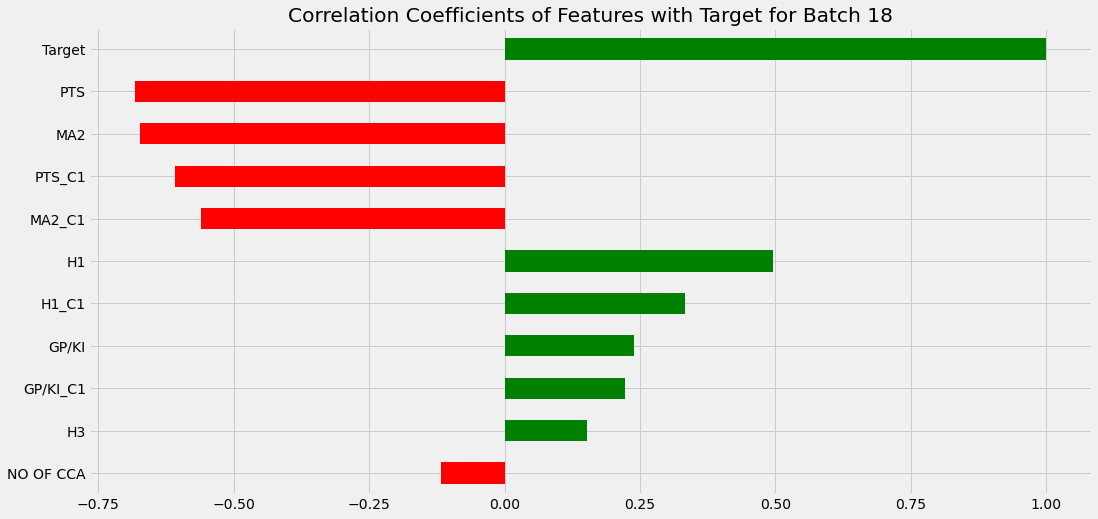

In [78]:
# plot of correlation for Batch 18
plot_bar(corr2_18, 18)

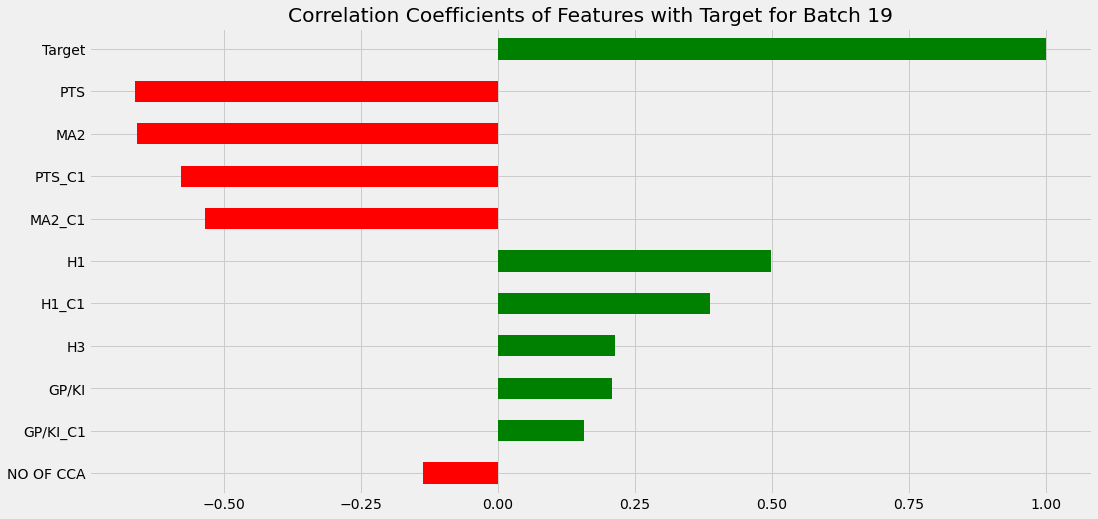

In [79]:
# plot of correlation for Batch 18
plot_bar(corr2_19, 19)

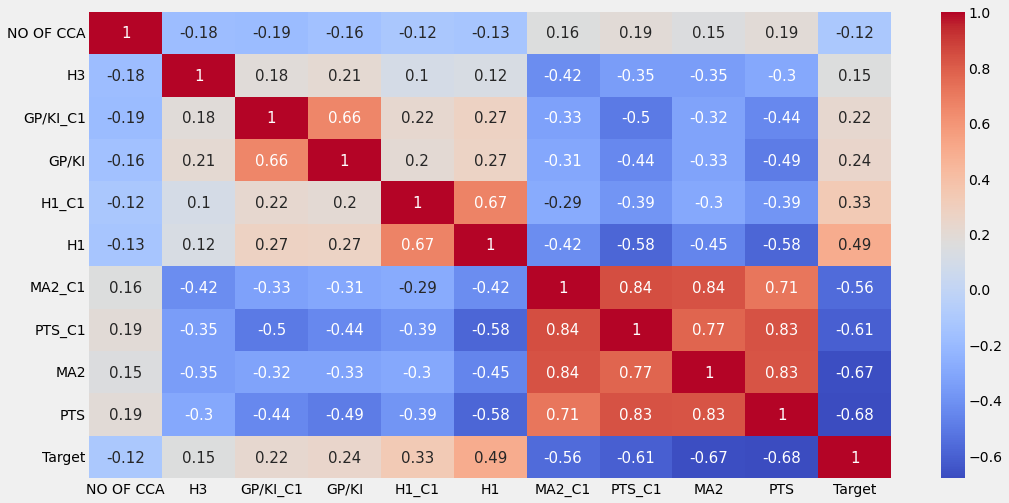

In [80]:
# plot heatmap of correlations for Batch 18
sns.heatmap(test2_18[corr2_18.index].corr(), cmap='coolwarm', annot=True, annot_kws={'size': 15});

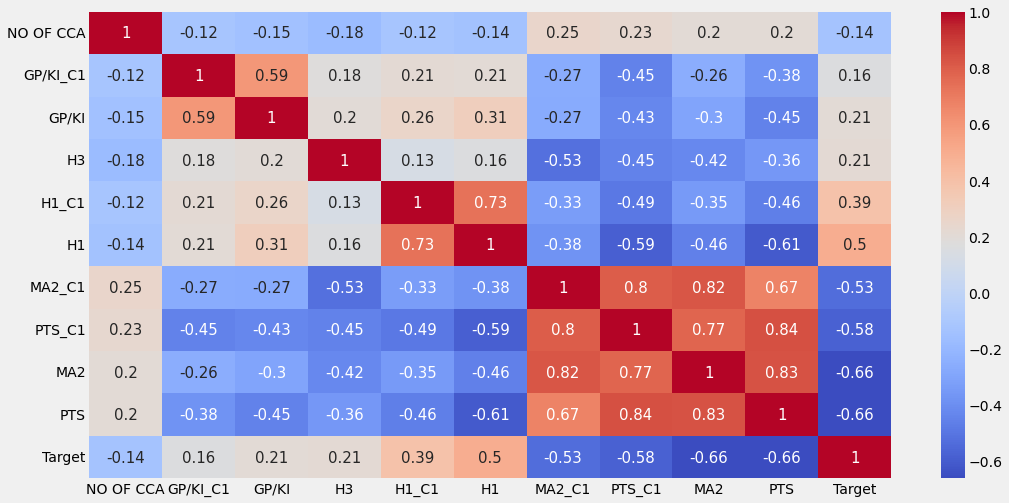

In [81]:
# plot heatmap of correlations for Batch 19
sns.heatmap(test2_19[corr2_19.index].corr(), cmap='coolwarm', annot=True, annot_kws={'size': 15});

The correlations of the numeric features with the Target are not very low, and the inter-correlation between the features are not exceedingly high, so we will keep all the columns as predictors in our model.

## Imputing values for students who missed exam

In [82]:
# save indices of 'missed' exams
missed_ind_list = [[],[],[]]

# find 'missed' in Prelim and C1 grades/marks
for i in range(3):
    df = merged[i][merged[i].isin(['missed']).any(axis=1)]
    missed_ind_list[i] = list(df.index)
    display(df)
    print(f'Batch {batch[i]}')

,GP/KI,MA2,H1,PTS,H3,NO OF CCA,GP/KI_C1,MA2_C1,H1_C1,PTS_C1
NEWID,,,,,,,,,,
20180166,missed,74,NaN,68.75,NaN,1,D,72.8,NaN,66.25
20180182,C,missed,NaN,17.50,NaN,1,D,45.4,E,41.25
20180196,D,missed,C,55.00,NaN,1,D,39.8,E,41.25
20180406,C,54.5,NaN,67.50,NaN,1,C,missed,NaN,47.50
20180409,missed,missed,NaN,10.00,NaN,1,B,52.1,NaN,63.75
20180439,D,36.5,missed,21.25,NaN,0,E,46.8,U,40.00
20180838,D,53.5,NaN,56.25,NaN,1,E,missed,NaN,5.00
20180874,B,61.5,NaN,78.75,NaN,1,D,missed,NaN,46.25
20180895,B,70,NaN,81.25,NaN,1,C,missed,NaN,35.00


Batch 18


,GP/KI,MA2,H1,PTS,H3,NO OF CCA,GP/KI_C1,MA2_C1,H1_C1,PTS_C1
NEWID,,,,,,,,,,
20190082,missed,48,NaN,60.00,NaN,1,D,44.4,NaN,56.25
20190118,D,31,B,47.50,NaN,2,D,missed,NaN,31.25
20190172,A,66,NaN,83.75,ME,1,B,missed,NaN,66.25
20190410,A,44.5,NaN,72.50,NaN,1,B,missed,NaN,56.25
20190420,C,60,D,58.75,NaN,1,missed,42.2,B,23.75
20190504,missed,missed,NaN,21.25,NaN,1,C,52.1,NaN,67.50
20190519,B,44,NaN,71.25,NaN,1,D,missed,NaN,51.25
20190678,D,55,NaN,58.75,NaN,0,missed,36.7,NaN,27.50
20190840,C,53.5,NaN,63.75,NaN,1,B,missed,NaN,23.75


Batch 19


,GP/KI,MA2,H1,PTS,H3,NO OF CCA,GP/KI_C1,MA2_C1,H1_C1,PTS_C1
NEWID,,,,,,,,,,
20200140,A,33.6,A,53.75,NaN,0,E,missed,missed,5.00
20200200,B,17,C,43.75,NaN,1,missed,missed,NaN,10.00
20200293,B,51.1,NaN,80.00,NaN,1,C,missed,NaN,40.00
20200346,missed,missed,missed,7.50,NaN,0,missed,missed,missed,7.50
20200402,missed,missed,missed,10.00,NaN,0,D,missed,NaN,31.25
20200437,A,59.6,NaN,80.00,NaN,1,A,missed,NaN,55.00
20200458,B,52.3,NaN,52.50,NaN,1,C,missed,NaN,57.50
20200485,E,missed,missed,28.75,NaN,0,E,missed,missed,28.75
20200493,A,87.5,NaN,90.00,missed,1,B,71,NaN,78.75


Batch 20


In [83]:
features_C1 = ['GP/KI_C1', 'MA2_C1', 'H1_C1', 'PTS_C1']
imputed_18 = pd.DataFrame()
imputed_19 = pd.DataFrame()
imputed_20 = pd.DataFrame()
imputed_df = [imputed_18, imputed_19, imputed_20]

for i in range(3):
    to_knn = Features[i].copy()
    for feature in features_C1:
        to_knn[feature] = merged[i][feature]
    to_knn['GP/KI'].replace(grade_dict, inplace=True)
    to_knn['GP/KI_C1'].replace(grade_dict, inplace=True)
    to_knn['H1'].replace(grade_dict_H1, inplace=True)
    to_knn['H1_C1'].replace(grade_dict_H1, inplace=True)
    to_knn['H3'].replace(grade_dict_H3, inplace=True)
    to_knn['MA2'] = to_knn['MA2'].map(lambda m: np.nan if m == 'missed' else float(m))
    to_knn['MA2_C1'] = to_knn['MA2_C1'].map(lambda m: np.nan if m == 'missed' else float(m))
    knn_imp = KNNImputer()
    knn_df = knn_imp.fit_transform(to_knn)
    imputed = pd.DataFrame(knn_df, columns=knn_imp.feature_names_in_)
    imputed['NEWID']=to_knn.index
    imputed_df[i] = imputed.set_index('NEWID', drop=True).loc[missed_ind_list[i]][features_Prelim+features_C1]
    display(imputed_df[i])
    print(f'Batch {batch[i]}')

,GP/KI,MA2,H1,PTS,H3,NO OF CCA,GP/KI_C1,MA2_C1,H1_C1,PTS_C1
NEWID,,,,,,,,,,
20180166,3.6,74.0,0.0,68.75,5.0,1.0,4.0,72.80,0.0,66.25
20180182,3.0,35.4,0.0,17.50,5.0,1.0,4.0,45.40,5.0,41.25
20180196,4.0,45.8,3.0,55.00,5.0,1.0,4.0,39.80,5.0,41.25
20180406,3.0,54.5,0.0,67.50,5.0,1.0,3.0,43.16,0.0,47.50
20180409,3.4,41.9,0.0,10.00,5.0,1.0,2.0,52.10,0.0,63.75
20180439,4.0,36.5,1.4,21.25,5.0,0.0,5.0,46.80,7.0,40.00
20180838,4.0,53.5,0.0,56.25,5.0,1.0,5.0,35.70,0.0,5.00
20180874,2.0,61.5,0.0,78.75,5.0,1.0,4.0,44.64,0.0,46.25
20180895,2.0,70.0,0.0,81.25,5.0,1.0,3.0,42.04,0.0,35.00


Batch 18


,GP/KI,MA2,H1,PTS,H3,NO OF CCA,GP/KI_C1,MA2_C1,H1_C1,PTS_C1
NEWID,,,,,,,,,,
20190082,2.6,48.0,0.0,60.00,5.0,1.0,4.0,44.40,0.0,56.25
20190118,4.0,31.0,2.0,47.50,5.0,2.0,4.0,33.60,0.0,31.25
20190172,1.0,66.0,0.0,83.75,2.0,1.0,2.0,58.34,0.0,66.25
20190410,1.0,44.5,0.0,72.50,5.0,1.0,2.0,44.24,0.0,56.25
20190420,3.0,60.0,4.0,58.75,5.0,1.0,4.6,42.20,2.0,23.75
20190504,3.4,29.1,0.0,21.25,5.0,1.0,3.0,52.10,0.0,67.50
20190519,2.0,44.0,0.0,71.25,5.0,1.0,4.0,42.46,0.0,51.25
20190678,4.0,55.0,0.0,58.75,5.0,0.0,4.0,36.70,0.0,27.50
20190840,3.0,53.5,0.0,63.75,5.0,1.0,2.0,38.78,0.0,23.75


Batch 19


,GP/KI,MA2,H1,PTS,H3,NO OF CCA,GP/KI_C1,MA2_C1,H1_C1,PTS_C1
NEWID,,,,,,,,,,
20200140,1.0,33.60,1.0,53.75,5.0,0.0,5.0,37.58,2.4,5.00
20200200,2.0,17.00,3.0,43.75,5.0,1.0,4.0,32.72,0.0,10.00
20200293,2.0,51.10,0.0,80.00,5.0,1.0,3.0,45.66,0.0,40.00
20200346,3.8,27.40,3.2,7.50,5.0,0.0,4.8,34.88,0.8,7.50
20200402,4.6,27.84,5.0,10.00,5.0,0.0,4.0,41.88,0.0,31.25
20200437,1.0,59.60,0.0,80.00,5.0,1.0,1.0,55.06,0.0,55.00
20200458,2.0,52.30,0.0,52.50,5.0,1.0,3.0,50.06,0.0,57.50
20200485,5.0,30.78,4.2,28.75,5.0,0.0,5.0,31.46,1.6,28.75
20200493,1.0,87.50,0.0,90.00,2.2,1.0,2.0,71.00,0.0,78.75


Batch 20


## Add C1 features to Features dataframe
For modelling, we check that there are no missing values and all values are numeric.

In [84]:
# map Prelim grades to numbers, leave 'missed' as is for imputation later
grade_dict = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'S': 6, 'U': 7, 
              'missed': 'missed', np.nan: np.nan
             }

grade_dict_H1 = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'S': 6, 'U': 7, 
                 'missed': 'missed', np.nan: 0
                }

grade_dict_H3 = {'DI': 1, 'ME': 2, 'PA': 3, 'UC': 4, 'missed': 'missed', np.nan: 5}

In [85]:
# combine C1 features to existing Prelim features dataframe
for i in range(3):   
    for feature in features_C1:
        Features[i][feature] = merged[i][feature]
        
    Features[i]['GP/KI'].replace(grade_dict, inplace=True)
    Features[i]['GP/KI_C1'].replace(grade_dict, inplace=True)
    Features[i]['H1'].replace(grade_dict_H1, inplace=True)
    Features[i]['H1_C1'].replace(grade_dict_H1, inplace=True)
    Features[i]['H3'].replace(grade_dict_H3, inplace=True)

    display(Features[i].head())
    print(f'Batch {batch[i]}')

,GENDER_F,GENDER_M,INTAKE_DSA,INTAKE_DSA (CCA),INTAKE_IP (X),INTAKE_IP (Y),INTAKE_JAE Ordinary Admission,SEC SCHOOL_BUKIT PANJANG GOVT. HIGH SCHOOL,SEC SCHOOL_CATHOLIC HIGH SCHOOL,SEC SCHOOL_CHIJ ST. NICHOLAS GIRLS' SCHOOL,...,MA2,PTS,NO OF CCA,GP/KI,H1,H3,GP/KI_C1,MA2_C1,H1_C1,PTS_C1
NEWID,,,,,,,,,,,,,,,,,,,,,
20180001,0,1,0,0,1,0,0,0,0,0,...,69.5,85.0,1,2,0,5,3,62.3,0,70.00
20180002,1,0,0,0,0,0,1,0,0,0,...,84,80.0,1,3,0,5,4,71,0,72.50
20180003,1,0,0,0,0,1,0,0,0,0,...,61.5,57.5,1,3,0,5,3,40.5,0,45.00
20180005,0,1,0,0,0,0,1,0,0,0,...,56.5,65.0,1,4,0,5,4,68.8,0,58.75
20180006,0,1,0,0,0,0,1,0,1,0,...,66.5,87.5,1,1,0,2,1,61.9,0,75.00


Batch 18


,GENDER_F,GENDER_M,INTAKE_DSA,INTAKE_DSA (CCA),INTAKE_IP (X),INTAKE_IP (Y),INTAKE_JAE Ordinary Admission,SEC SCHOOL_BUKIT PANJANG GOVT. HIGH SCHOOL,SEC SCHOOL_CATHOLIC HIGH SCHOOL,SEC SCHOOL_CHIJ ST. NICHOLAS GIRLS' SCHOOL,...,MA2,PTS,NO OF CCA,GP/KI,H1,H3,GP/KI_C1,MA2_C1,H1_C1,PTS_C1
NEWID,,,,,,,,,,,,,,,,,,,,,
20190001,0,1,0,1,0,0,0,0,1,0,...,41,47.50,1,6,5,5,5,46.7,7,22.50
20190002,0,1,0,0,1,0,0,0,0,0,...,71.5,88.75,1,1,0,1,1,70.7,0,80.00
20190003,0,1,0,0,1,0,0,0,0,0,...,63,81.25,1,2,0,5,3,49.5,0,61.25
20190004,0,1,0,0,1,0,0,0,0,0,...,49,58.75,1,3,0,5,3,52.8,0,37.50
20190005,0,1,0,0,0,0,1,0,0,0,...,37.5,50.00,1,3,0,5,4,48.8,0,51.25


Batch 19


,GENDER_F,GENDER_M,INTAKE_DSA,INTAKE_DSA (CCA),INTAKE_IP (X),INTAKE_IP (Y),INTAKE_JAE Ordinary Admission,SEC SCHOOL_BUKIT PANJANG GOVT. HIGH SCHOOL,SEC SCHOOL_CATHOLIC HIGH SCHOOL,SEC SCHOOL_CHIJ ST. NICHOLAS GIRLS' SCHOOL,...,MA2,PTS,NO OF CCA,GP/KI,H1,H3,GP/KI_C1,MA2_C1,H1_C1,PTS_C1
NEWID,,,,,,,,,,,,,,,,,,,,,
20200001,1,0,0,0,0,0,1,0,0,0,...,68,85.00,1,2,0,5,2,67.5,0,72.50
20200002,1,0,0,0,0,1,0,0,0,0,...,62.8,78.75,1,2,0,5,3,61.1,0,66.25
20200003,1,0,0,0,0,0,1,0,0,0,...,64.2,66.25,1,2,0,5,3,63.1,0,55.00
20200004,0,1,0,0,1,0,0,0,0,0,...,50,52.50,2,3,0,5,4,59.2,0,58.75
20200005,1,0,0,0,0,1,0,0,0,0,...,40.2,43.75,1,4,0,5,3,42.4,0,50.00


Batch 20


In [86]:
# check for empty cells and datatypes
for i in range(3):
    print(f' Batch {batch[i]} '.center(40, "="))
    print(f'Total number of empty cells: {Features[i].isna().sum().sum()}')
    print()
    print(Features[i].dtypes)
    print()

=============== Batch 18 ===============
Total number of empty cells: 0

GENDER_F                                            uint8
GENDER_M                                            uint8
INTAKE_DSA                                          uint8
INTAKE_DSA (CCA)                                    uint8
INTAKE_IP (X)                                       uint8
INTAKE_IP (Y)                                       uint8
INTAKE_JAE Ordinary Admission                       uint8
SEC SCHOOL_BUKIT PANJANG GOVT. HIGH SCHOOL          uint8
SEC SCHOOL_CATHOLIC HIGH SCHOOL                     uint8
SEC SCHOOL_CHIJ ST. NICHOLAS GIRLS' SCHOOL          uint8
SEC SCHOOL_CHUNG CHENG HIGH SCHOOL (MAIN)           uint8
SEC SCHOOL_METHODIST GIRLS' SCHOOL (SECONDARY)      uint8
SEC SCHOOL_NAN HUA HIGH SCHOOL                      uint8
SEC SCHOOL_SCHOOL X                                 uint8
SEC SCHOOL_SCHOOL Y                                 uint8
SEC SCHOOL__Minority_Sch                            uint8

In [87]:
# impute 'missed' exams results
subjs_to_imp = ['GP/KI', 'MA2', 'H1', 'H3', 'GP/KI_C1', 'MA2_C1', 'H1_C1']
for i in range(3):
    for subj in subjs_to_imp:
        for j in missed_ind_list[i]:
            Features[i].loc[j, subj] = imputed_df[i].loc[j, subj]
        Features[i][subj] = pd.to_numeric(Features[i][subj])

---
# Sec4 Datasets

In [88]:
# load datasets
Sec4_18 = pd.read_csv('../data_raw/18 Batch Sec 4 Results.csv', index_col='NEWID')
Sec4_19 = pd.read_csv('../data_raw/19 Batch Sec 4 Results.csv', index_col='NEWID')
Sec4_20 = pd.read_csv('../data_raw/20 Batch Sec 4 Results.csv', index_col='NEWID')

# for looping purposes
Sec4 = [Sec4_18, Sec4_19, Sec4_20]

# drop students who did not take MA2, print number of columns and display first few rows
for i in range(3):
    Sec4[i].drop(index=ind_to_del[i], inplace=True)
    print(f'Batch {batch[i]} number of columns: {Sec4[i].shape[1]}')
    display(Sec4[i].head())
    print()

Batch 18 number of columns: 55


,GENDER,INTAKE,STREAM,SEC SCHOOL,RELIGION,CITIZENSHIP,REPEAT,MSG,L1R5,EL1,...,JP,EM2,AM2,PO2,CO2,BO2,EO2,IH2,CLO,SP
NEWID,,,,,,,,,,,,,,,,,,,,,
20180001,M,IP (X),Science,SCHOOL X,NO RELIGION,SINGAPORE CITIZEN,NaN,2.13,6,B4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180002,F,JAE Ordinary Admission,Science,METHODIST GIRLS' SCHOOL (SECONDARY),NO RELIGION,SINGAPORE CITIZEN,NaN,0.00,6,A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180003,F,IP (Y),Science,SCHOOL Y,NO RELIGION,SINGAPORE CITIZEN,NaN,2.00,6,A2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180005,M,JAE Ordinary Admission,Science,MARIS STELLA HIGH SCHOOL,NO RELIGION,SINGAPORE CITIZEN,NaN,0.00,8,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180006,M,JAE Ordinary Admission,Science,CATHOLIC HIGH SCHOOL,CHRISTIAN,SINGAPORE CITIZEN,NaN,0.00,7,A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Batch 19 number of columns: 63


,GENDER,INTAKE,STREAM,SEC SCHOOL,RELIGION,CITIZENSHIP,REPEAT,MSG,L1R5,EL1,...,EM2,AM2,PO2,CO2,BO2,EO2,GO2,IH2,LA2,SP
NEWID,,,,,,,,,,,,,,,,,,,,,
20190001,M,DSA (CCA),Science,CATHOLIC HIGH SCHOOL,CHRISTIAN,SINGAPORE CITIZEN,NaN,NaN,16,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190002,M,IP (X),Science,SCHOOL X,ISLAM,SINGAPORE CITIZEN,NaN,1.67,6,A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190003,M,IP (X),Science,SCHOOL X,CHRISTIAN,SINGAPORE CITIZEN,NaN,2.33,6,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190004,M,IP (X),Science,SCHOOL X,BUDDHIST,SINGAPORE CITIZEN,NaN,2.75,6,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190005,M,JAE Ordinary Admission,Science,MARIS STELLA HIGH SCHOOL,NO RELIGION,SINGAPORE CITIZEN,NaN,0.00,7,A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Batch 20 number of columns: 58


,GENDER,INTAKE,STREAM,SEC SCHOOL,RELIGION,CITIZENSHIP,REPEAT,MSG,L1R5,EL1,...,JP,EM2,AM2,PO2,CO2,BO2,EO2,IH2,LA2,SP
NEWID,,,,,,,,,,,,,,,,,,,,,
20200001,F,JAE Ordinary Admission,Science,"SCHOOL OF SCIENCE AND TECHNOLOGY, SINGAPORE",CHRISTIAN,SINGAPORE CITIZEN,NaN,NaN,7,A2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20200002,F,IP (Y),Science,SCHOOL Y,CHRISTIAN,SINGAPORE CITIZEN,NaN,1.43,6,A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20200003,F,JAE Ordinary Admission,Science,NAN CHIAU HIGH SCHOOL,BUDDHIST,SINGAPORE CITIZEN,NaN,NaN,8,A2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20200004,M,IP (X),Science,SCHOOL X,NO RELIGION,SINGAPORE CITIZEN,NaN,2.89,6,A2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20200005,F,IP (Y),Science,SCHOOL Y,NO RELIGION,SINGAPORE CITIZEN,NaN,2.29,6,B4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The number of rows match with the earlier datasets. [Note: we changed from printing shape to just number of columns due to confidentiality.] The number of columns differ between the batches. We investigate it further below.

In [89]:
# print columns
for i in range(3):
    print(f' Batch {batch[i]} '.center(40, "="))
    print(Sec4[i].columns)
    print()

=============== Batch 18 ===============
Index(['GENDER', 'INTAKE', 'STREAM', 'SEC SCHOOL', 'RELIGION', 'CITIZENSHIP',
       'REPEAT', 'MSG', 'L1R5', 'EL1', 'HMTL', 'MTL2', 'BT', 'DT', 'EM', 'AM',
       'PHY', 'CHM', 'BIO', 'PC', 'PE', 'COM', 'PA', 'CH', 'HA', 'HMU', 'LEL',
       'LCL', 'HSY', 'GEO', 'ART', 'MU', 'FN', 'AL', 'MSP', 'HH', 'HG', 'HL',
       'IH', 'HZ', 'HP', 'IHC', 'IHE', 'FR', 'GM', 'JP', 'EM2', 'AM2', 'PO2',
       'CO2', 'BO2', 'EO2', 'IH2', 'CLO', 'SP'],
      dtype='object')

=============== Batch 19 ===============
Index(['GENDER', 'INTAKE', 'STREAM', 'SEC SCHOOL', 'RELIGION', 'CITIZENSHIP',
       'REPEAT', 'MSG', 'L1R5', 'EL1', 'HMTL', 'MTL2', 'B2', 'DSS', 'BT', 'FE',
       'EM', 'AM', 'PHY', 'CHM', 'BIO', 'PC', 'PB', 'CB', 'SSL', 'PE', 'COM',
       'EC', 'PA', 'CH', 'SLC', 'SSH', 'SSG', 'HA', 'HMU', 'LEL', 'LCL', 'HSY',
       'GEO', 'ART', 'MU', 'AL', 'CLB', 'IN', 'MSP', 'HH', 'HG', 'HL', 'IH',
       'IHC', 'FR', 'GM', 'JP', 'EM2', 'AM2', 'PO2', 'CO2', '

The first 9 columns ('GENDER', 'INTAKE', 'STREAM', 'SEC SCHOOL', 'RELIGION', 'CITIZENSHIP', 'REPEAT', 'MSG', 'L1R5') are identical for all 3 batches. The remaining columns all refer to subjects which have slight variations between the batches. 

'GENDER', 'INTAKE', 'SEC SCHOOL' and 'REPEAT' were already in the Prelim datasets, so we investigate the other 5 columns.

For subjects, we will only focus on 'EM' and 'AM' which are the 2 math subjects at secondary school level, which are most directly related to our target H2 Math.

In [90]:
sec4_features = ['STREAM', 'RELIGION', 'CITIZENSHIP', 'MSG', 'L1R5', 'EM', 'AM']
# check for empty cells
for i in range(3):
    print(f' Batch {batch[i]} '.center(20, "="))
    print(round(Sec4[i][sec4_features].isna().sum() / Sec4[i].shape[0], 3))
    print()

===== Batch 18 =====
STREAM         0.000
RELIGION       0.000
CITIZENSHIP    0.000
MSG            0.076
L1R5           0.000
EM             0.000
AM             0.000
dtype: float64

===== Batch 19 =====
STREAM         0.00
RELIGION       0.00
CITIZENSHIP    0.00
MSG            0.07
L1R5           0.00
EM             0.00
AM             0.00
dtype: float64

===== Batch 20 =====
STREAM         0.000
RELIGION       0.000
CITIZENSHIP    0.000
MSG            0.312
L1R5           0.000
EM             0.000
AM             0.001
dtype: float64



In [91]:
# check value counts of each column
for col in sec4_features:
    for i in range(3):
        print(f'Batch {batch[i]}'.center(30, "="))
        print(round(Sec4[i][col].value_counts().sort_index() / Sec4[i].shape[0], 2))
        print()
    print()

===========Batch 18===========
Arts       0.09
Science    0.91
Name: STREAM, dtype: float64

===========Batch 19===========
Arts       0.09
Science    0.91
Name: STREAM, dtype: float64

===========Batch 20===========
Arts       0.08
Science    0.92
Name: STREAM, dtype: float64


===========Batch 18===========
BUDDHIST             0.17
CHRISTIAN            0.12
HINDUISM             0.00
ISLAM                0.00
NO RELIGION          0.65
ROMAN CATHOLICISM    0.03
TAOIST               0.02
Name: RELIGION, dtype: float64

===========Batch 19===========
BUDDHIST             0.14
CHRISTIAN            0.14
FREE THINKER         0.01
HINDUISM             0.00
ISLAM                0.00
NO RELIGION          0.67
OTHERS               0.00
ROMAN CATHOLICISM    0.03
TAOIST               0.01
Name: RELIGION, dtype: float64

===========Batch 20===========
BUDDHIST             0.19
CHRISTIAN            0.14
FREE THINKER         0.10
HINDUISM             0.00
ISLAM                0.00
NO RELIGION      

Most of the 7 columns have no empty cells, except for many missing values in 'MSG' and 0.1% missing values in 'AM'.

For 'RELIGION', the majority are recorded as 'NO RELIGION'. We one-hot encode this into a new column 'HAS RELIGION'.

For 'CITIZENSHIP', the majority are 'SINGAPORE CITIZEN'. We one-hot encode this into a new column 'IS SINGAPOREAN'.

For 'MSG', which is Mean Subject Grade for students in the integrated programme (did not take O Level), the best score should be 1.00 when all grades are 'A1', so the score of 0.00 is not possible. We refer to the dataframe head printed earlier to see that 0.00 was assigned to students from intake JAE Ordinary Admission in batch 18 and batch 19, while those from JAE in batch 20 have 'MSG' as missing. This is also why the number of missing entries for batch 20 'MSG' is much higher than the other 2 batches. We correct the '0.00' to NaN.

For 'L1R5', which is a summarized score for students' O Level grades, there is an exceedingly high number of '6'. We suspect that all students from the integrated programme who should not have an 'L1R5' were assigned '6' in the system, which is not reflective of their Secondary 4 final exam performance. We double check this and correct them to NaN.

There is 1 student who did not take Additional Math ('AM') in Secondary 4. We investigate this student to decide how to impute this value.

In [92]:
# identify student without 'AM' grade
Sec4[2][Sec4[2]['AM'].isna()].T.dropna()

NEWID,20200096
GENDER,F
INTAKE,IP (Y)
STREAM,Arts
SEC SCHOOL,SCHOOL Y
RELIGION,NO RELIGION
CITIZENSHIP,SINGAPORE CITIZEN
MSG,3.0
L1R5,6
EL1,B4
HMTL,A2


The above student missed the exam perhaps due to illness, but she took the retest 'AM2'. We will impute her 'AM' grade with her 'AM2' grade.

In [93]:
# impute 'AM' grade with 'AM2' grade
Sec4[2].loc[20200096, 'AM'] = Sec4[2].loc[20200096, 'AM2']

In [94]:
# investigate 'MSG' = 0.00
for i in range(3):
    print(f' Batch {batch[i]} '.center(30, "="))
    print(round(Sec4[i][Sec4[i]['MSG']==0].value_counts('INTAKE', normalize=True), 2))
    print()

========== Batch 18 ==========
INTAKE
JAE Ordinary Admission    0.98
IP (Y)                    0.02
dtype: float64

========== Batch 19 ==========
INTAKE
JAE Ordinary Admission    1.0
dtype: float64

========== Batch 20 ==========
INTAKE
IP (Y)    1.0
dtype: float64



The JAE students of batch 18 and batch 19 had their 'MSG' recorded as 0.00 as suspected, which we will correct. However there are some IP (Y) students in batch 18 and batch 20 who had 'MSG' recorded as 0.00 as well. We investigate these students below.

In [95]:
# Batch 18
Sec4[0][(Sec4[0]['MSG']==0) & (Sec4[0]['INTAKE']=='IP (Y)')].dropna(how = 'all', axis=1)

,GENDER,INTAKE,STREAM,SEC SCHOOL,RELIGION,CITIZENSHIP,MSG,L1R5,EL1,HMTL,EM,AM,PHY,CHM,BIO,GEO,IH
NEWID,,,,,,,,,,,,,,,,,
20180044,F,IP (Y),Science,SCHOOL Y,NO RELIGION,SINGAPORE CITIZEN,0.0,6,B3,A2,A1,A1,B3,B3,NaN,NaN,B3
20180105,F,IP (Y),Science,SCHOOL Y,NO RELIGION,SINGAPORE CITIZEN,0.0,6,A1,A2,A1,B3,NaN,A2,A1,NaN,B3
20180863,F,IP (Y),Science,SCHOOL Y,BUDDHIST,SINGAPORE CITIZEN,0.0,6,A2,B3,A1,A1,A1,NaN,A1,NaN,A2
20180964,F,IP (Y),Science,SCHOOL Y,NO RELIGION,SINGAPORE CITIZEN,0.0,6,A2,C5,A1,A2,C5,NaN,NaN,NaN,A2
20181028,F,IP (Y),Science,SCHOOL Y,NO RELIGION,SINGAPORE CITIZEN,0.0,6,A2,A2,B3,B3,A2,NaN,A1,NaN,A1
20181069,F,IP (Y),Science,SCHOOL Y,CHRISTIAN,SINGAPORE CITIZEN,0.0,6,A2,A2,A1,B4,NaN,B4,NaN,A1,A1


In [96]:
# Batch 20
Sec4[2][(Sec4[2]['MSG']==0) & (Sec4[2]['INTAKE']=='IP (Y)')].dropna(axis=1)

,GENDER,INTAKE,STREAM,SEC SCHOOL,RELIGION,CITIZENSHIP,MSG,L1R5,EL1,HMTL,EM,AM,PHY,CHM,IH2,LA2
NEWID,,,,,,,,,,,,,,,,
20200412,F,IP (Y),Science,SCHOOL Y,CHRISTIAN,SINGAPORE CITIZEN,0.0,6,B3,C6,A1,A1,B4,A2,A2,B3


The above students all have valid exam grades, which we will calculate manually and impute as in the example below.

For NEWID 20200412, MSG = (3+6+1+1+4+2+2+3)/8 = 2.75

In [97]:
# impute 'MSG' for IP (Y) students
Sec4[0].loc[20180044, 'MSG'] = 2.29
Sec4[0].loc[20180105, 'MSG'] = 1.86
Sec4[0].loc[20180863, 'MSG'] = 1.57
Sec4[0].loc[20180964, 'MSG'] = 2.83
Sec4[0].loc[20181028, 'MSG'] = 2.00
Sec4[0].loc[20181069, 'MSG'] = 2.14

Sec4[2].loc[20200412, 'MSG'] = 2.75

In [98]:
# change remaining 'MSG' = 0 to NaN
for i in range(3):
    Sec4[i]['MSG'].replace({0: np.nan}, inplace=True)

In [99]:
# investigate 'L1R5' of integrated programme students
for i in range(3):
    print(f' Batch {batch[i]} '.center(24, "="))
    print(Sec4[i][Sec4[i]['INTAKE'].isin(['IP (X)', 'IP (Y)'])].value_counts('L1R5', normalize=True))
    print()

======= Batch 18 =======
L1R5
6    1.0
dtype: float64

======= Batch 19 =======
L1R5
6    1.0
dtype: float64

======= Batch 20 =======
L1R5
6    1.0
dtype: float64



As suspected, all these students have their L1R5 recorded as '6'. We change them to NaN. 

In [100]:
# change 'L1R5' of integrated programme students to NaN
for i in range(3):
    Sec4[i].loc[Sec4[i]['INTAKE'].isin(['IP (X)', 'IP (Y)']), 'L1R5'] = np.nan

In [101]:
# check number of entries for 'MSG' and 'L1R5' tallies up to total number of rows
for i in range(3):
    print(f"Batch {batch[i]}: {Sec4[i][['MSG','L1R5']].isna().sum().sum() / Sec4[i].shape[0]}")

Batch 18: 1.0
Batch 19: 1.0
Batch 20: 1.0


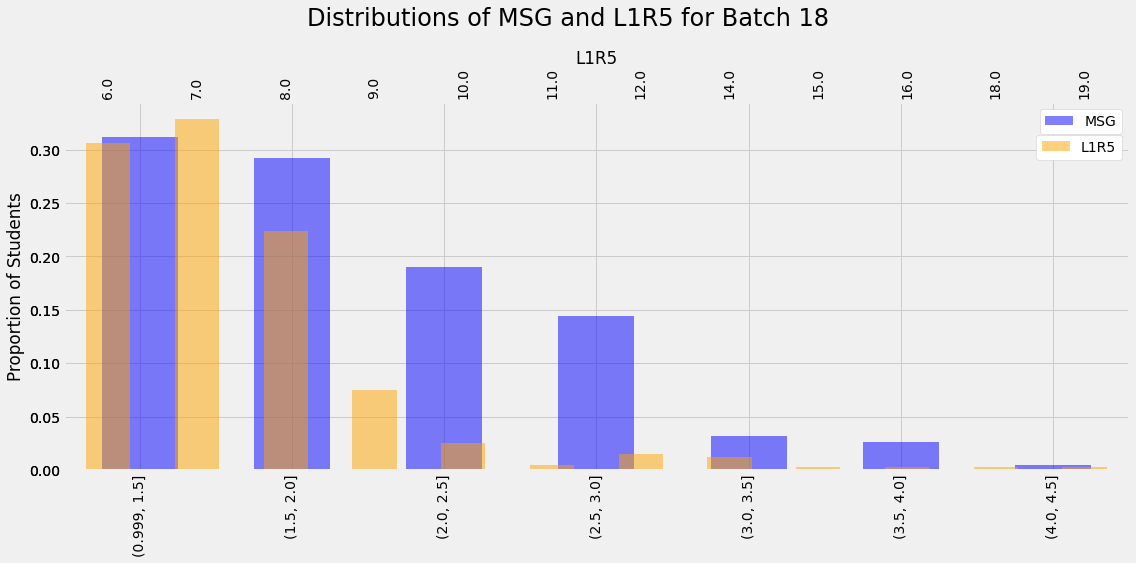

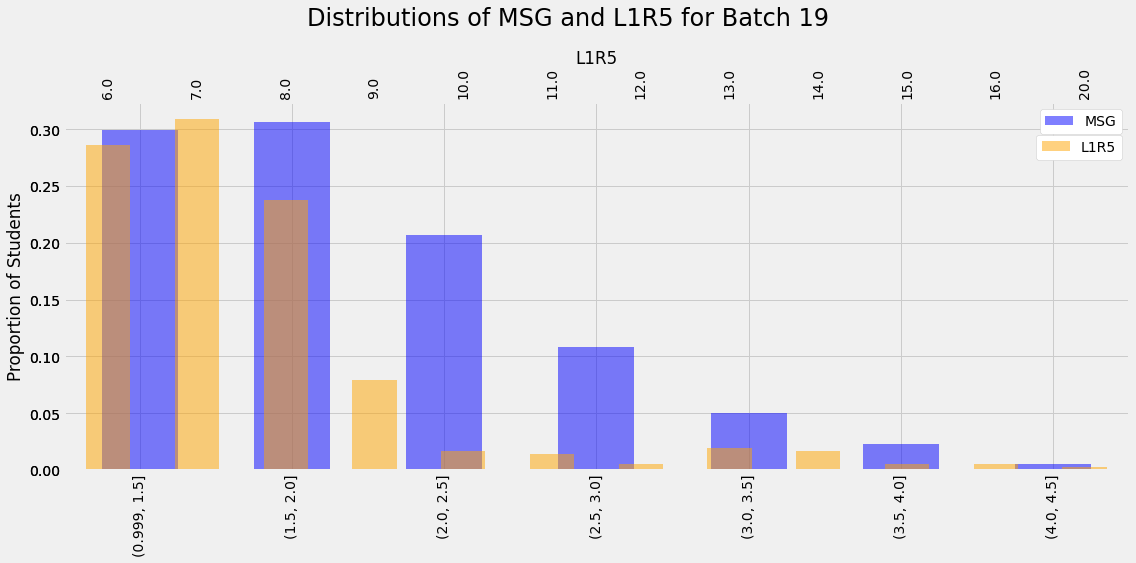

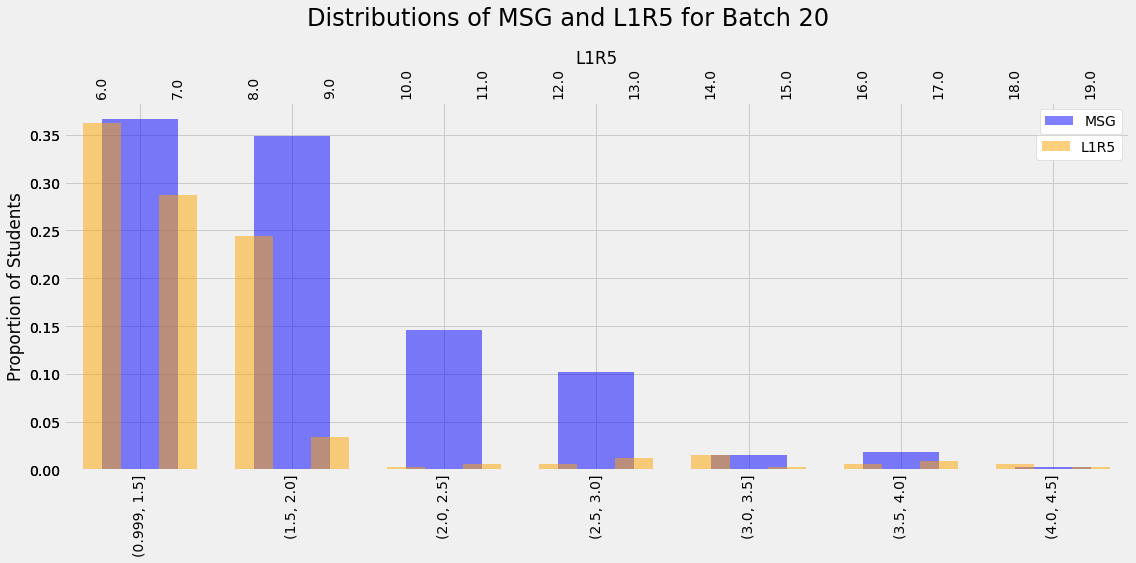

In [102]:
# plot distributions of MSG and L1R5
for i in range(3):
    fig, ax1 = plt.subplots()
    fig.suptitle(f'Distributions of MSG and L1R5 for Batch {i+18}', fontsize=24)
    s = pd.cut(Sec4[i]['MSG'], bins=[1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5], include_lowest=True)
    ax1 = s.value_counts(normalize=True).sort_index().plot(color='blue', kind='bar', 
                                                           alpha=.5, label='MSG')
    ax1.set_ylabel('Proportion of Students')
    ax1.legend(bbox_to_anchor=(1,1), facecolor='white', framealpha=1)
    ax2 = ax1.twiny()
    ax2 = Sec4[i].value_counts('L1R5', normalize=True).sort_index().plot(color='orange', kind='bar',
                                                                         alpha=.5, label='L1R5')
    ax2.legend(bbox_to_anchor=(1,0.93), facecolor='white', framealpha=1)
    ax2.grid(False)
    plt.tight_layout();

The distributions have a similar decreasing trend. We apply standard scaling to both columns before merging them into a new column 'SEC4 PTS'.

In [103]:
# standard scaling to both MSG and L1R5, then combine into column 'PTS_Sec4'
sc = StandardScaler()
for i in range(3):
    df = Sec4[i][['MSG', 'L1R5']]
    df = pd.DataFrame(sc.fit_transform(df), columns=df.columns, index=df.index)
    df['MSG'].fillna(df['L1R5'], inplace=True)
    df.rename(columns={'MSG': 'PTS_Sec4'}, inplace=True)
    Sec4[i] = pd.concat([Sec4[i], df[['PTS_Sec4']]], axis=1)
    display(Sec4[i]['PTS_Sec4'].head())

NEWID
20180001    0.235309
20180002   -0.827665
20180003    0.047532
20180005    0.335696
20180006   -0.245984
Name: PTS_Sec4, dtype: float64

NEWID
20190001    4.284206
20190002   -0.465438
20190003    0.531875
20190004    1.166528
20190005   -0.315633
Name: PTS_Sec4, dtype: float64

NEWID
20200001   -0.218251
20200002   -0.632111
20200003    0.235258
20200004    1.740122
20200005    0.765231
Name: PTS_Sec4, dtype: float64

### Check correlation coefficients

In [104]:
# add Sec4 columns to dataframe for checking correlation
test3_18 = pd.concat([Sec4[0][['PTS_Sec4', 'EM', 'AM']], test2_18], axis=1)
test3_19 = pd.concat([Sec4[1][['PTS_Sec4', 'EM', 'AM']], test2_19], axis=1)

for subj in ['EM','AM']:
    test3_18[subj] = test3_18[subj].map(lambda g: int(g[-1]), na_action='ignore')
    test3_19[subj] = test3_19[subj].map(lambda g: int(g[-1]), na_action='ignore')
    
# features ranked by magnitude of correlation to Target
corr3_18 = test3_18.corr().tail(1).T.sort_values('Target', key=abs)
corr3_19 = test3_19.corr().tail(1).T.sort_values('Target', key=abs)
corr3_18.rename(columns={'Target': 'Correlation with Target'}, inplace=True)
corr3_19.rename(columns={'Target': 'Correlation with Target'}, inplace=True)

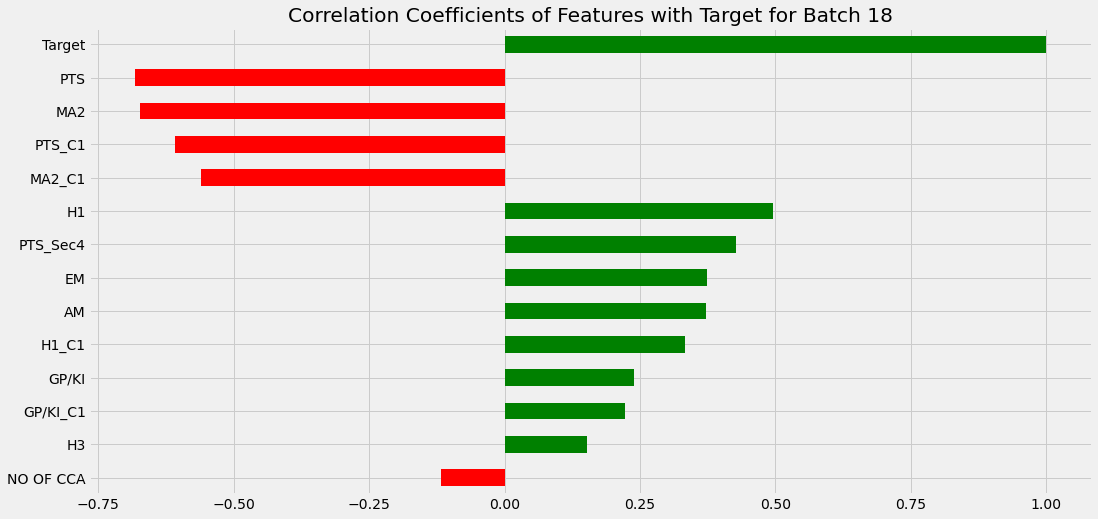

In [105]:
# plot correlation for Batch 18
plot_bar(corr3_18, 18)

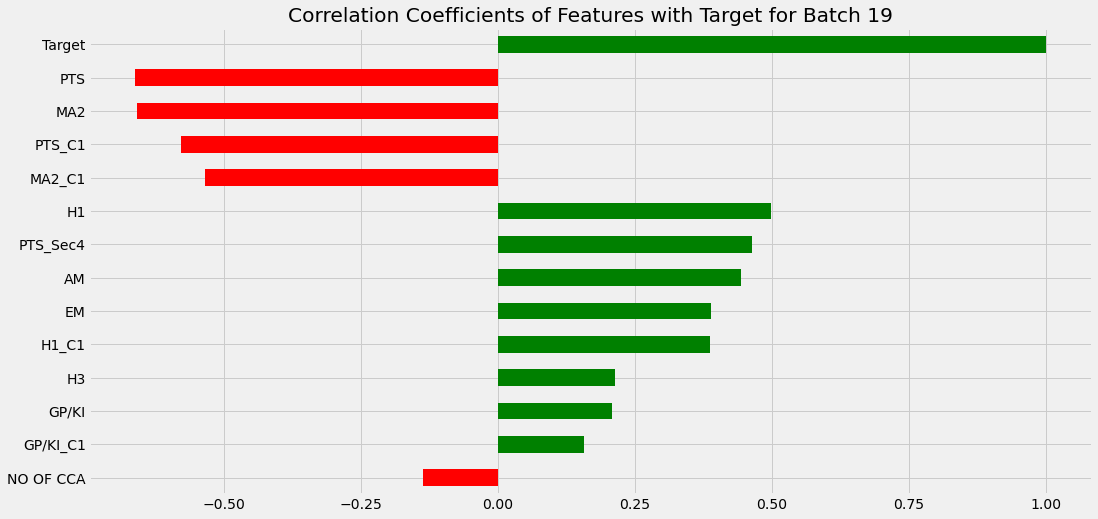

In [106]:
# plot correlation for Batch 19
plot_bar(corr3_19, 19)

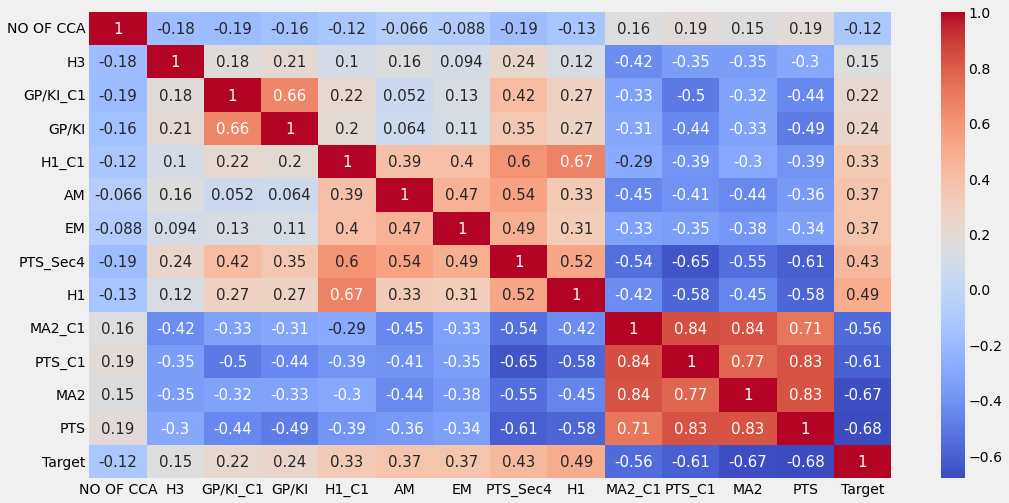

In [107]:
# plot heatmap of correlations for Batch 18
sns.heatmap(test3_18[corr3_18.index].corr(), cmap='coolwarm', annot=True, annot_kws={'size': 15});

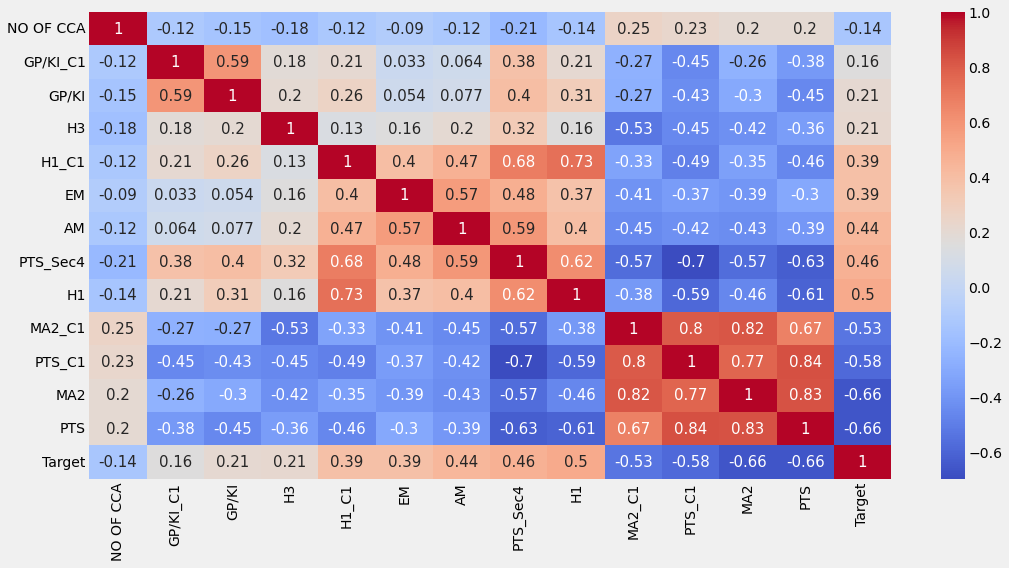

In [108]:
# plot heatmap of correlations for Batch 19
sns.heatmap(test3_19[corr3_19.index].corr(), cmap='coolwarm', annot=True, annot_kws={'size': 15});

The correlations of the numeric features with the Target are not low (between 0.3 and 0.5), and the inter-correlation between the features are not high, so we will add 'SEC4 PTS', 'EM' and 'AM' from Sec 4 results as predictors in our model. 

In [109]:
# combine Sec4 features to existing features dataframe
for i in range(3):
    for feature in ['PTS_Sec4', 'AM', 'EM']:
        Features[i][feature] = Sec4[i][feature]
        
    for subj in ['AM', 'EM']:
        Features[i][subj] = Features[i][subj].map(lambda g: int(g[-1]))

---
# CCA/CIP Datasets
NOTE: CELLS BELOW WILL NOT RUN as dataset is withheld due to confidentiality.

In [110]:
# load datasets
CCA_CIP_18 = pd.read_csv('../data_raw/18 Batch CCA CIP.csv', index_col=['NEWID'])
CCA_CIP_19 = pd.read_csv('../data_raw/19 Batch CCA CIP.csv', index_col=['NEWID'])
CCA_CIP_20 = pd.read_csv('../data_raw/20 Batch CCA CIP.csv', index_col=['NEWID'])

# for looping purposes
CCA_CIP = [CCA_CIP_18, CCA_CIP_19, CCA_CIP_20]

# drop students who did not take MA2, print number of columns and display first few rows
for i in range(3):
    CCA_CIP[i].drop(index=ind_to_del[i], inplace=True)
    print(f'Batch {batch[i]}: {CCA_CIP[i].shape[1]} columns')
    display(CCA_CIP[i].columns)
    print()

Batch 18: 8 columns


Index(['CCAS', 'MAJOR ACTIVITIES', 'CIP HOURS', 'DEMERIT POINTS',
       'LEADERSHIP OPPORTUNITIES', 'CCA LEADERSHIPS', 'CLASS LEADERSHIPS',
       'CIP LEADERSHIPS'],
      dtype='object')


Batch 19: 8 columns


Index(['CCAS', 'MAJOR ACTIVITIES', 'CIP HOURS', 'DEMERIT POINTS',
       'LEADERSHIP OPPORTUNITIES', 'CCA LEADERSHIPS', 'CLASS LEADERSHIPS',
       'CIP LEADERSHIPS'],
      dtype='object')


Batch 20: 8 columns


Index(['CCAS', 'MAJOR ACTIVITIES', 'CIP HOURS', 'DEMERIT POINTS',
       'LEADERSHIP OPPORTUNITIES', 'CCA LEADERSHIPS', 'CLASS LEADERSHIPS',
       'CIP LEADERSHIPS'],
      dtype='object')

The number of rows are correct and the columns are the same for all 3 batches. [Note: we changed from printing shape to just number of columns due to confidentiality.] We print the value counts for each column.

### CCAs and Major Activities
'CCAS' and 'MAJOR ACTIVITIES' have over 400 unique values, which is way too many, so we will drop them.

In [111]:
# print number of unique entries
for i in range(3):
    print(f' Batch {batch[i]} '.center(24, "="))
    print(f"Number of unique entries in CCAs: {CCA_CIP[i]['CCAS'].nunique()}")
    print(f"Number of unique entries in Major Activities: {CCA_CIP[i]['MAJOR ACTIVITIES'].nunique()}")
    print()

======= Batch 18 =======
Number of unique entries in CCAs: 491
Number of unique entries in Major Activities: 514

======= Batch 19 =======
Number of unique entries in CCAs: 473
Number of unique entries in Major Activities: 479

======= Batch 20 =======
Number of unique entries in CCAs: 446
Number of unique entries in Major Activities: 413



### CIP Hours
'CIP HOURS' is a numeric value that we may use, ranging from 0 to over 400 hours.

In [112]:
# print proportion of value counts for CIP Hours
for i in range(3):
    print(f' Batch {batch[i]} '.center(24, "="))
    print(round(CCA_CIP[i].value_counts('CIP HOURS', normalize=True).sort_index(), 2))
    print()

======= Batch 18 =======
CIP HOURS
2.0      0.0
2.5      0.0
3.0      0.0
5.0      0.0
5.5      0.0
        ... 
347.8    0.0
363.8    0.0
366.5    0.0
446.8    0.0
447.5    0.0
Length: 549, dtype: float64

======= Batch 19 =======
CIP HOURS
0.0      0.02
1.0      0.00
1.5      0.00
2.0      0.00
2.5      0.00
         ... 
297.0    0.00
304.5    0.00
305.5    0.00
367.4    0.00
470.0    0.00
Length: 380, dtype: float64

======= Batch 20 =======
CIP HOURS
0.0      0.08
1.0      0.00
1.5      0.00
2.0      0.01
3.0      0.00
         ... 
306.2    0.00
323.5    0.00
337.0    0.00
371.5    0.00
451.0    0.00
Length: 336, dtype: float64



### Demerit Points
'DEMERIT POINTS' are all recorded as 0, which is highly improbable so there was likely an error in the report and we will drop this column.

In [113]:
# print proportion of value counts for Demerit Points
for i in range(3):
    print(f' Batch {batch[i]} '.center(24, "="))
    print(round(CCA_CIP[i].value_counts('DEMERIT POINTS', normalize=True).sort_index(), 2))
    print()

======= Batch 18 =======
DEMERIT POINTS
0    1.0
dtype: float64

======= Batch 19 =======
DEMERIT POINTS
0    1.0
dtype: float64

======= Batch 20 =======
DEMERIT POINTS
0    1.0
dtype: float64



### Leadership Opportunities
Leadership opportunities is a binary field with just 'No' or 'Yes'. Although the distribution of value counts is ok, we choose to drop 'LEADERSHIP OPPORTUNITIES' as it included many small roles such as 'Subject Representative' in a class when we looked through the dataset.

In [114]:
# print proportion of value counts for Leadership Opportunities
for i in range(3):
    print(f' Batch {batch[i]} '.center(24, "="))
    print(round(CCA_CIP[i].value_counts('LEADERSHIP OPPORTUNITIES', normalize=True).sort_index(), 2))
    print()

======= Batch 18 =======
LEADERSHIP OPPORTUNITIES
No     0.15
Yes    0.85
dtype: float64

======= Batch 19 =======
LEADERSHIP OPPORTUNITIES
No     0.14
Yes    0.86
dtype: float64

======= Batch 20 =======
LEADERSHIP OPPORTUNITIES
No     0.11
Yes    0.89
dtype: float64



### CCA, Class and CIP Leaderships
We look through the dataset (not shared due to confidentiality) and noticed the following:

'CCA LEADERSHIPS' have some reflected when they are only a member of a particular subgroup, such as 'Member - Chinese Dance', which we want to remove. In addition, some positions are higher ranked, such as 'President', 'Captain'. We will transform information from this column into 3 columns tracking if a student is a President or Vice-President equivalent, a Secretary or Treasurer, or a slightly smaller role (with keywords Leader or I/C or Quartermaster).

'CLASS LEADERSHIPS' include some rather small roles like 'Subject Representative'. We decide to track only 'CT Representative' and 'Assistant CT Representative'

'CIP LEADERSHIPS' can be broadly divided into 'Team Leader' (include 'Chairperson') and 'Organising Team Member' (any non-empty text that is not 'Team Leader'.

We will thus one-hot encode these information appropriately.

In [115]:
# print number of unique entries
for i in range(3):
    print(f' Batch {batch[i]} '.center(24, "="))
    print(f"CCA: {CCA_CIP[i]['CCA LEADERSHIPS'].nunique()}")
    print(f"Class: {CCA_CIP[i]['CLASS LEADERSHIPS'].nunique()}")
    print(f"CIP: {CCA_CIP[i]['CIP LEADERSHIPS'].nunique()}")
    print()

======= Batch 18 =======
CCA: 348
Class: 35
CIP: 357

======= Batch 19 =======
CCA: 365
Class: 37
CIP: 292

======= Batch 20 =======
CCA: 355
Class: 41
CIP: 345



In [116]:
for i in range(3):
    # create columns tracking CCA leaderships
    CCA_CIP[i]['CCA President'] = CCA_CIP[i]['CCA LEADERSHIPS'].map(
        lambda t: 1 if 'President' in t else 1 if 'Captain' in t else 1 if 'Head' in t else 0, na_action = 'ignore')
    CCA_CIP[i]['CCA President'].fillna(0, inplace=True)
    CCA_CIP[i]['CCA Sec-Treas'] = CCA_CIP[i]['CCA LEADERSHIPS'].map(
        lambda t: 1 if 'Secretary' in t else 1 if 'Treasurer' in t else 0, na_action = 'ignore')
    CCA_CIP[i]['CCA Sec-Treas'].fillna(0, inplace=True)
    CCA_CIP[i]['CCA Role'] = CCA_CIP[i]['CCA LEADERSHIPS'].map(
        lambda t: 1 if 'Leader' in t else 1 if 'I/C' in t else 1 if 'Quartermaster' in t else 0, na_action = 'ignore')
    CCA_CIP[i]['CCA Role'].fillna(0, inplace=True)

    # create column tracking CG leaderships
    CCA_CIP[i]['CT Rep'] = CCA_CIP[i]['CLASS LEADERSHIPS'].map(
        lambda t: 1 if 'CT Representative' in t else 0, na_action = 'ignore')
    CCA_CIP[i]['CT Rep'].fillna(0, inplace=True)
    
    # create columns tracking CIP leaderships
    CCA_CIP[i]['CIP Leader'] = CCA_CIP[i]['CIP LEADERSHIPS'].map(
        lambda t: 1 if 'Team Leader' in t else 1 if 'Chairperson' in t else 0, na_action = 'ignore')
    CCA_CIP[i]['CIP Leader'].fillna(0, inplace=True)
    CCA_CIP[i]['CIP Organiser'] = CCA_CIP[i]['CIP LEADERSHIPS'].map(
        lambda t: 0 if 'Team Leader' in t else 0 if 'Chairperson' in t else 1, na_action = 'ignore')
    CCA_CIP[i]['CIP Organiser'].fillna(0, inplace=True)    

### Check correlation coefficients
The only numeric feature from CCA_CIP datasets is 'CIP HOURS'. We add this to the existing datasets for finding correlation strength.

In [117]:
# add 'CIP HOURS' to existing datasets
test4_18 = pd.concat([CCA_CIP[0]['CIP HOURS'], test3_18], axis=1)
test4_19 = pd.concat([CCA_CIP[1]['CIP HOURS'], test3_19], axis=1)

# features ranked by magnitude of correlation to Target
corr4_18 = test4_18.corr().tail(1).T.sort_values('Target', key=abs)
corr4_19 = test4_19.corr().tail(1).T.sort_values('Target', key=abs)
corr4_18.rename(columns={'Target': 'Correlation with Target'}, inplace=True)
corr4_19.rename(columns={'Target': 'Correlation with Target'}, inplace=True)

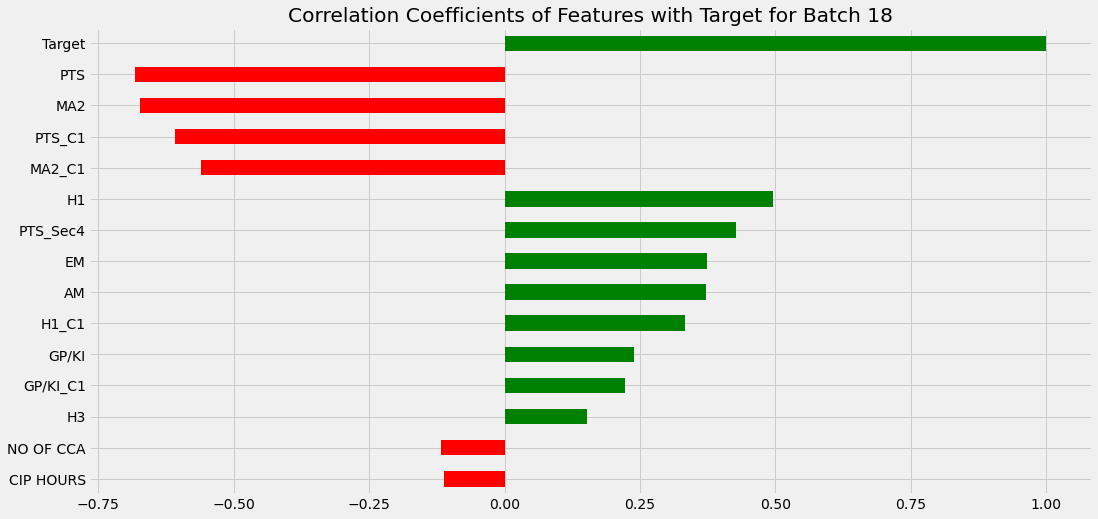

In [118]:
plot_bar(corr4_18, 18)

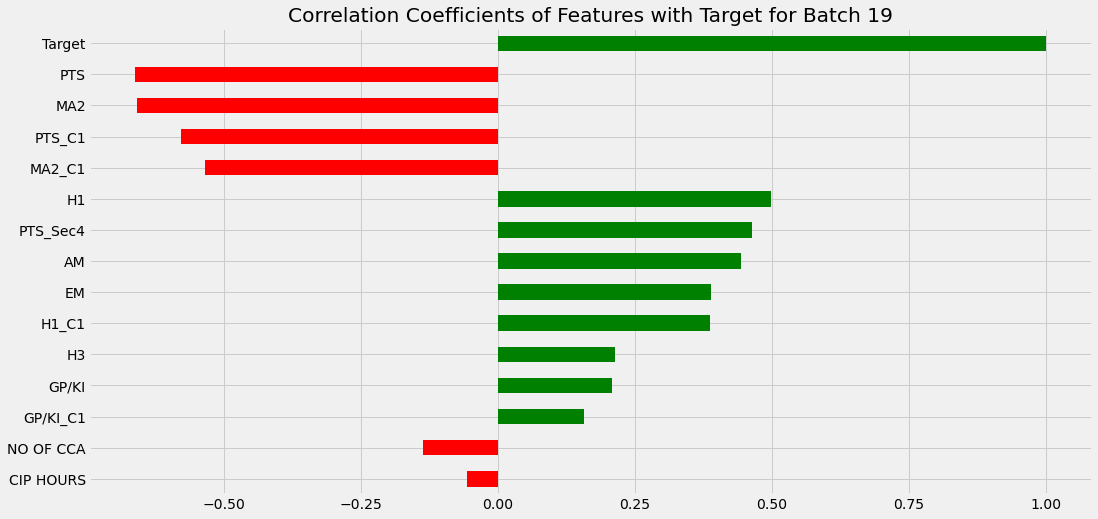

In [119]:
plot_bar(corr4_19, 19)

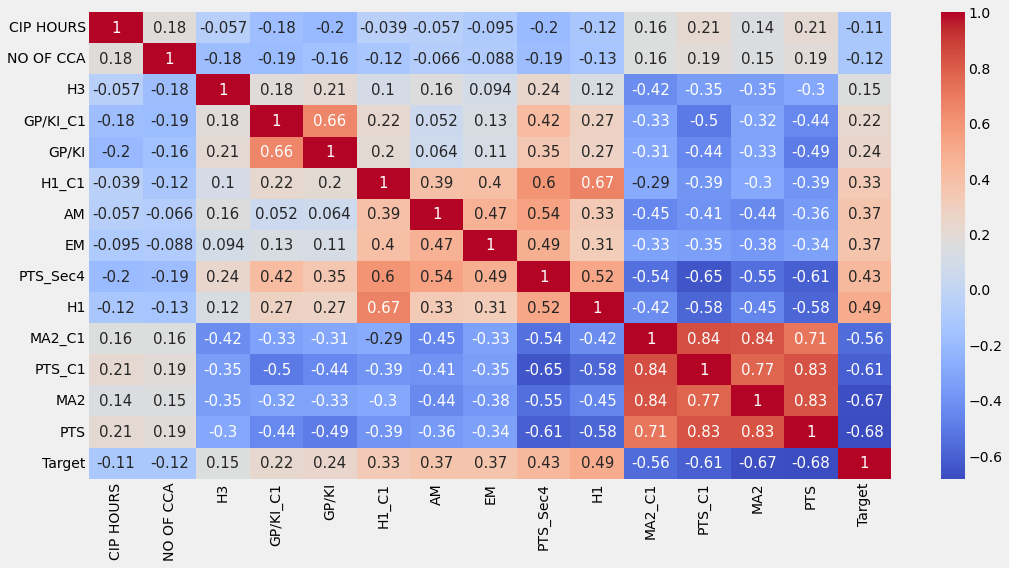

In [120]:
# plot heatmap of correlations for Batch 18
sns.heatmap(test4_18[corr4_18.index].corr(), cmap='coolwarm', annot=True, annot_kws={'size': 15});

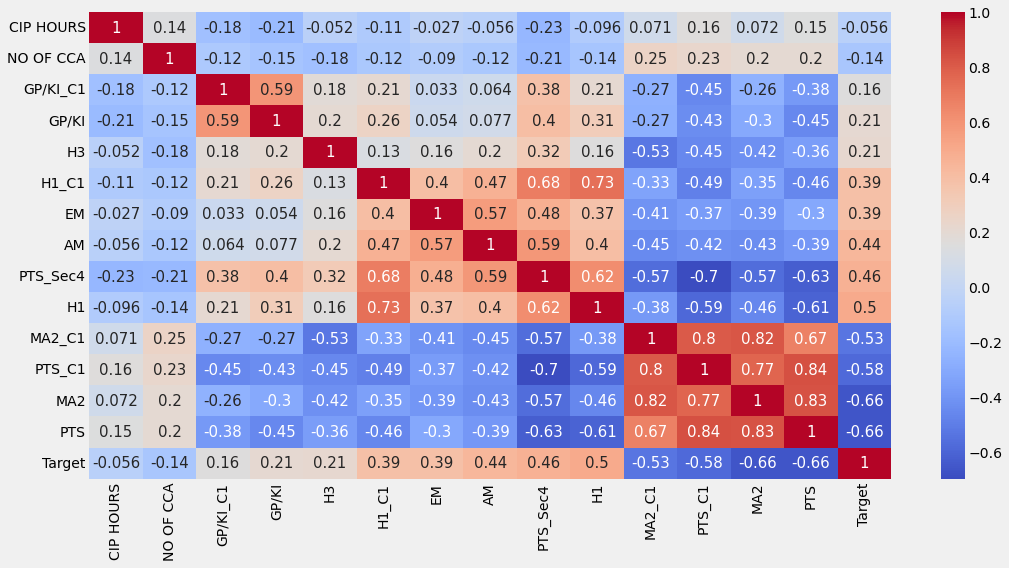

In [121]:
# plot heatmap of correlations for Batch 19
sns.heatmap(test4_19[corr4_19.index].corr(), cmap='coolwarm', annot=True, annot_kws={'size': 15});

The correlation of 'CIP HOURS' with our target is low in batch 18 and even lower in batch 19. We will run it through our modelling and will not be surprised if it turns out not to be an important feature.

In [122]:
# add CCA features to final Features dataframes
CCA_Features = ['CIP HOURS', 'CCA President', 'CCA Sec-Treas', 'CCA Role', 
                'CT Rep', 'CIP Leader', 'CIP Organiser']
for i in range(3):
    for feature in CCA_Features:
        Features[i][feature] = CCA_CIP[i][feature]
        
    # check Features dataframes have no empty cells and are all numerical values
    print(f' Batch {batch[i]} '.center(24, "="))
    print(f'Number of empty cells: {Features[i].isna().sum().sum()}')
    print(Features[i].dtypes)
    print()

======= Batch 18 =======
Number of empty cells: 0
GENDER_F                                            uint8
GENDER_M                                            uint8
INTAKE_DSA                                          uint8
INTAKE_DSA (CCA)                                    uint8
INTAKE_IP (X)                                       uint8
INTAKE_IP (Y)                                       uint8
INTAKE_JAE Ordinary Admission                       uint8
SEC SCHOOL_BUKIT PANJANG GOVT. HIGH SCHOOL          uint8
SEC SCHOOL_CATHOLIC HIGH SCHOOL                     uint8
SEC SCHOOL_CHIJ ST. NICHOLAS GIRLS' SCHOOL          uint8
SEC SCHOOL_CHUNG CHENG HIGH SCHOOL (MAIN)           uint8
SEC SCHOOL_METHODIST GIRLS' SCHOOL (SECONDARY)      uint8
SEC SCHOOL_NAN HUA HIGH SCHOOL                      uint8
SEC SCHOOL_SCHOOL X                                 uint8
SEC SCHOOL_SCHOOL Y                                 uint8
SEC SCHOOL__Minority_Sch                            uint8
KI                    

In [123]:
# export to csv
Features[0].to_csv('../data_cleaned/Features_18.csv')
Features[1].to_csv('../data_cleaned/Features_19.csv')
Features[2].to_csv('../data_cleaned/Features_20.csv')